In [4]:
import os
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd
import numpy as np
from scipy import stats
from scipy.spatial import distance
from matplotlib import gridspec
from sklearn.preprocessing import normalize
import pandas as pd
import ast


import caiman as cm
from caiman.source_extraction import cnmf
from caiman.utils.utils import download_demo
from caiman.utils.visualization import inspect_correlation_pnr
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import params as params
from caiman.source_extraction.cnmf.deconvolution import constrained_foopsi
from caiman.source_extraction.cnmf.deconvolution import constrained_oasisAR2

#plotting params
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = '0.5'
mpl.rcParams['axes.labelsize'] = '8'
mpl.rcParams['axes.labelcolor'] = 'black'

mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['xtick.labelsize'] = '4'
mpl.rcParams['ytick.labelsize'] = '4'
mpl.rcParams['ytick.color'] = 'black'

In [80]:
folder = r'\\172.16.251.125\Inscopix\Francesco\H2234 - 4X\H2234_4X_EGO_PH2\TRA'
file='H2234_E34_TRA.csv'

all_traces_dlc = pd.read_csv(os.path.join(folder, file))


C:\Users\fgobbo\Anaconda3\envs\caiman\lib\site-packages\IPython\core\interactiveshell.py:3170: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [81]:
#remove rejected cells 
all_traces_dlc.T[all_traces_dlc.T[0]!=' rejected'].T
all_traces_dlc=all_traces_dlc.T[all_traces_dlc.T[0]!=' rejected'].T[1:]

In [82]:
#remove NaNs and covert them to zero (single session)
all_traces_dlc.rename(columns={' ':'Time'}, inplace=True)
all_traces_dlc = all_traces_dlc.replace(' nan', np.nan)
all_traces_dlc=all_traces_dlc.fillna(0)

all_traces_dlc

Time        C00         C01         C02        C03        C04  \
1                 0   93.72385   -63.18317   -8.673514   99.95003   282.0687   
2          0.049961   83.60503   -59.26879   -10.73955   74.04986   273.0901   
3          0.099922   97.72262   -52.97665   -15.66212   97.91682   274.9818   
4          0.149883   97.56086    -25.3405   -17.80369   122.1482   251.9037   
5          0.199844   90.07967   -29.54717    25.62354   115.7648    243.548   
...             ...        ...         ...         ...        ...        ...   
107495  8449.692476   41.22162    114.7105   -35.40063   98.90862   65.45222   
107496  8449.742437   51.29086    110.9643   -26.79903   86.06813   58.19298   
107497  8449.792398   34.32085     92.5489   -41.38623   103.6957   41.63589   
107498  8449.842359   19.18308    95.99431    -32.9811     60.577  -3.208336   
107499   8449.89232   21.89311    88.98814   -4.649268   81.48228   25.39391   

              C05          C06         C07           C08  ...         C31  \
1        52.99895    -19.12431    8.824681       10.9091  ...   -19.75277   
2        49.35035   -0.5990923   -8.646559       3.93187  ...     3.94436   
3        52.58574     -30.4373    13.14339   -0.05990668  ...   0.4052393   
4        68.01127    -8.358397    5.237114     -19.41915  ...   -8.944113   
5        70.35294    -27.97172    15.46722      8.268644  ...   0.7474343   
...           ...          ...         ...           ...  ...         ...   
107495   3.271769     94.85732           0       96.4209  ...    60.58838   
107496   1.102093     97.62531           0      103.3883  ...    14.14951   
107497   0.630499     90.13217           0      89.83395  ...    27.51371   
107498   24.46696     79.37813           0      51.43721  ...    34.69392   
107499   13.86255     95.83775           0      82.99834  ...    11.29691   

               C32         C33        C34       C35       C36  C37       C38  \
1         5.411344    5.064536   225.9962         0         0    0         0   
2         6.956408   -6.224114   250.4449         0         0    0         0   
3        -12.48978    -14.4478   232.9456         0         0    0         0   
4         1.886158   -3.595691   247.4229         0         0    0         0   
5         10.92141   -16.57452   241.8899         0         0    0         0   
...            ...         ...        ...       ...       ...  ...       ...   
107495           0    103.6702   -21.5786  34.22188  24.20985    0  -46.0616   
107496           0    97.93642  -1.119719  55.37625  35.74923    0 -0.082489   
107497           0    133.0593  -25.21367  47.33879  38.56037    0 -11.38316   
107498           0    107.3238  -28.99224  40.37317 -1.662326    0 -3.816706   
107499           0    88.01167  -22.17846   36.2193  11.42504    0  -3.08127   

             C39       C40  
1              0         0  
2              0         0  
3              0         0  
4              0         0  
5              0         0  
...          ...       ...  
107495  82.24271 -2.500623  
107496  83.16369  0.055333  
107497  90.37785   24.7276  
107498  71.25823  14.35035  
107499  80.13344  0.321568  

[107499 rows x 42 columns]

In [83]:
raw_traces = all_traces_dlc.reset_index(drop=True)
be_a_cell=[col for col in raw_traces.columns if col.startswith(' C')]
raw_traces=raw_traces[be_a_cell]
cells = raw_traces.columns
#be_a_cell

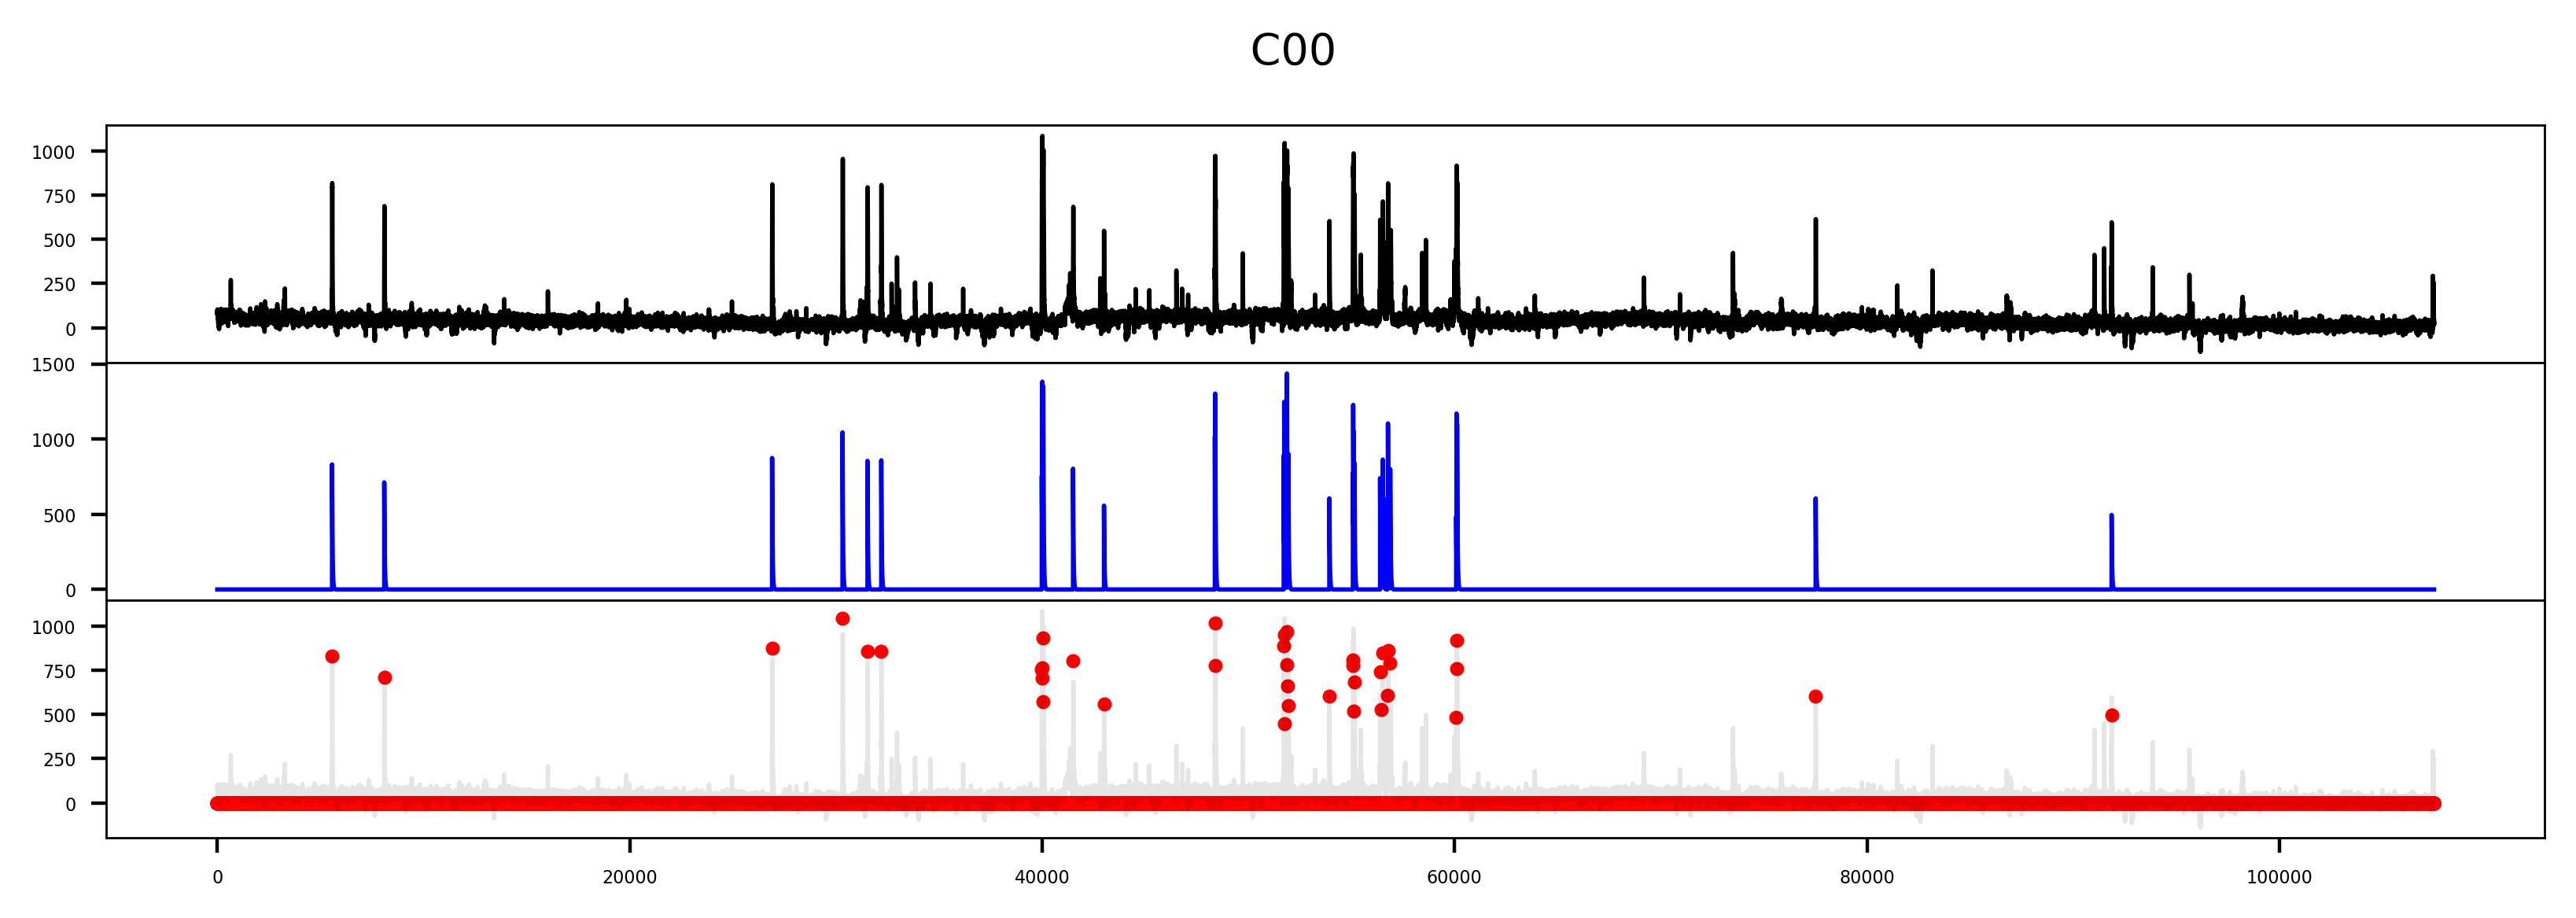

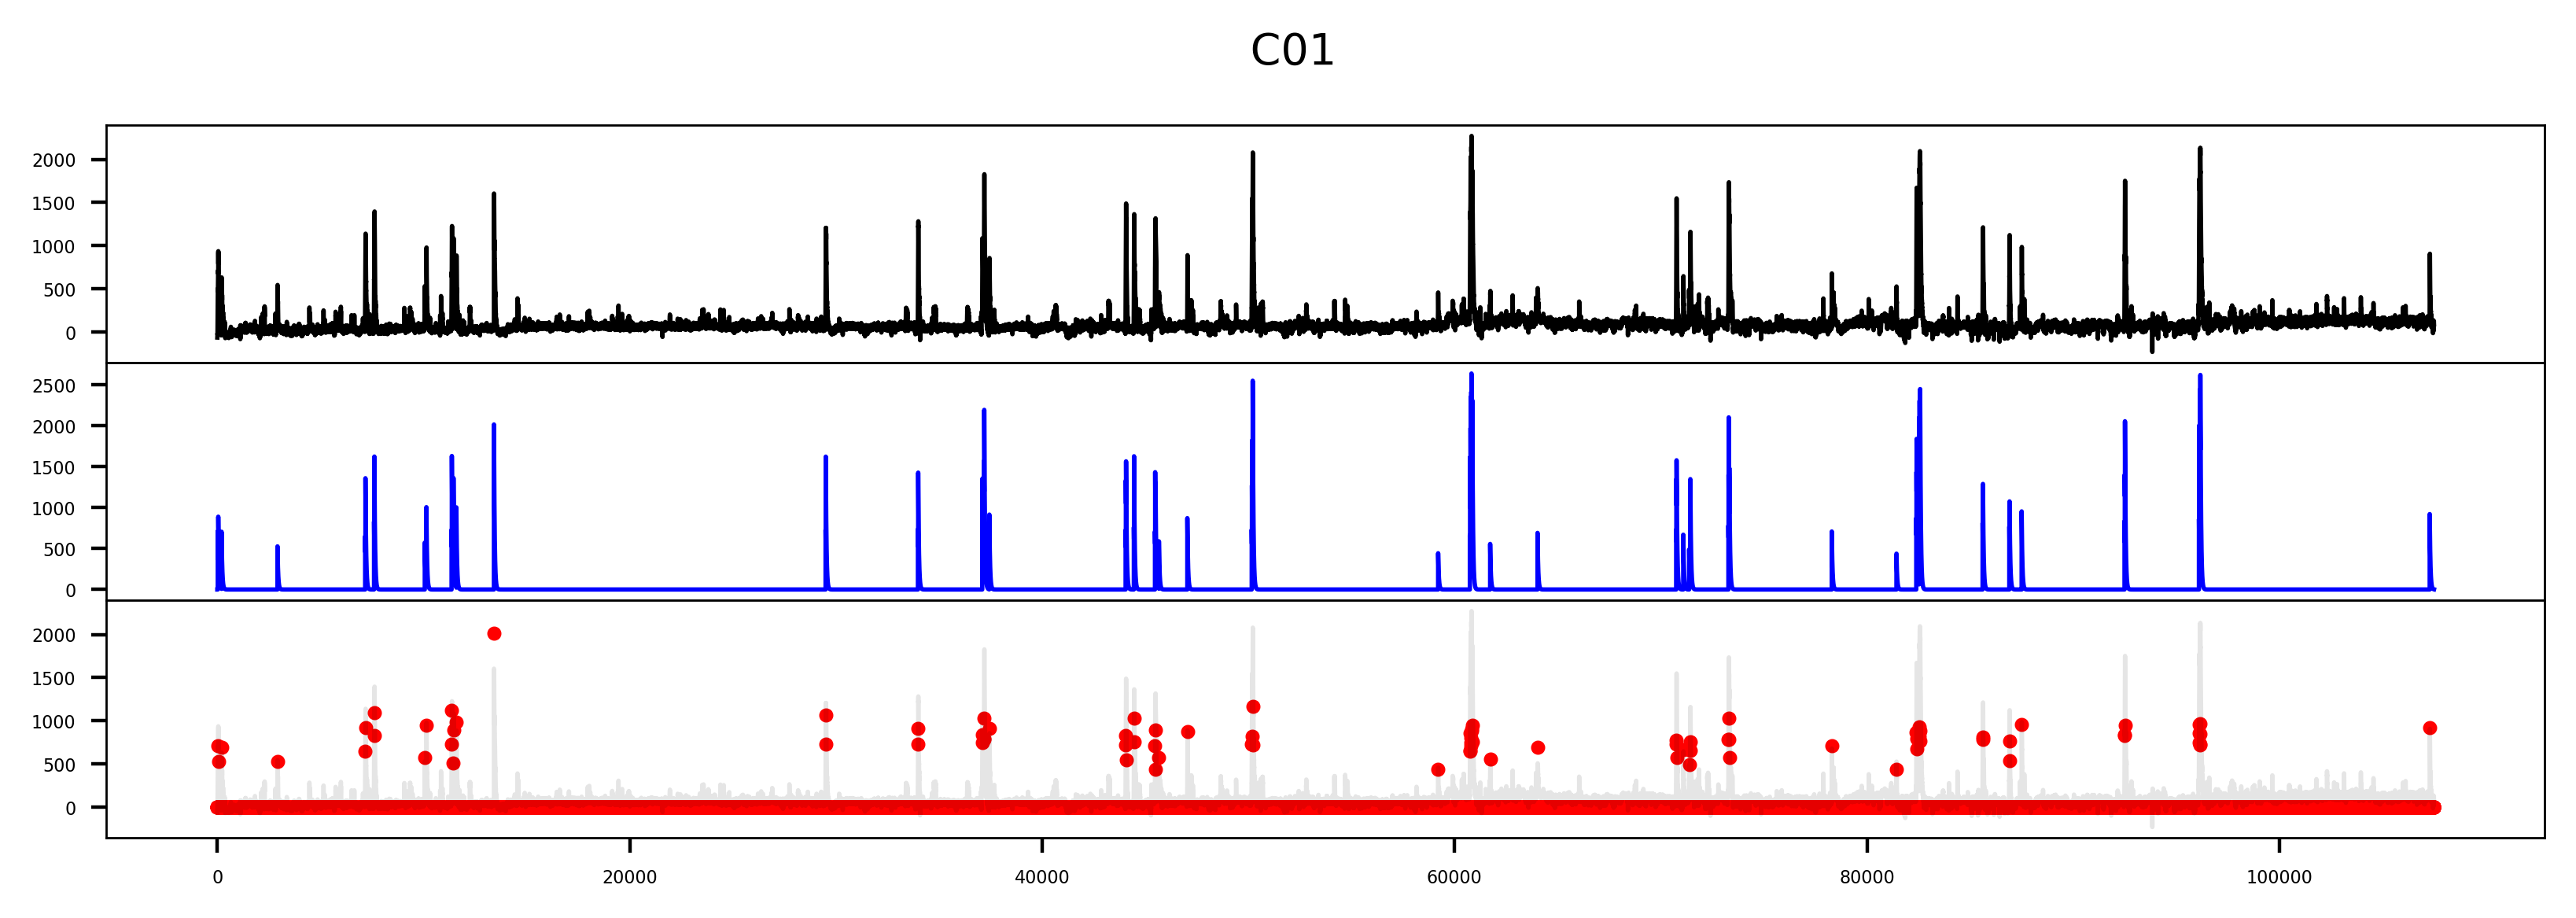

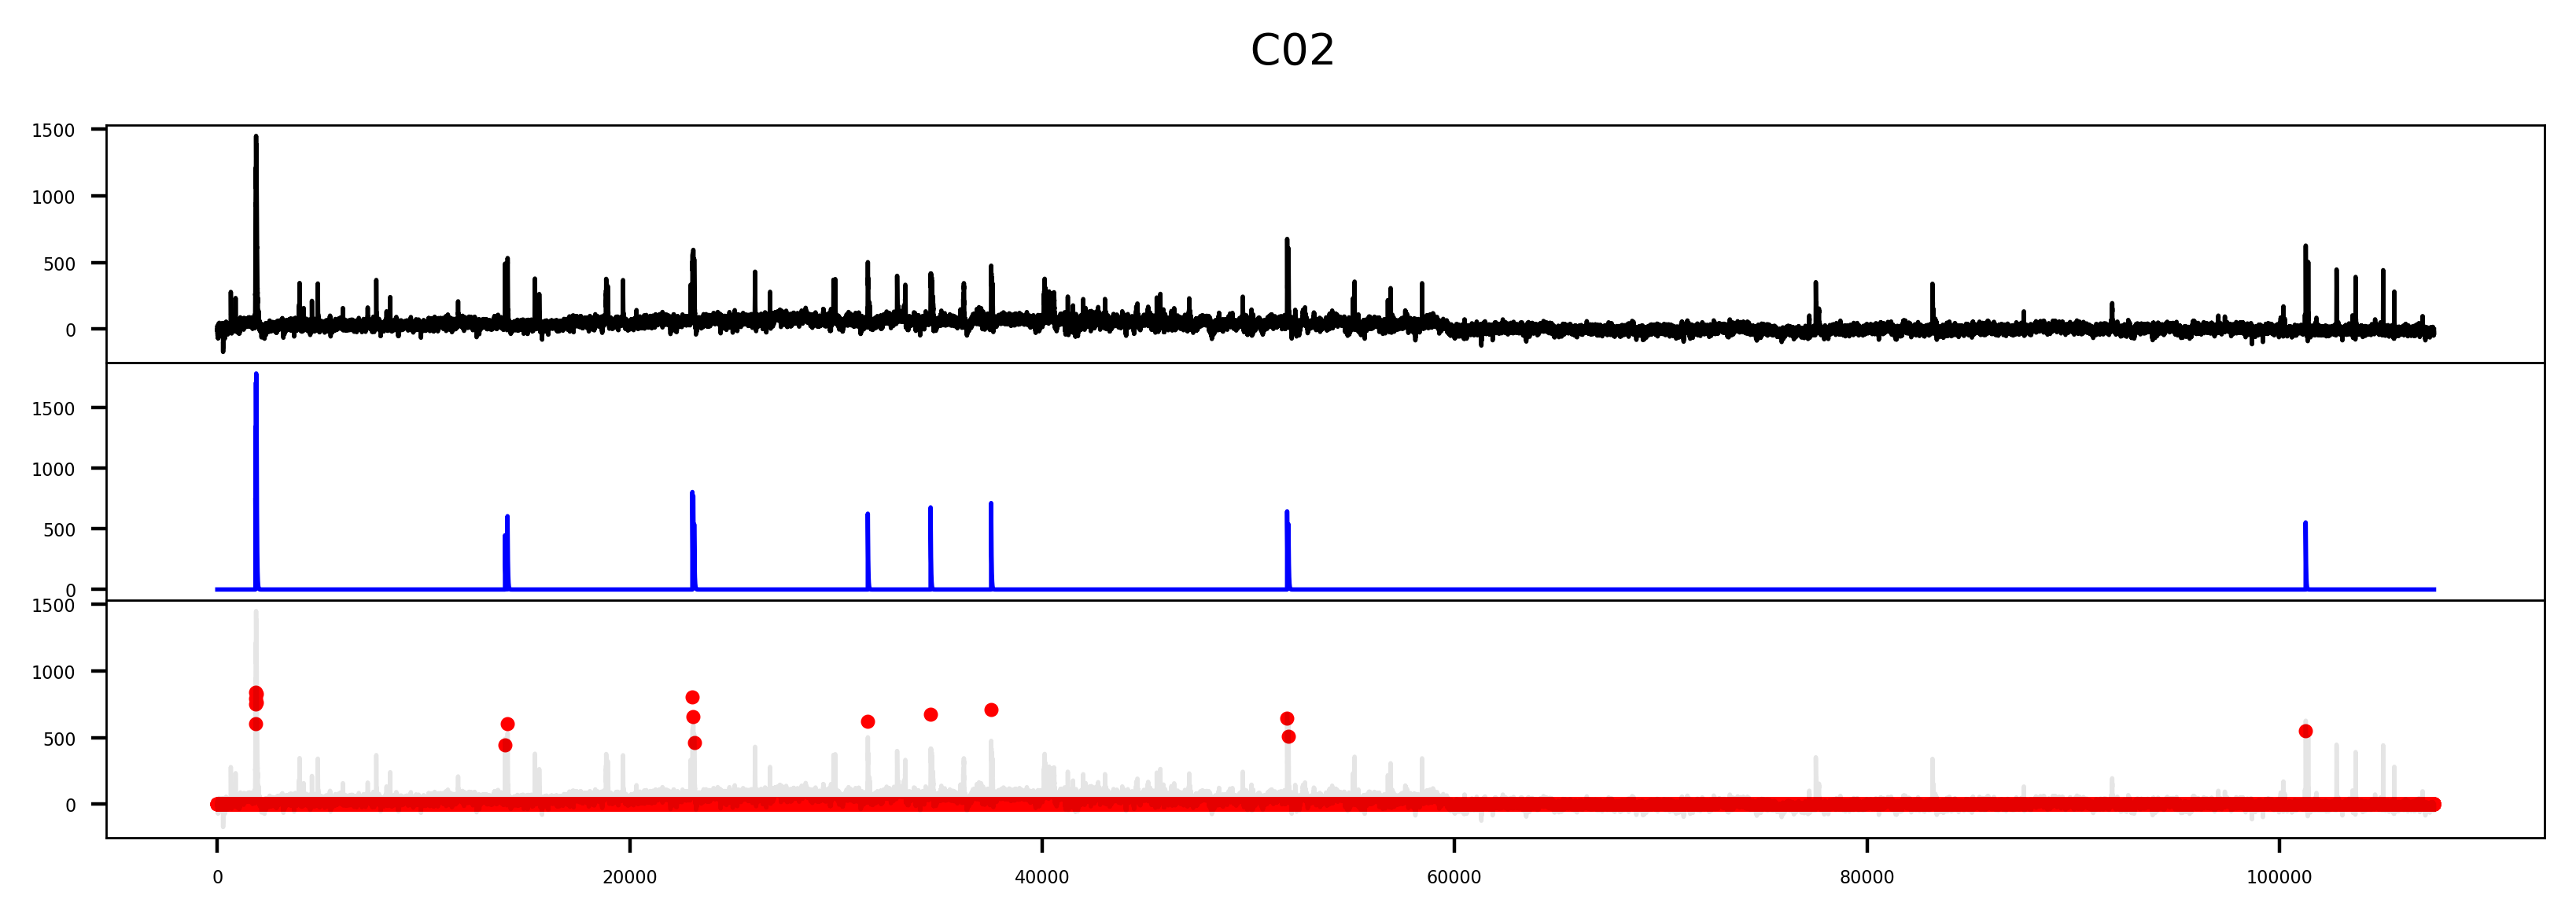

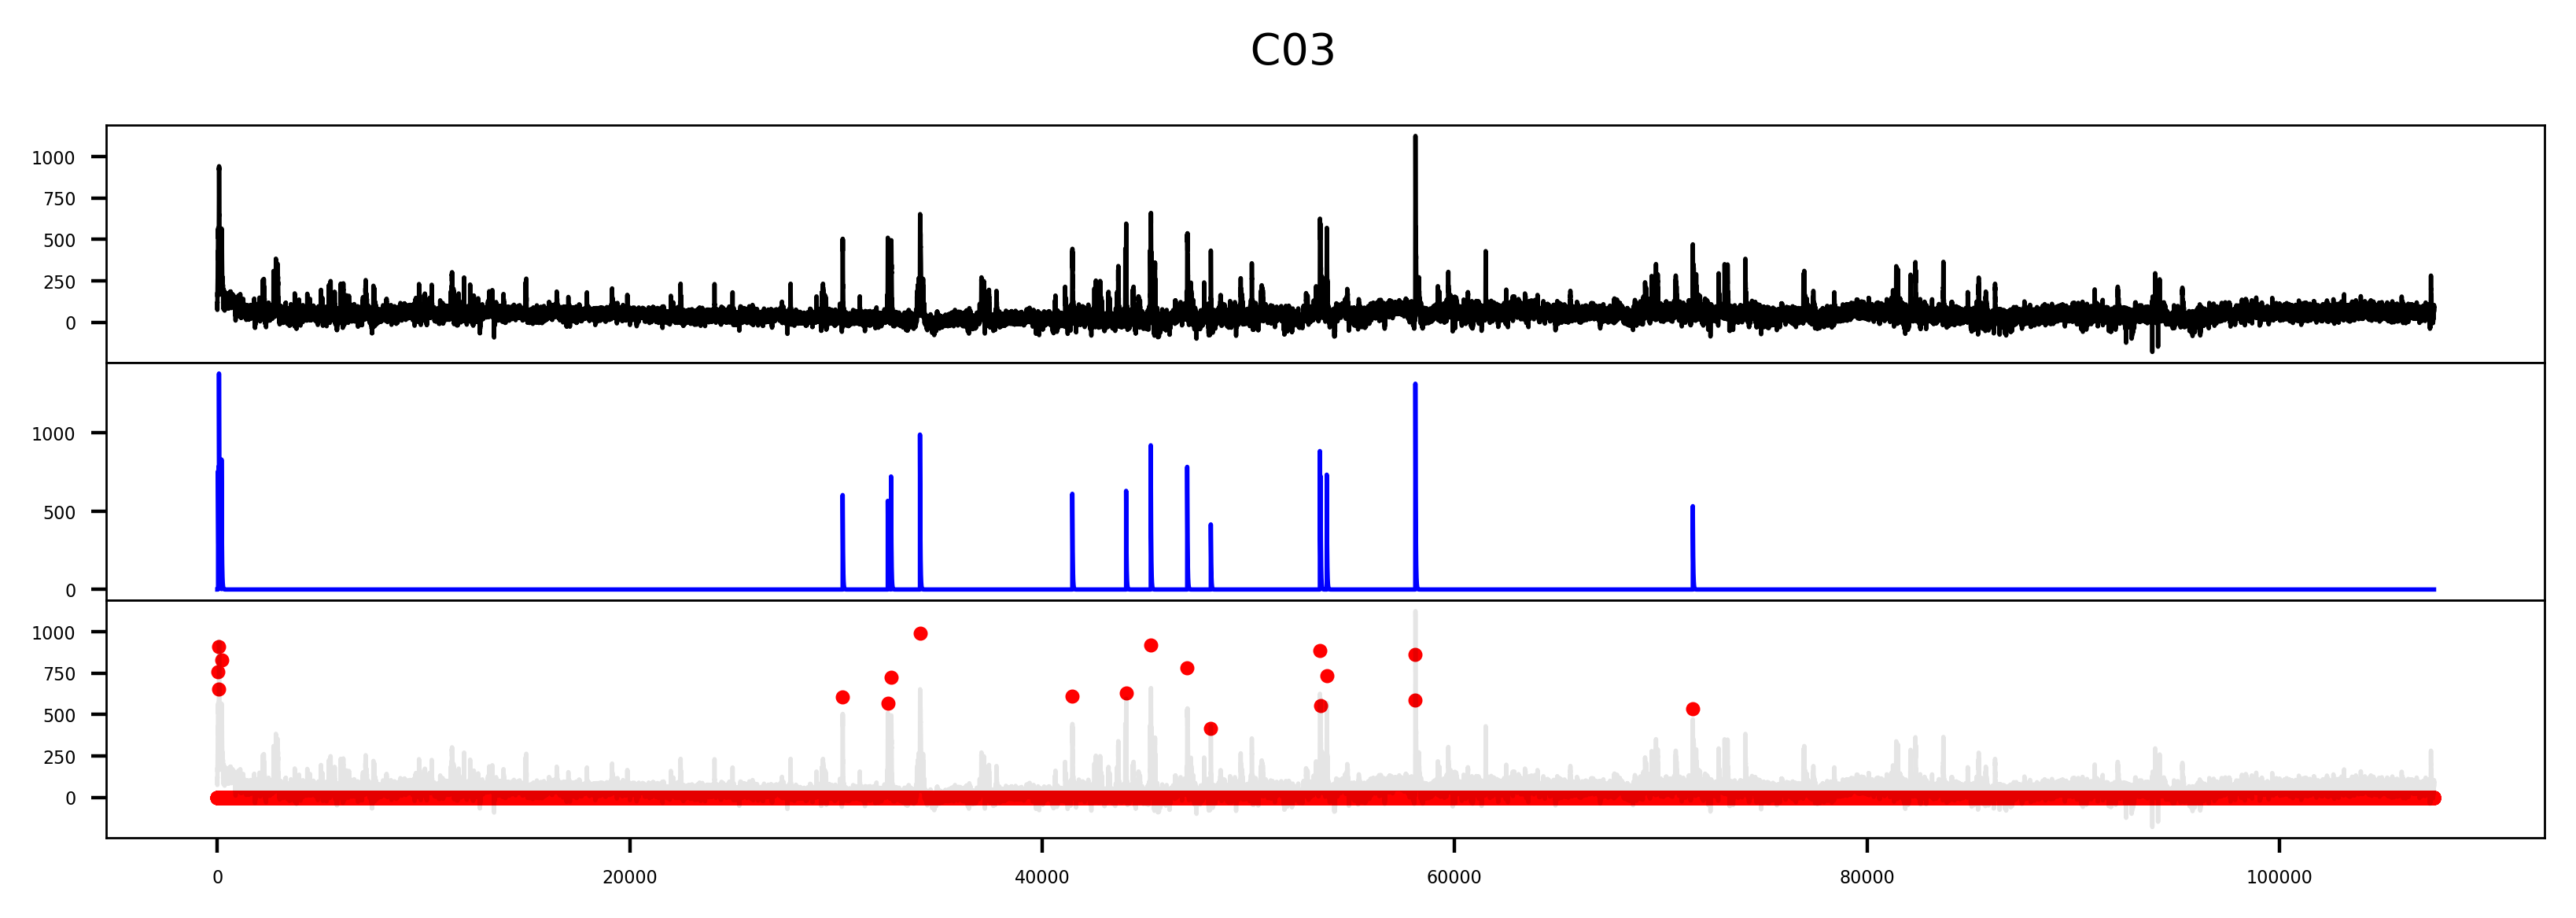

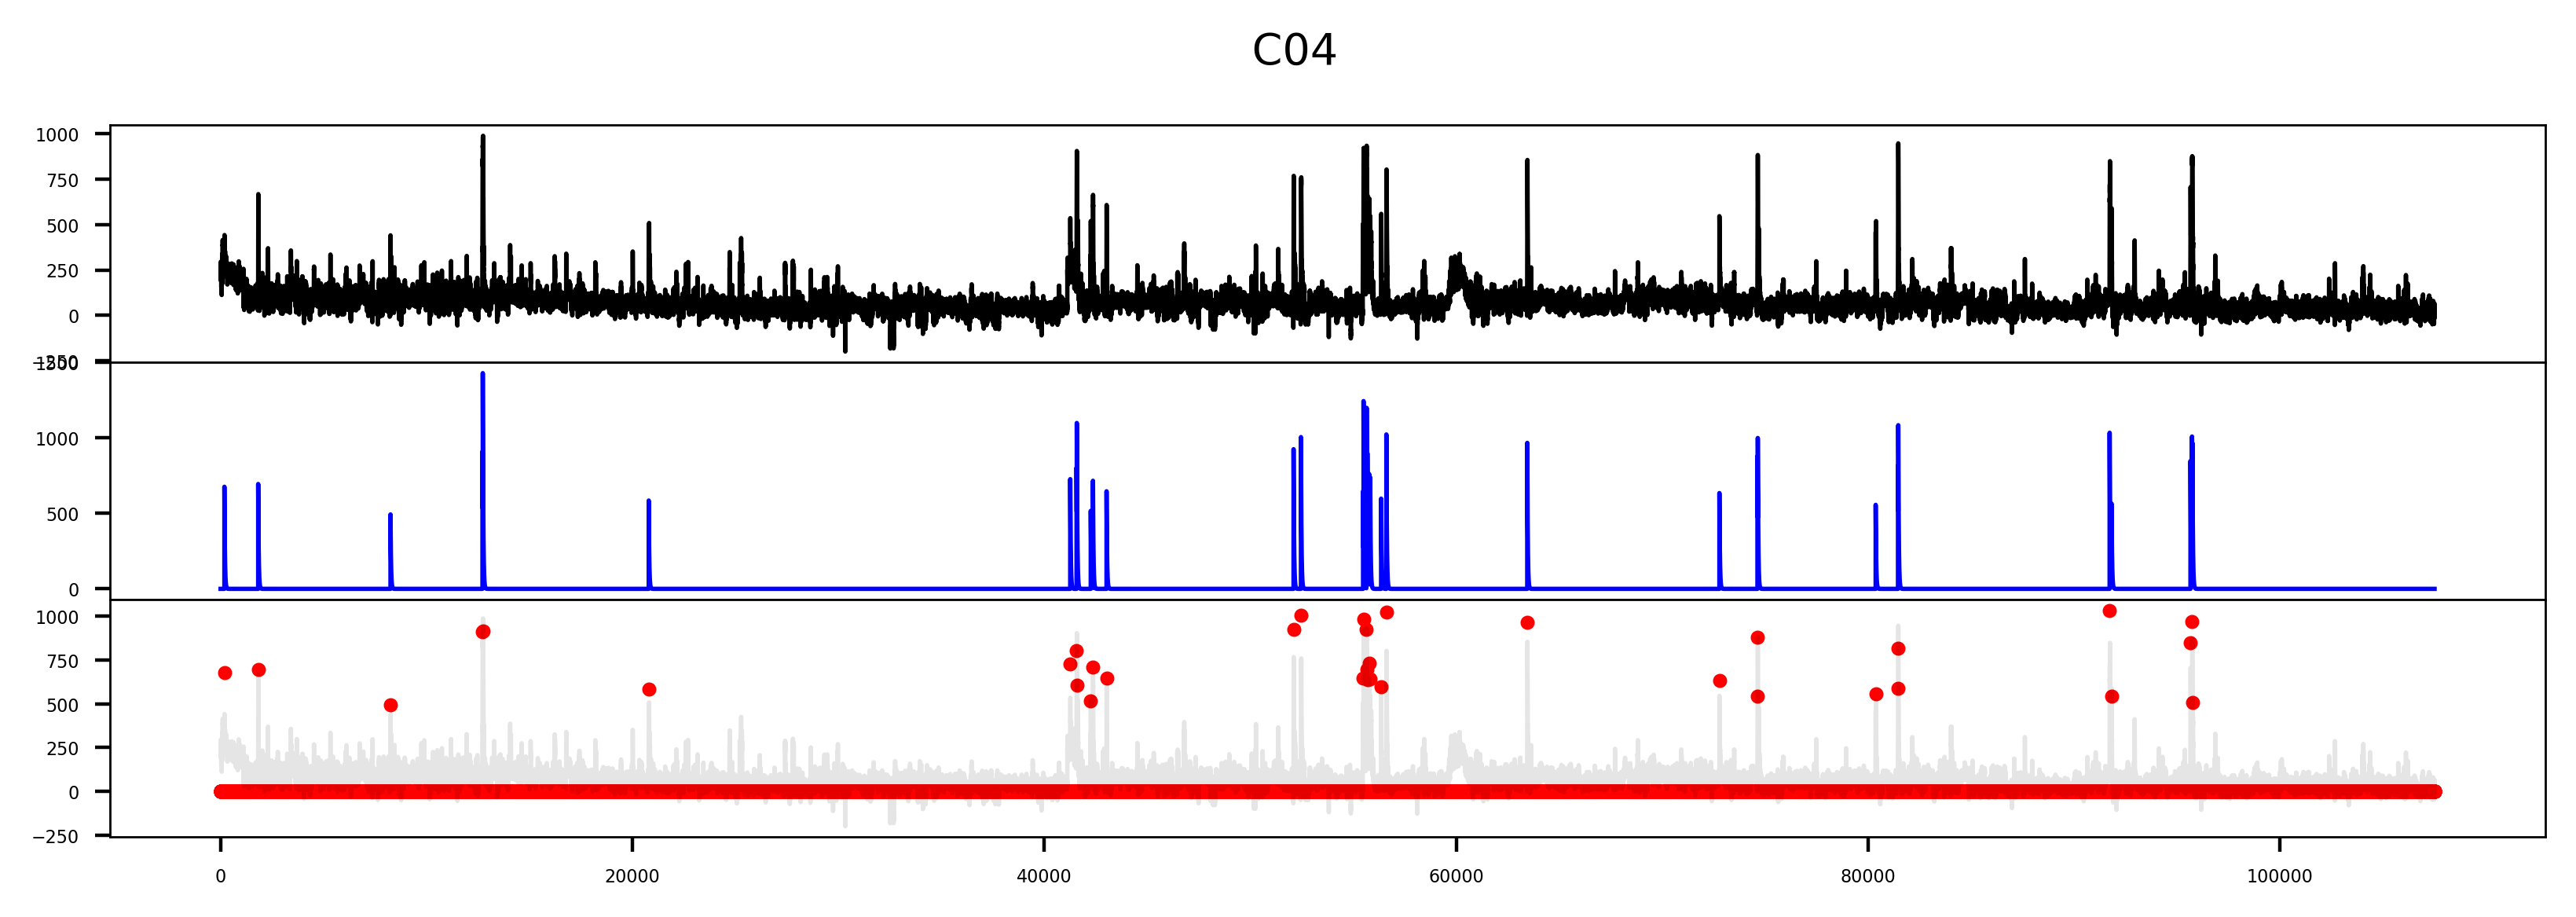

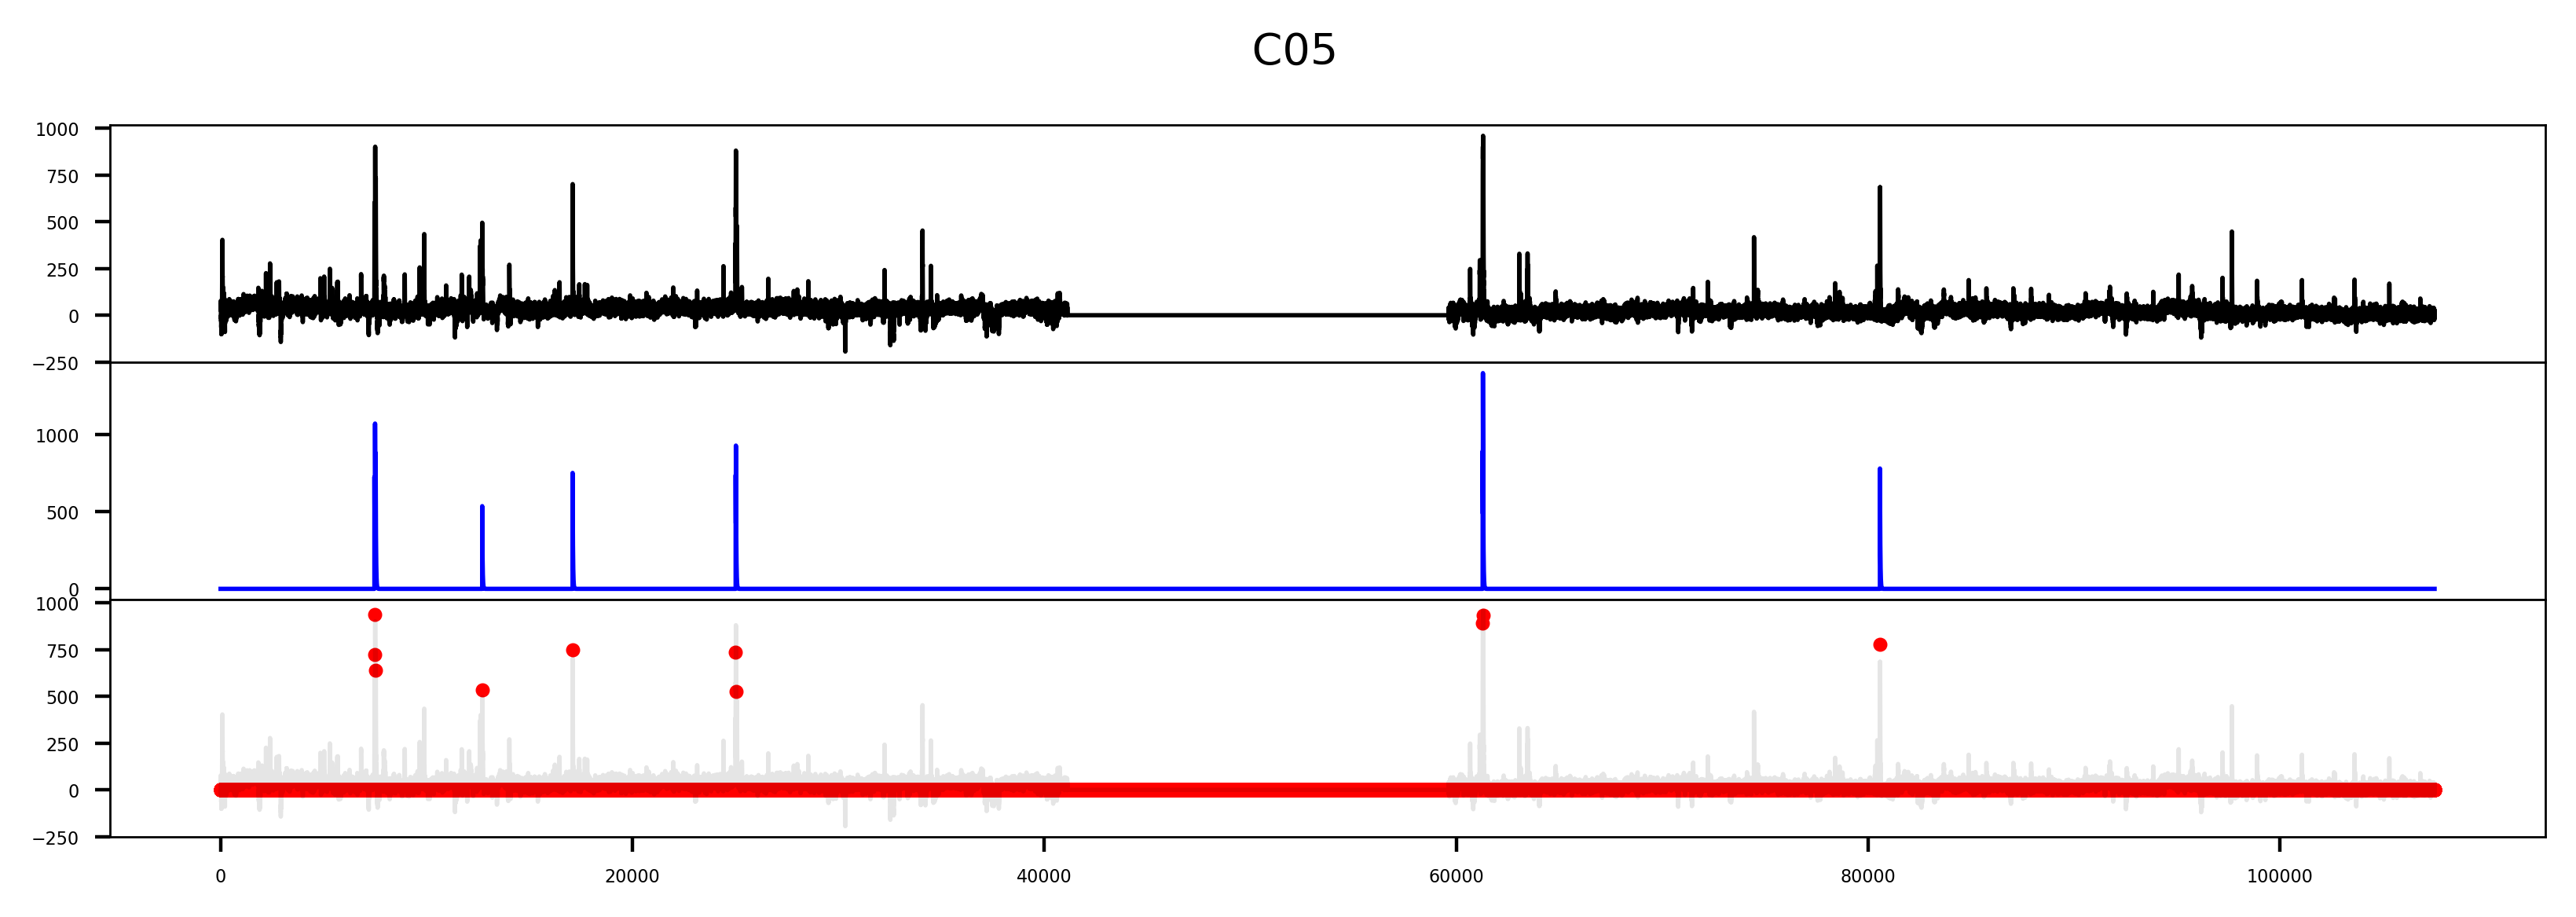

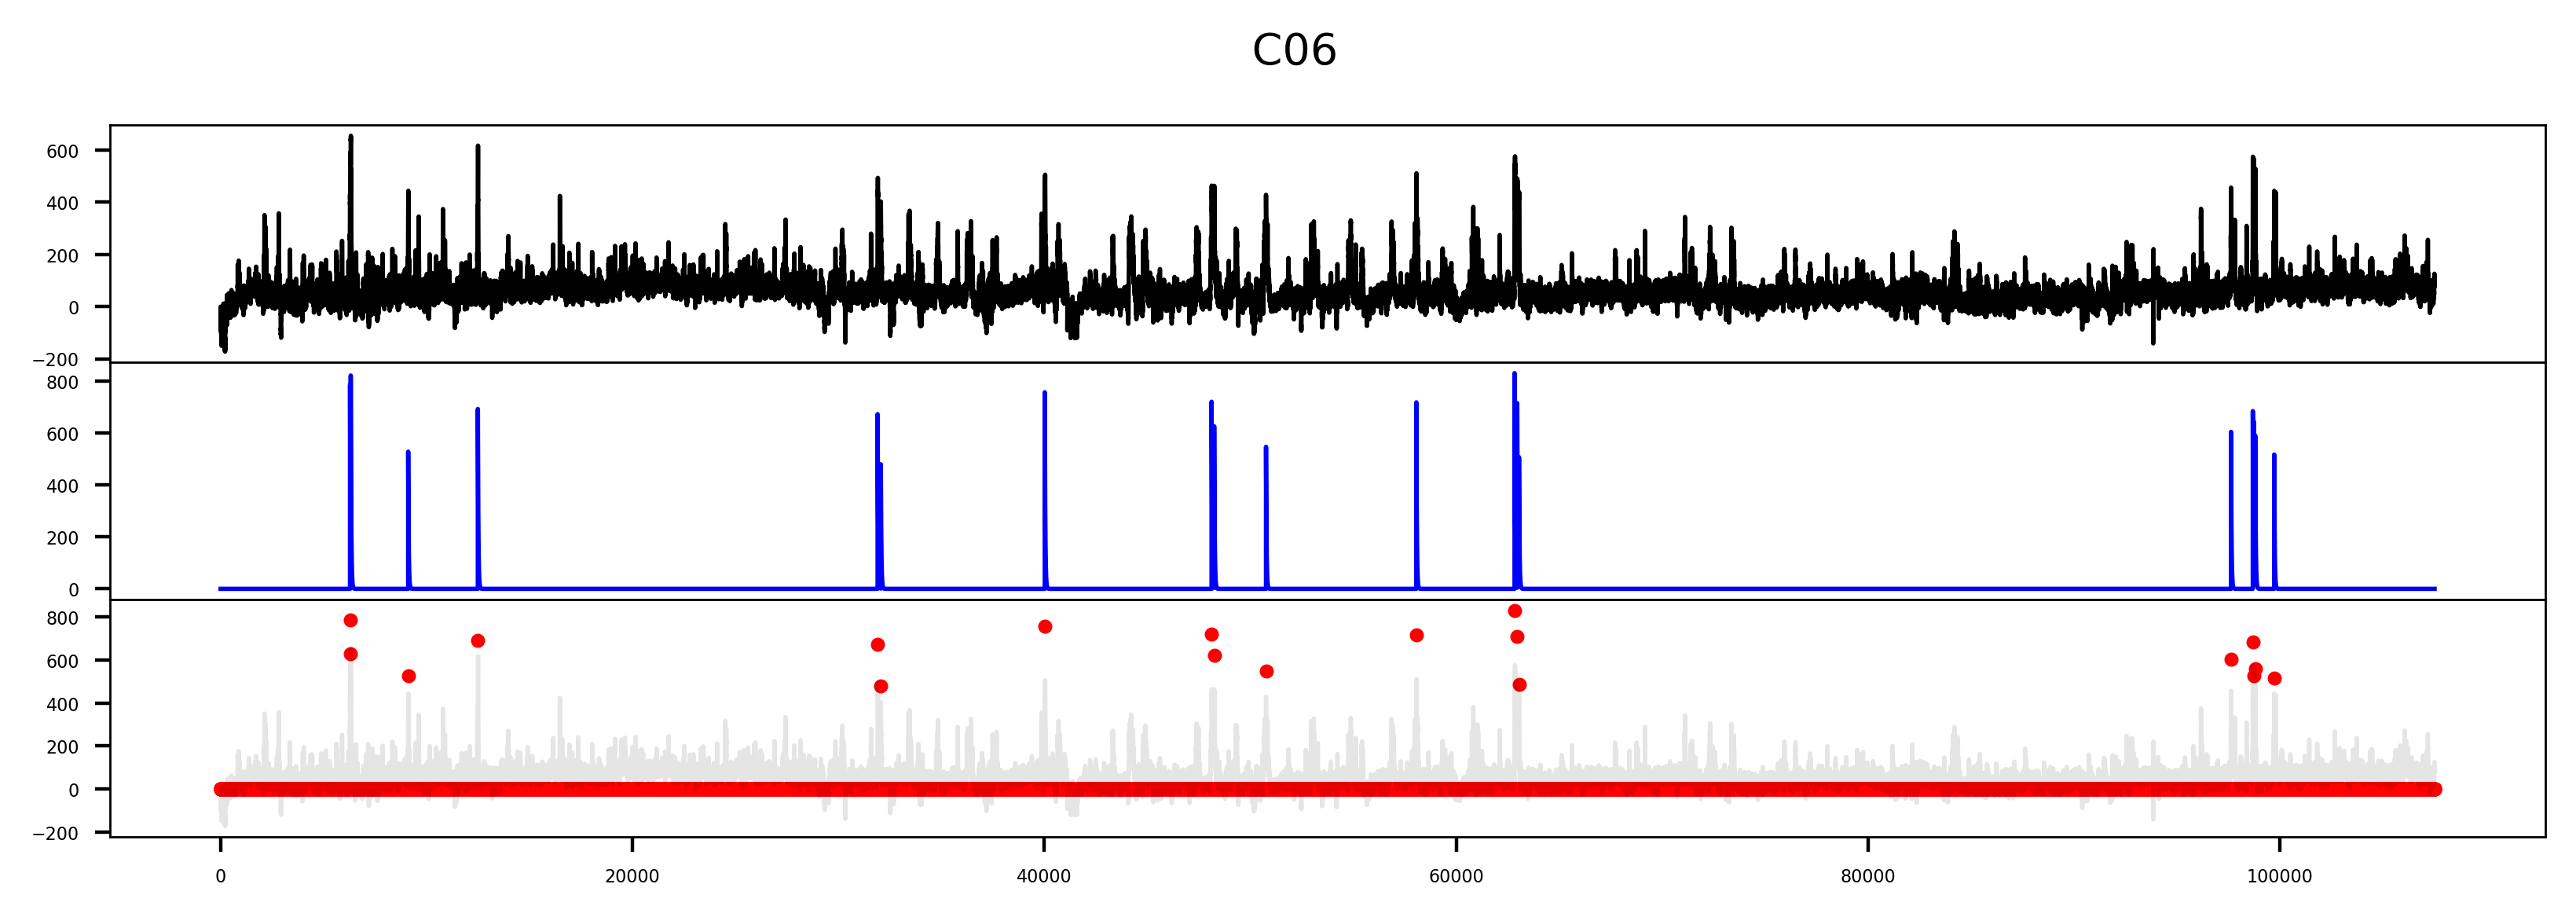

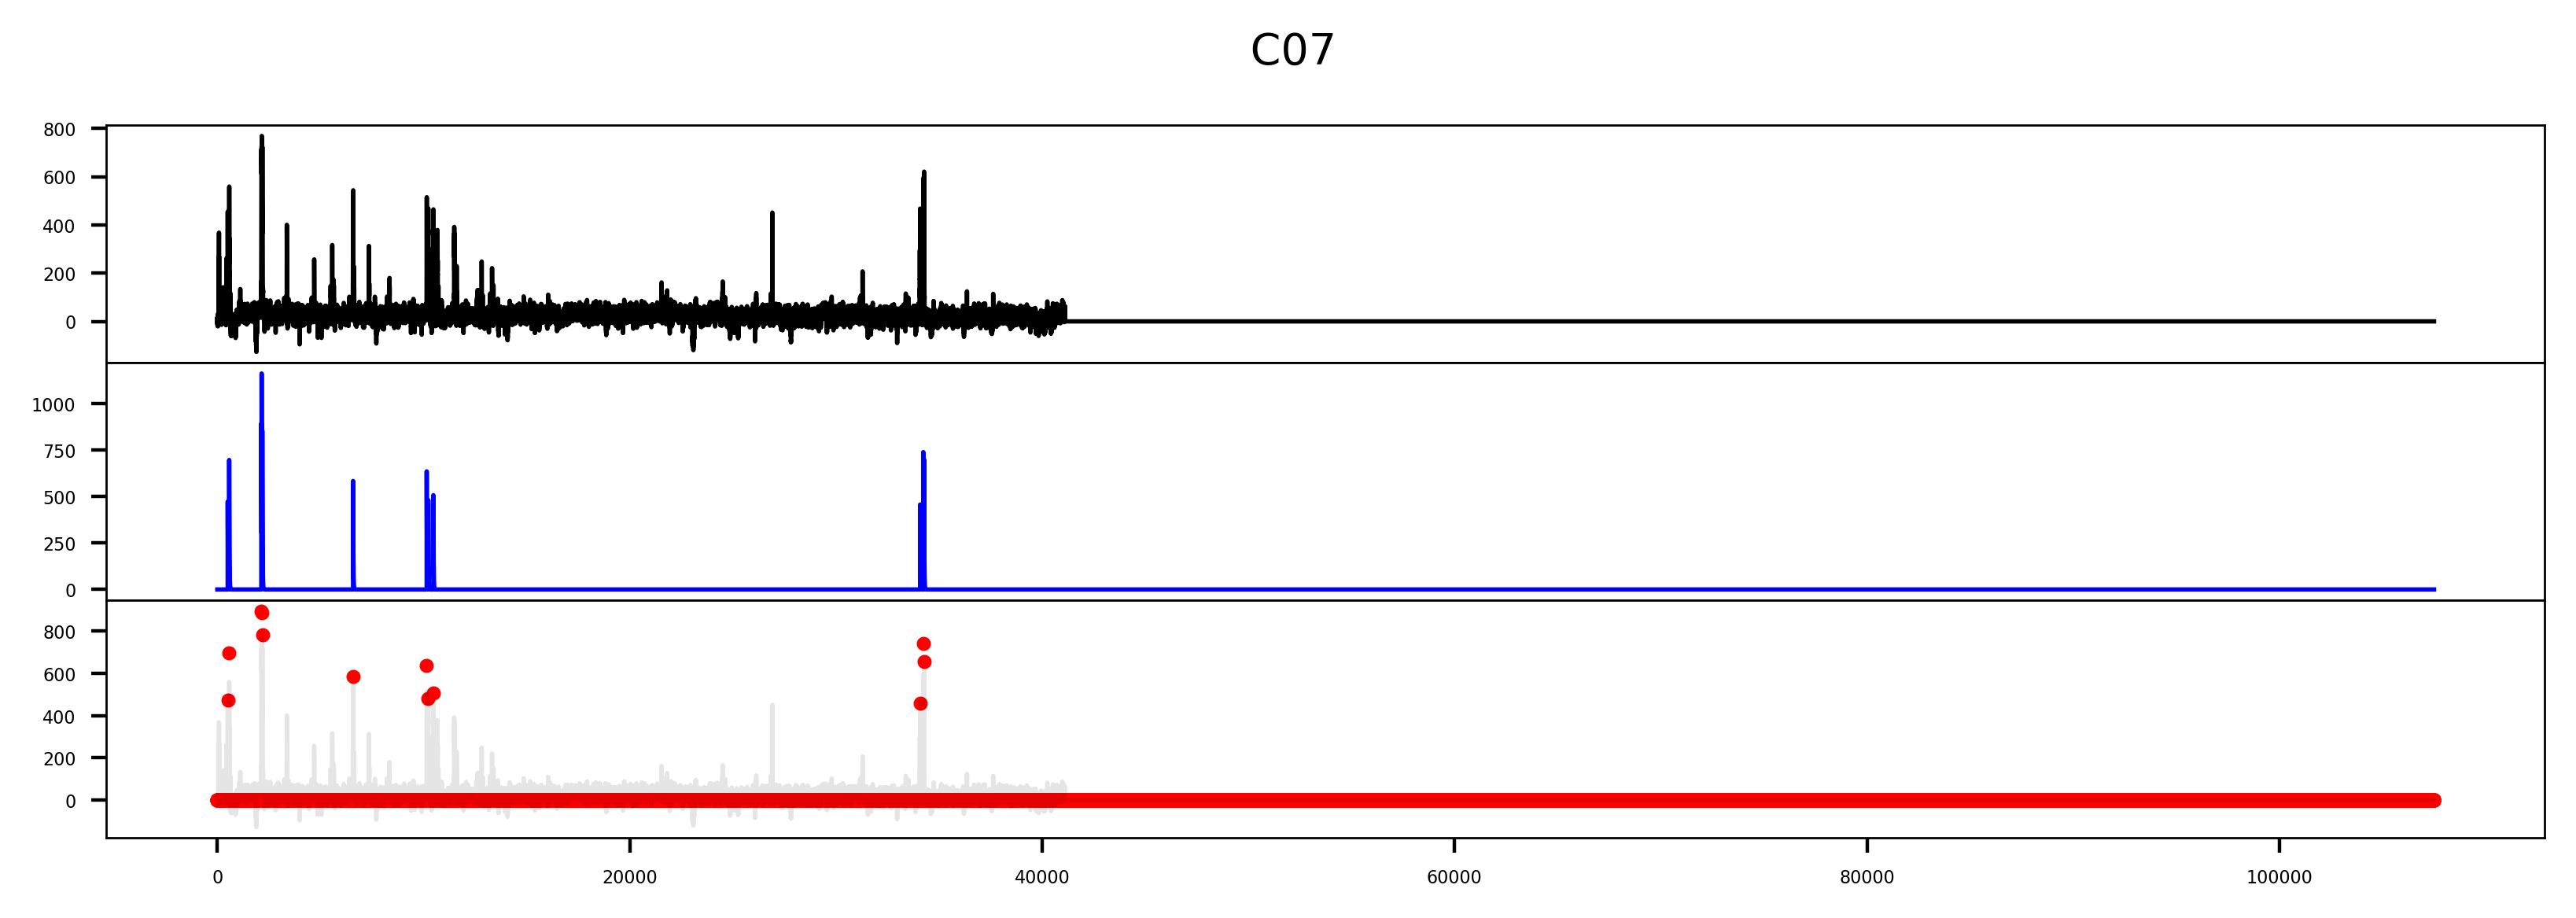

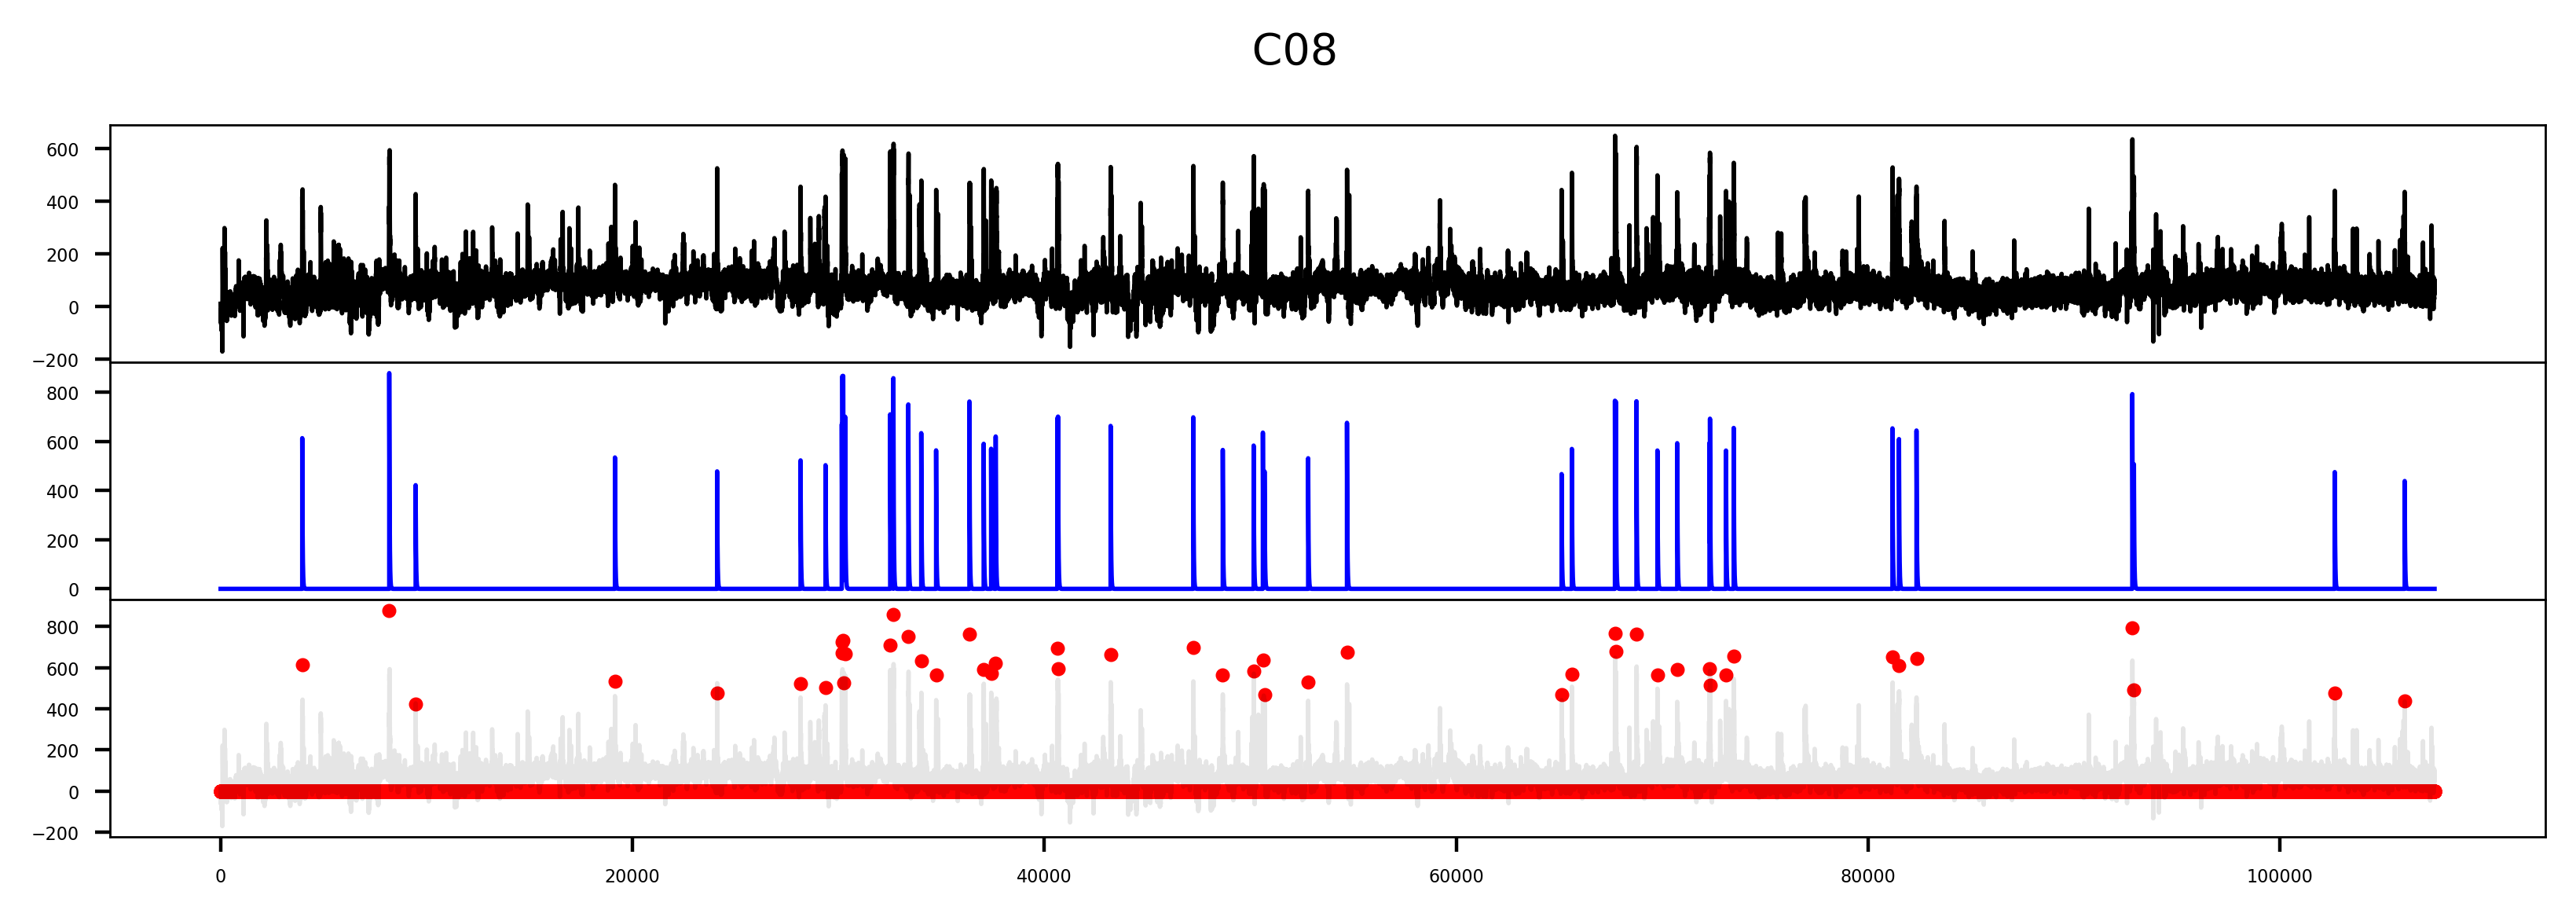

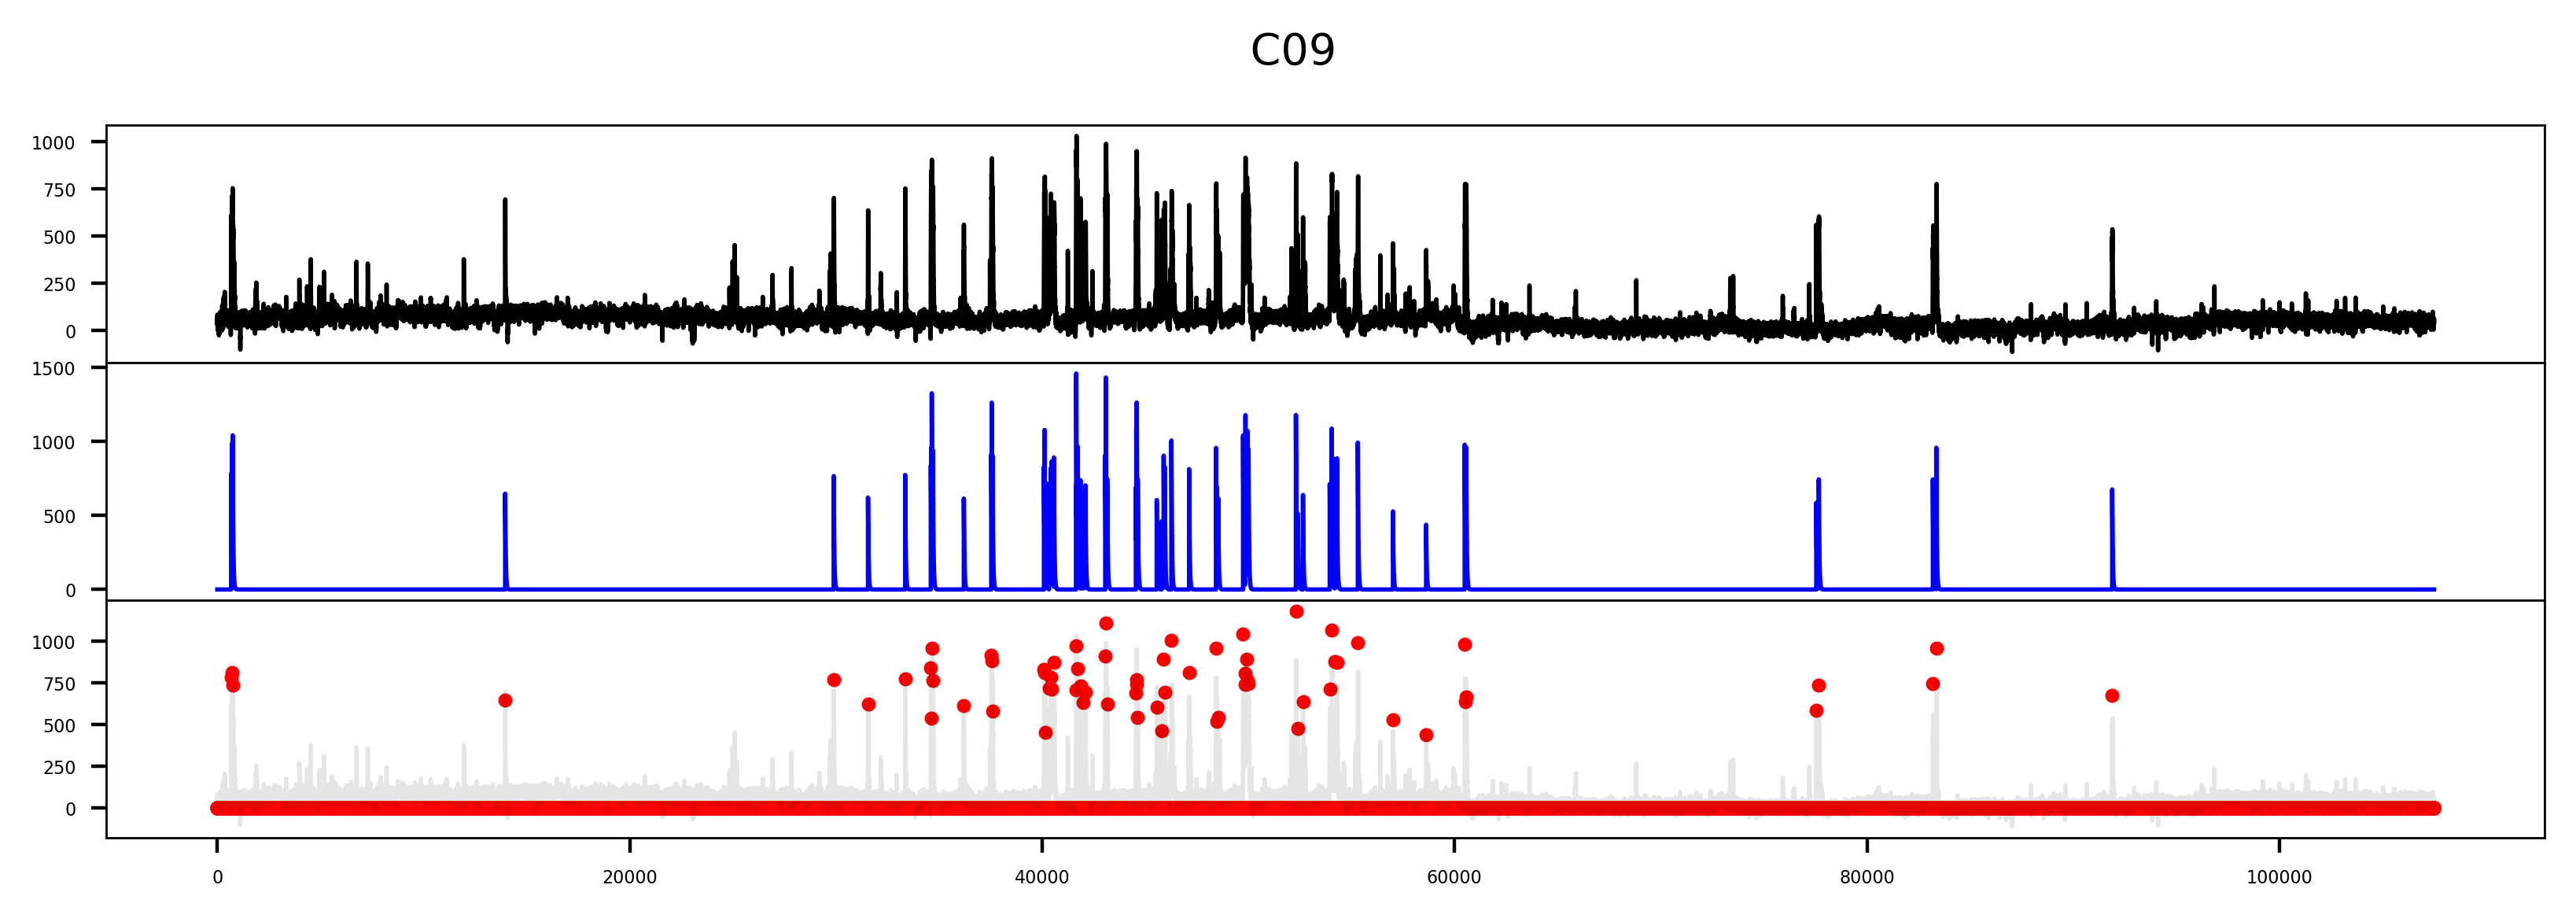

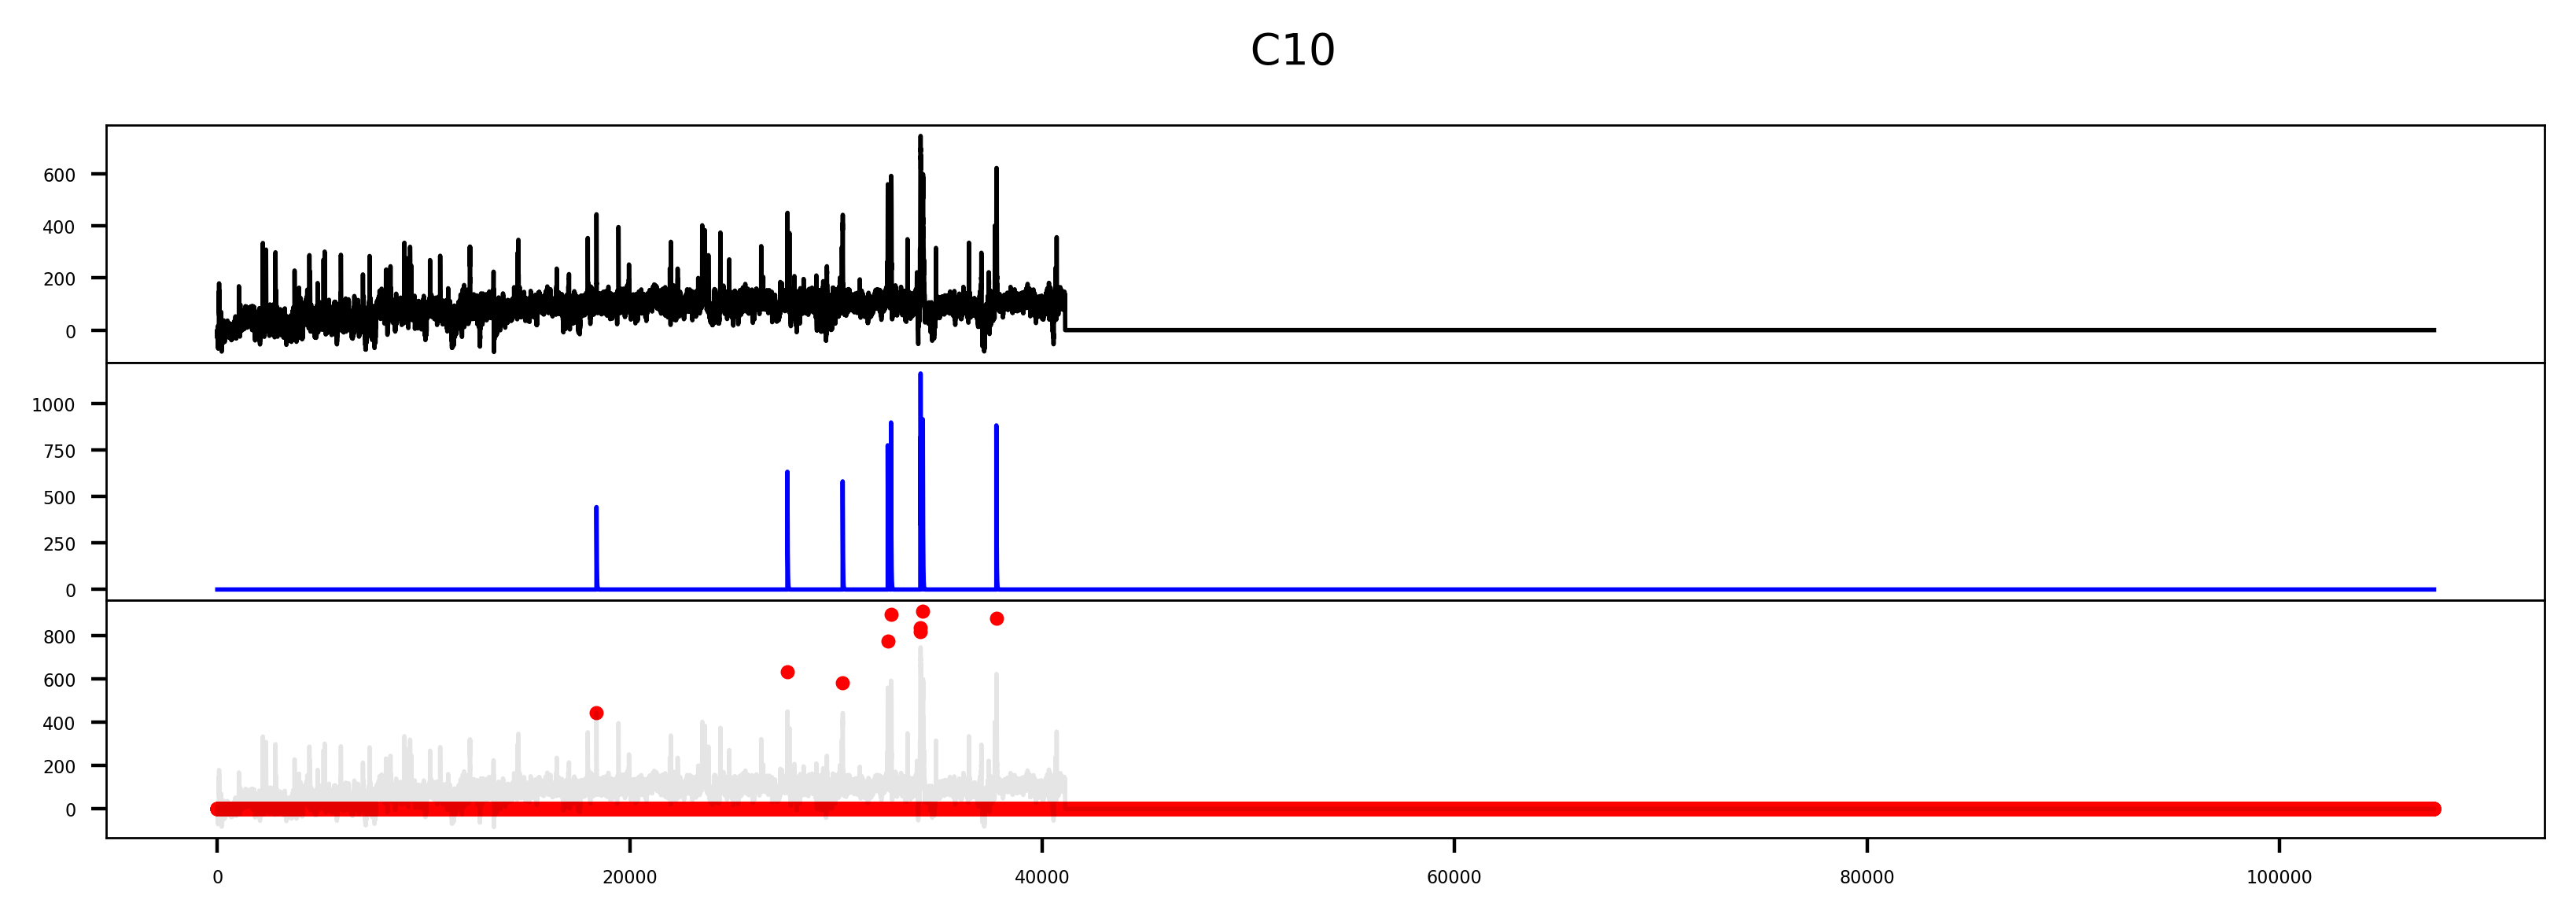

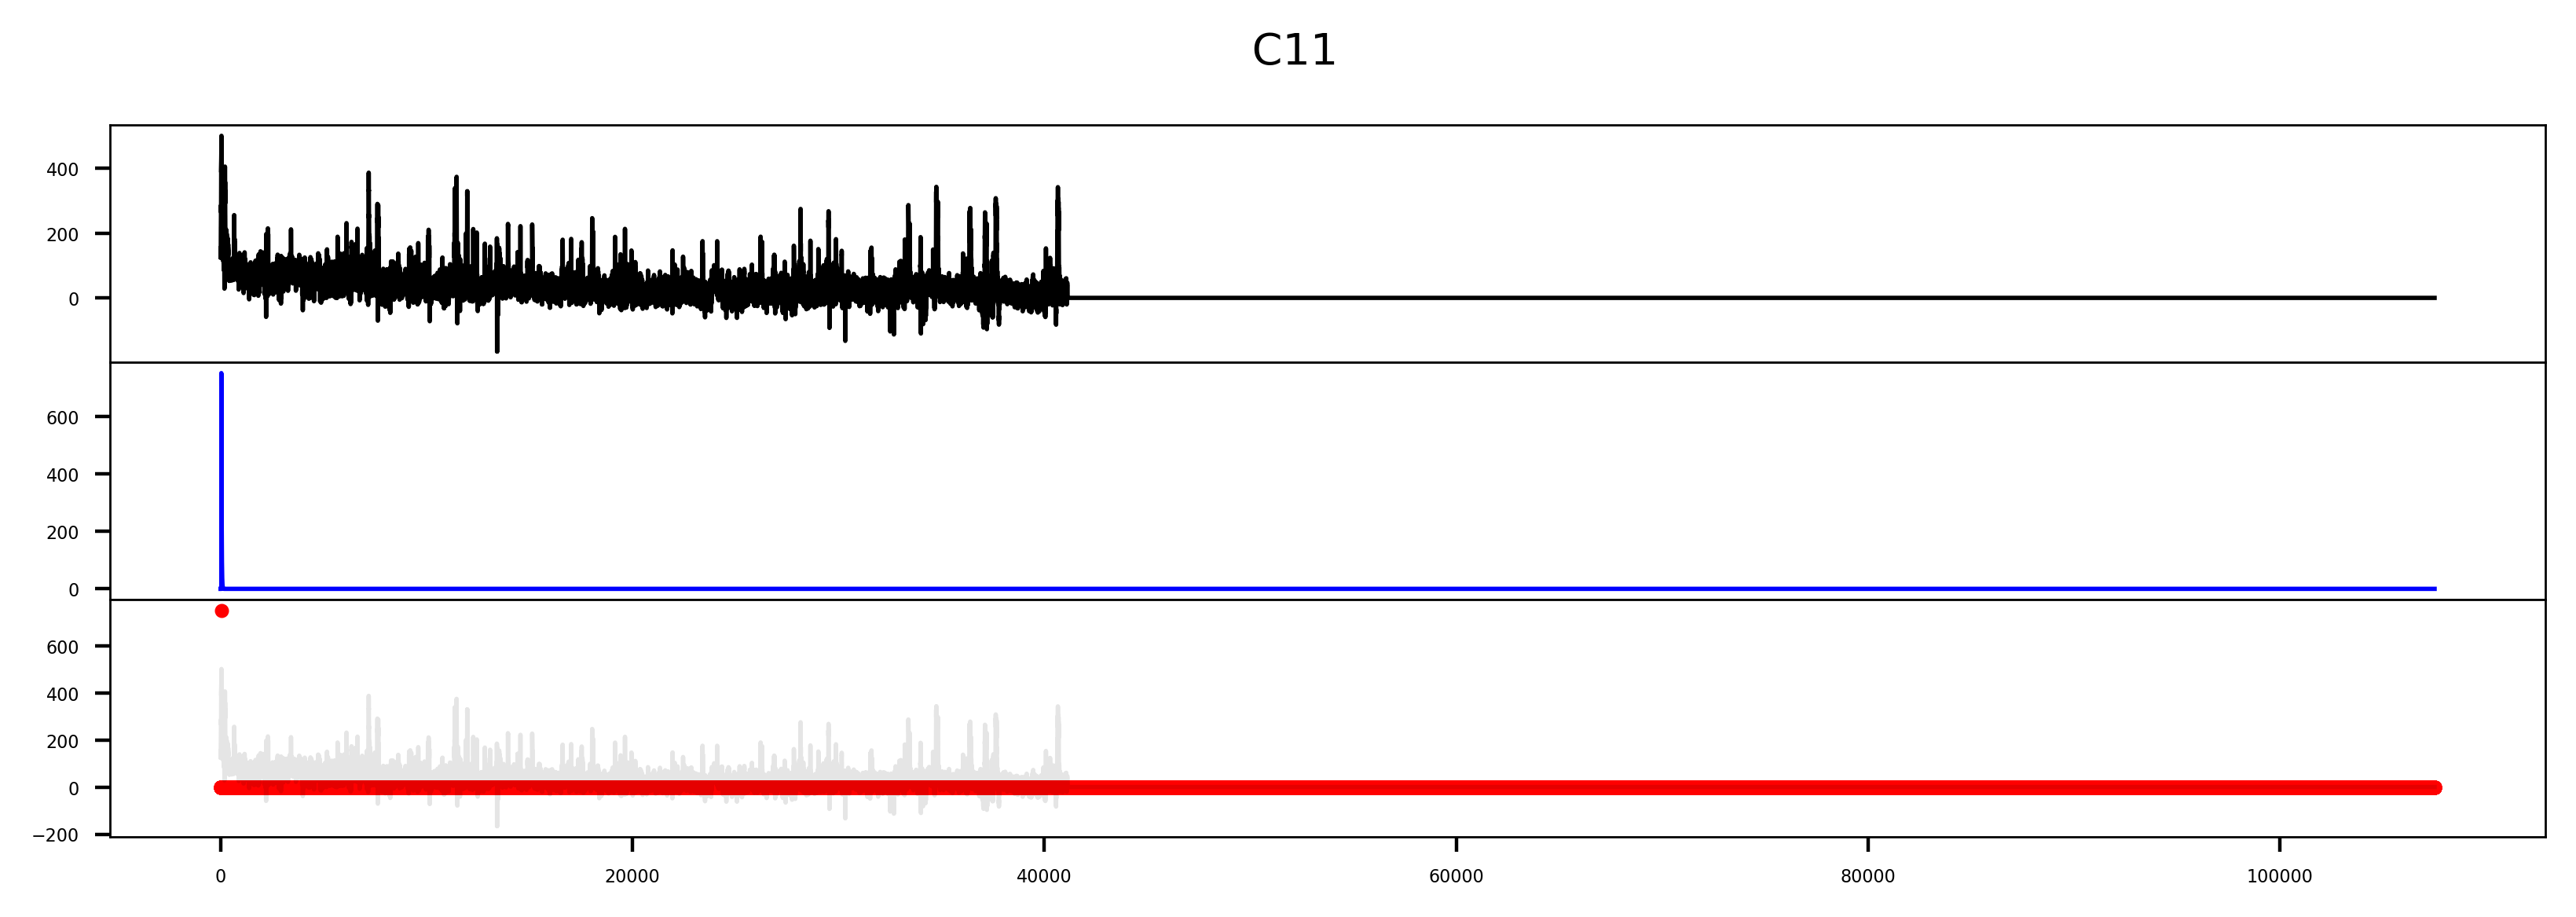

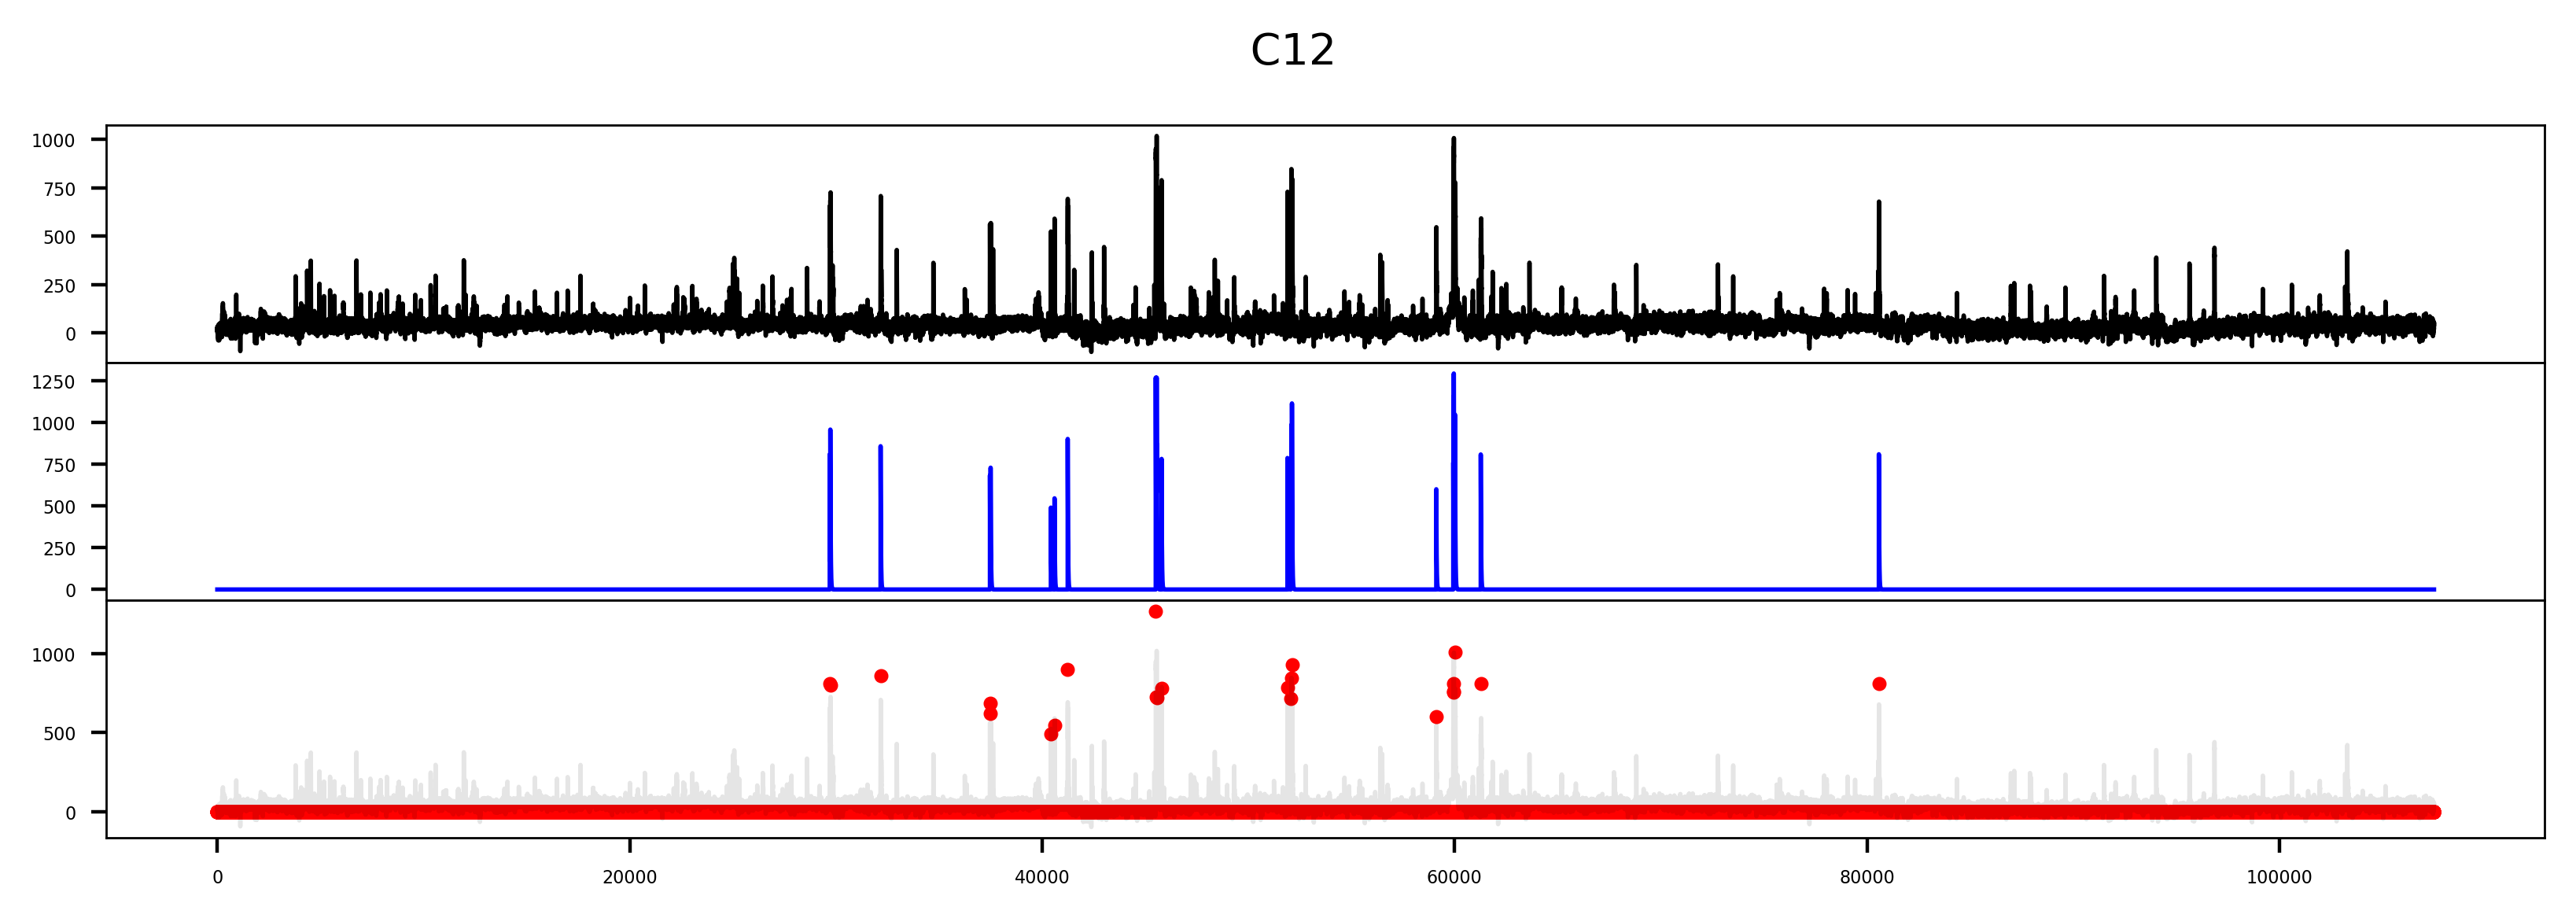

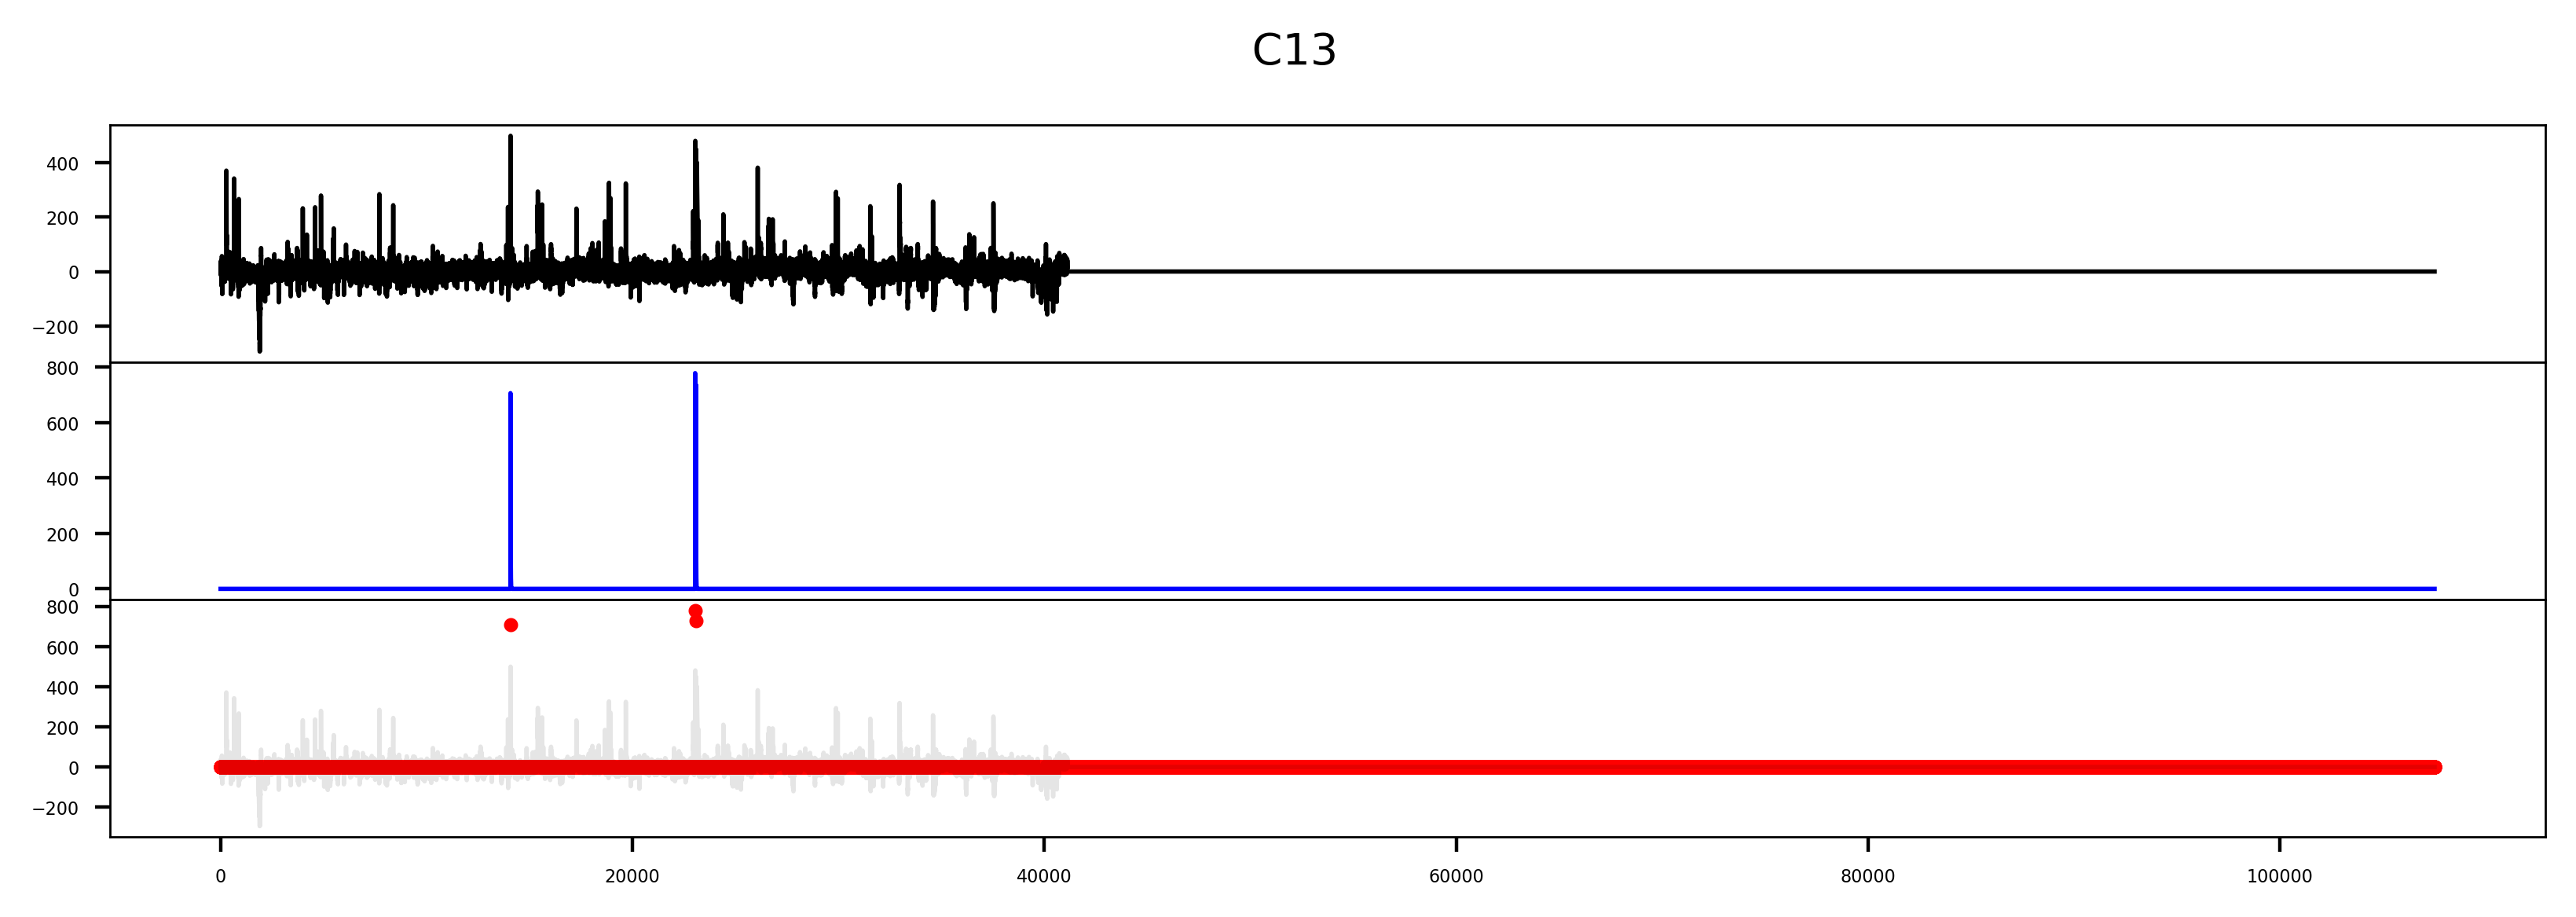

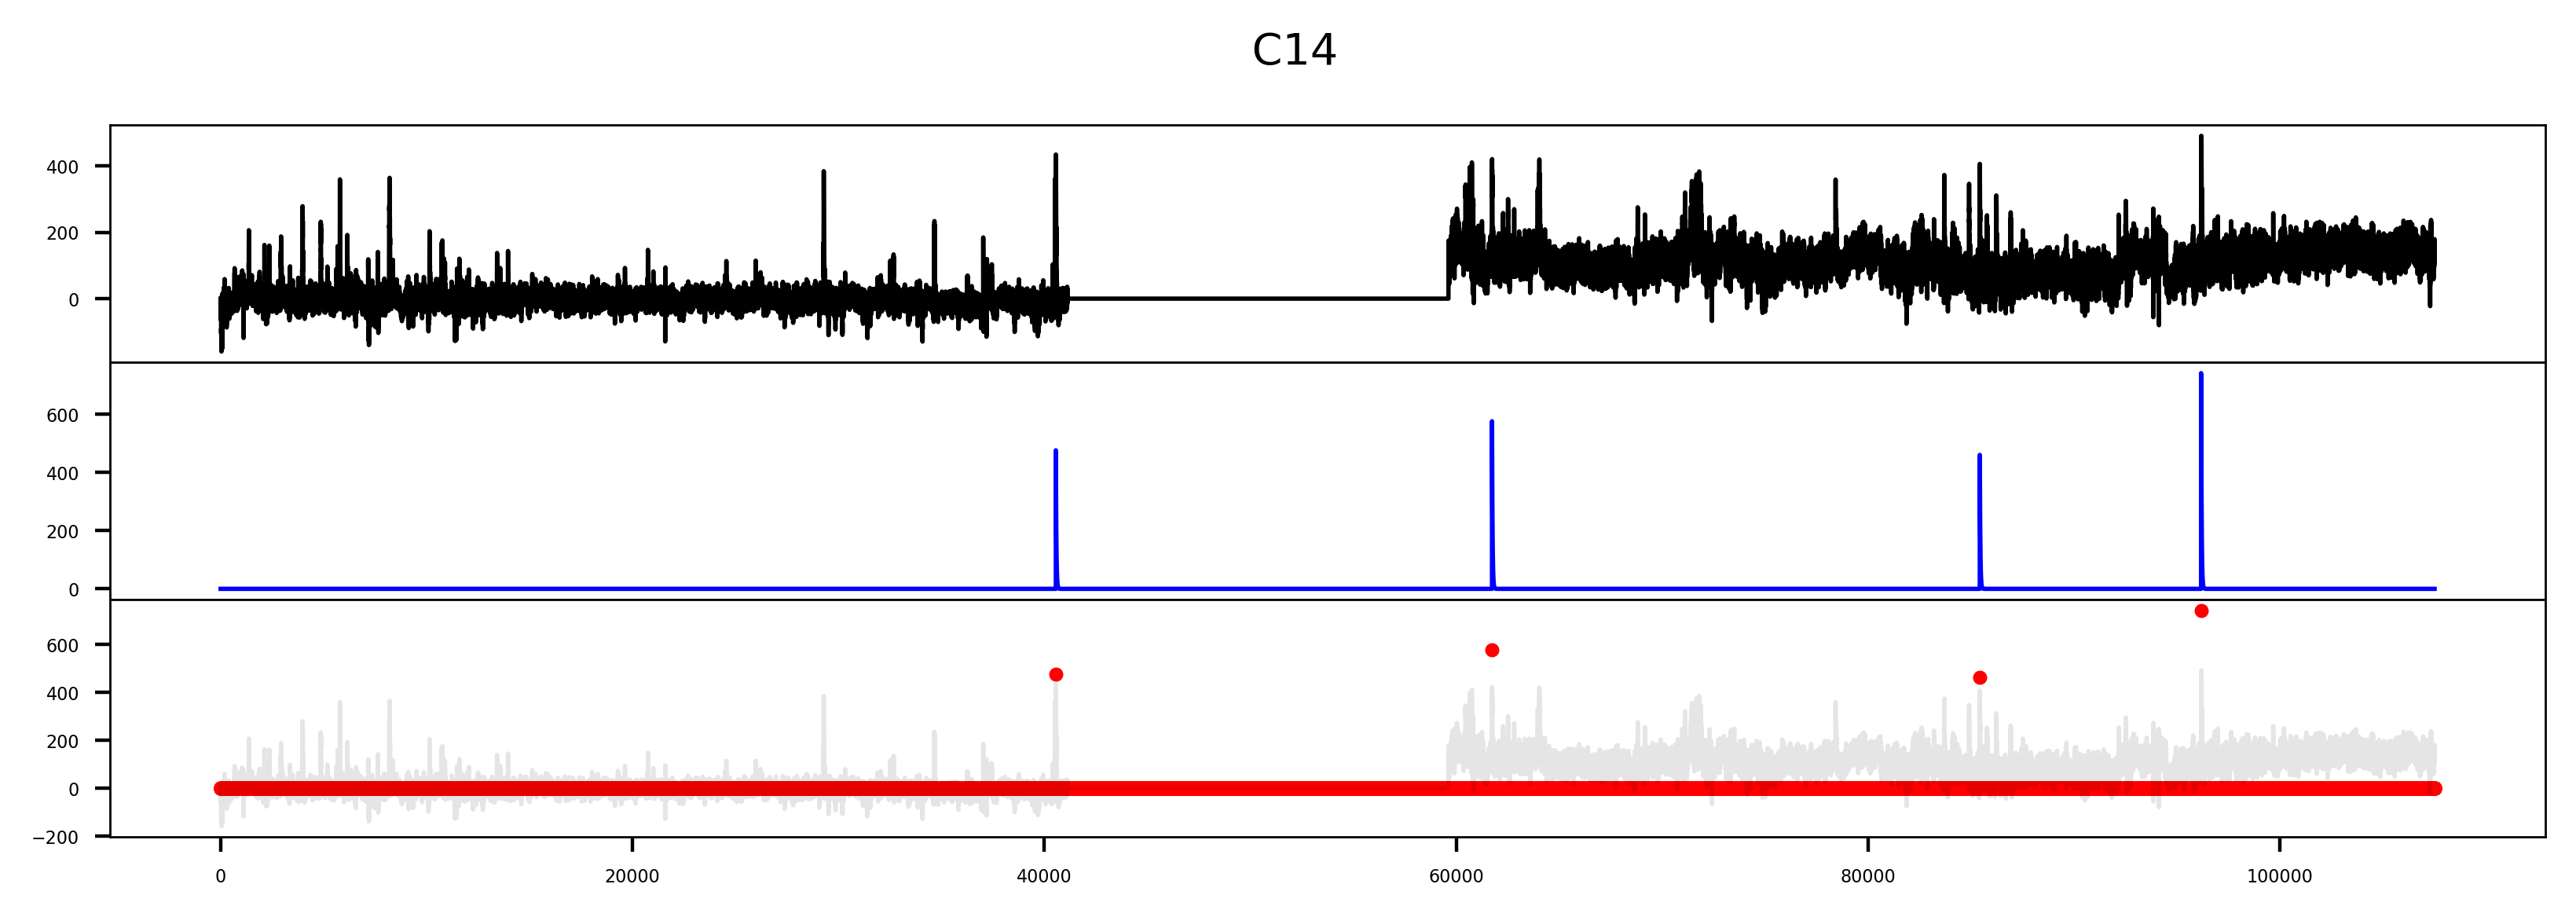

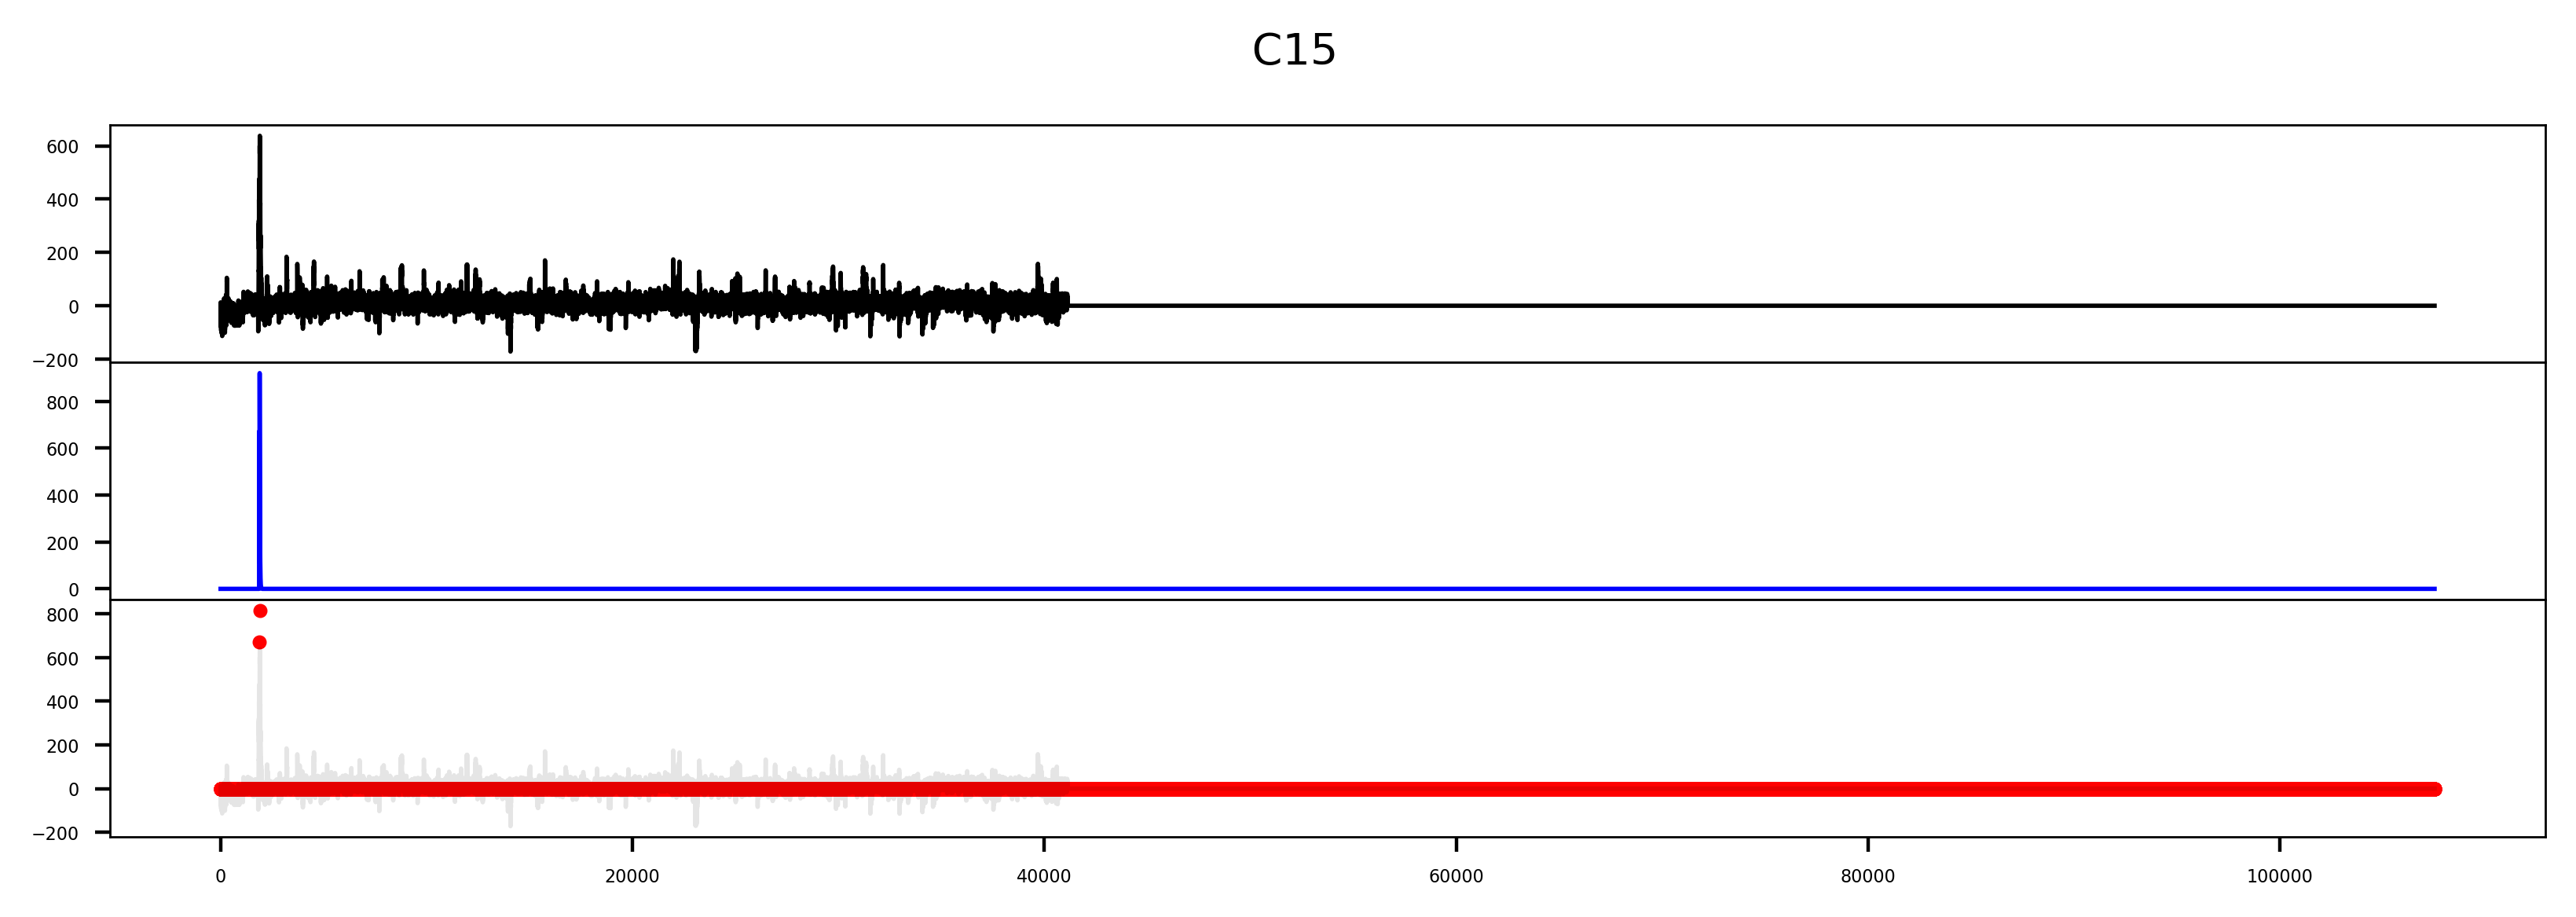

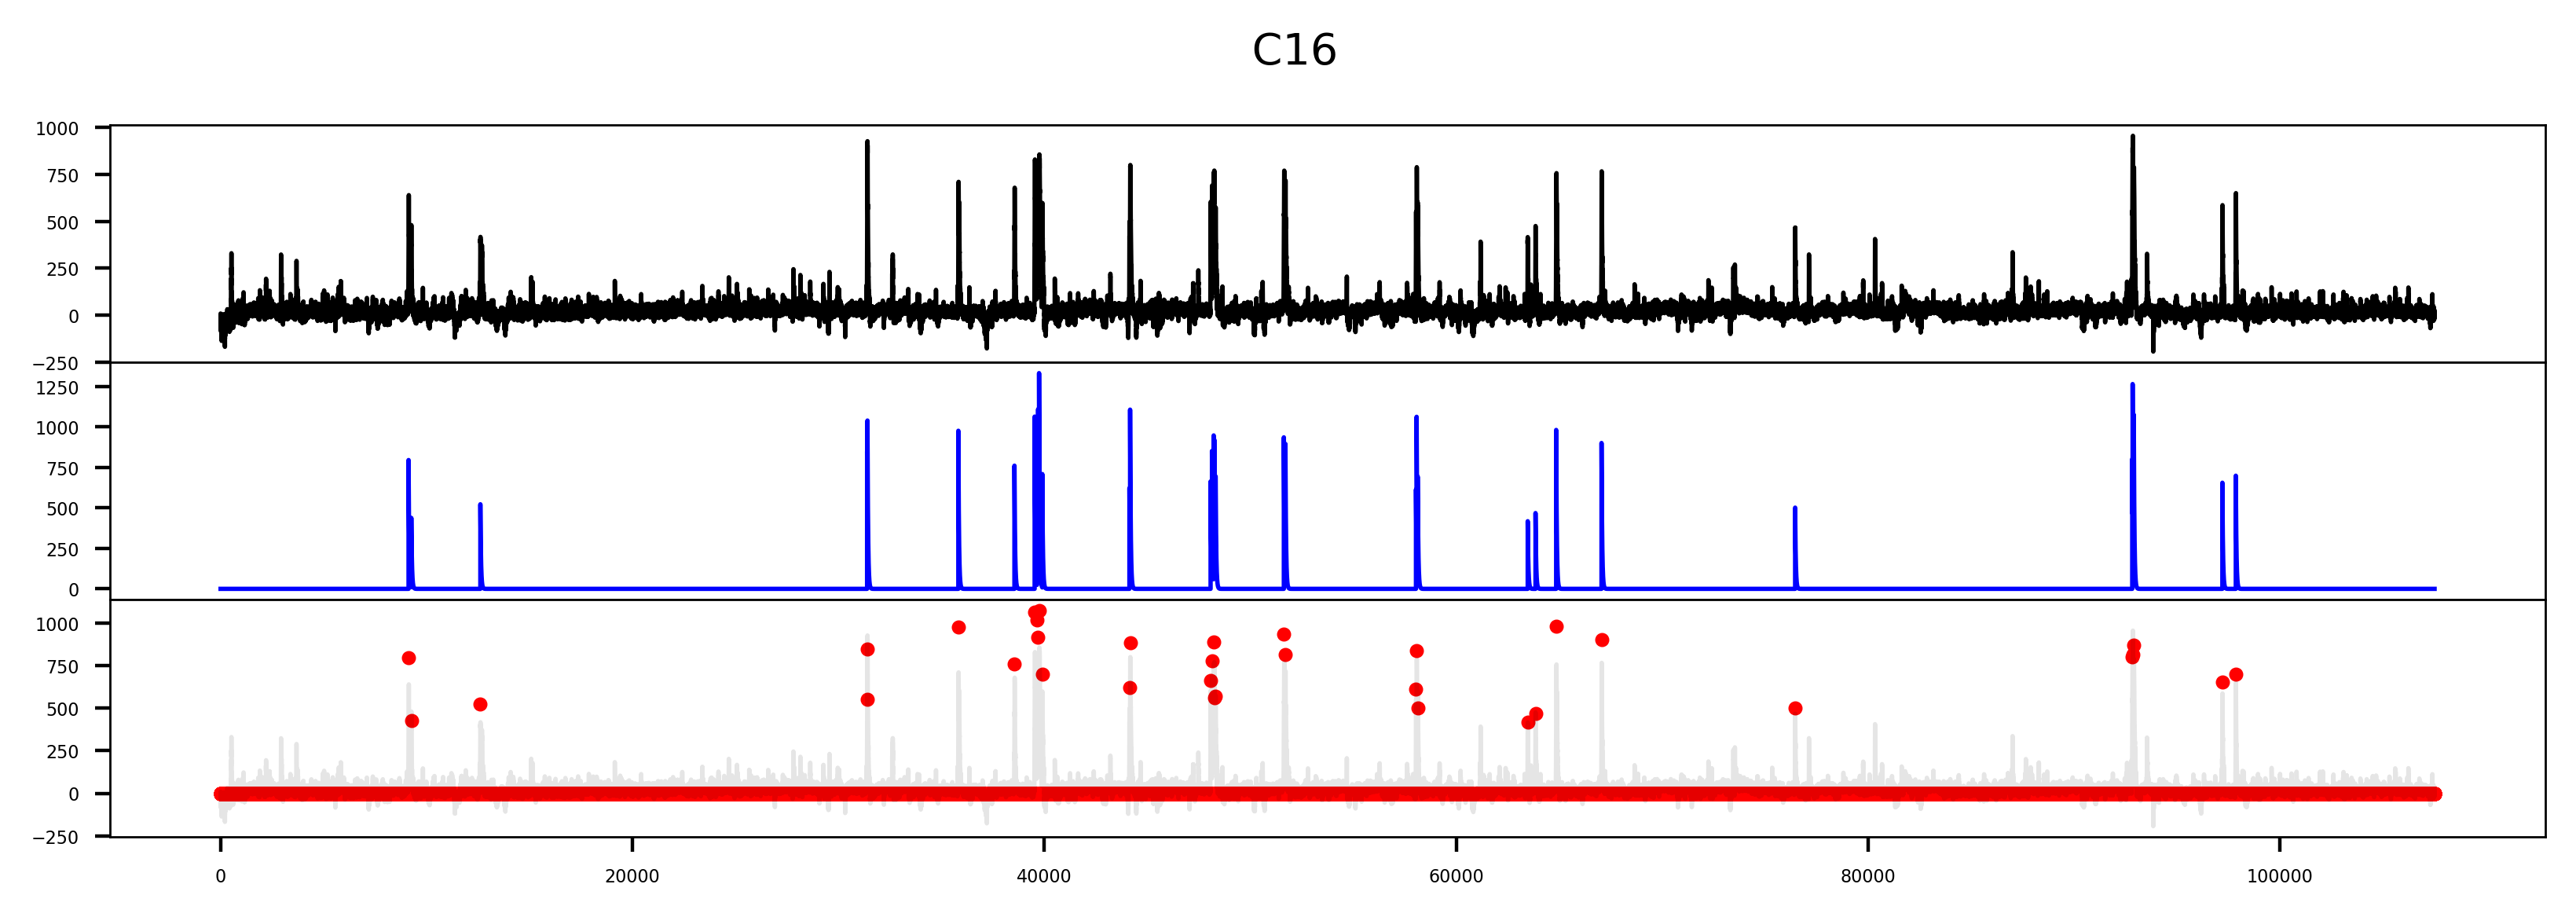

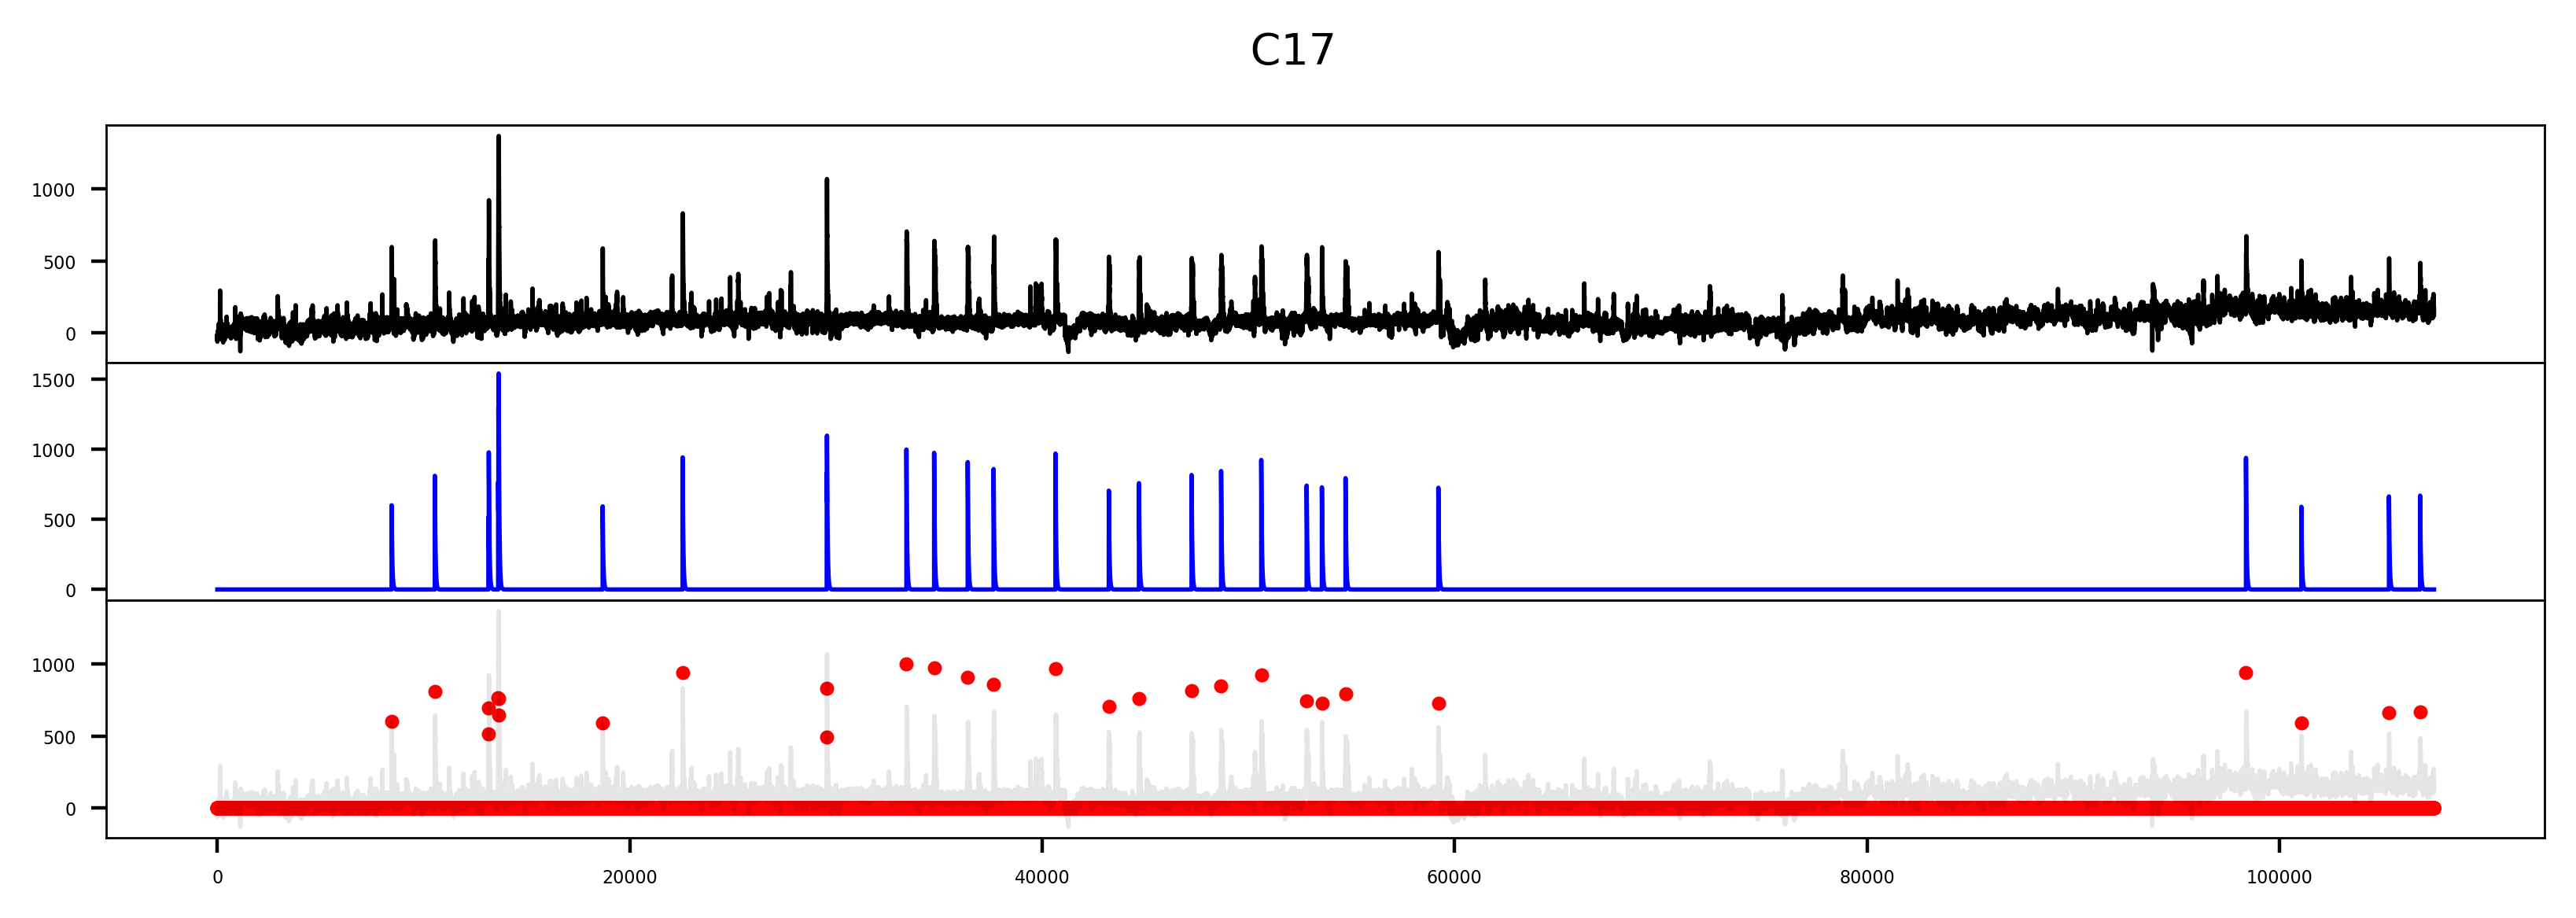

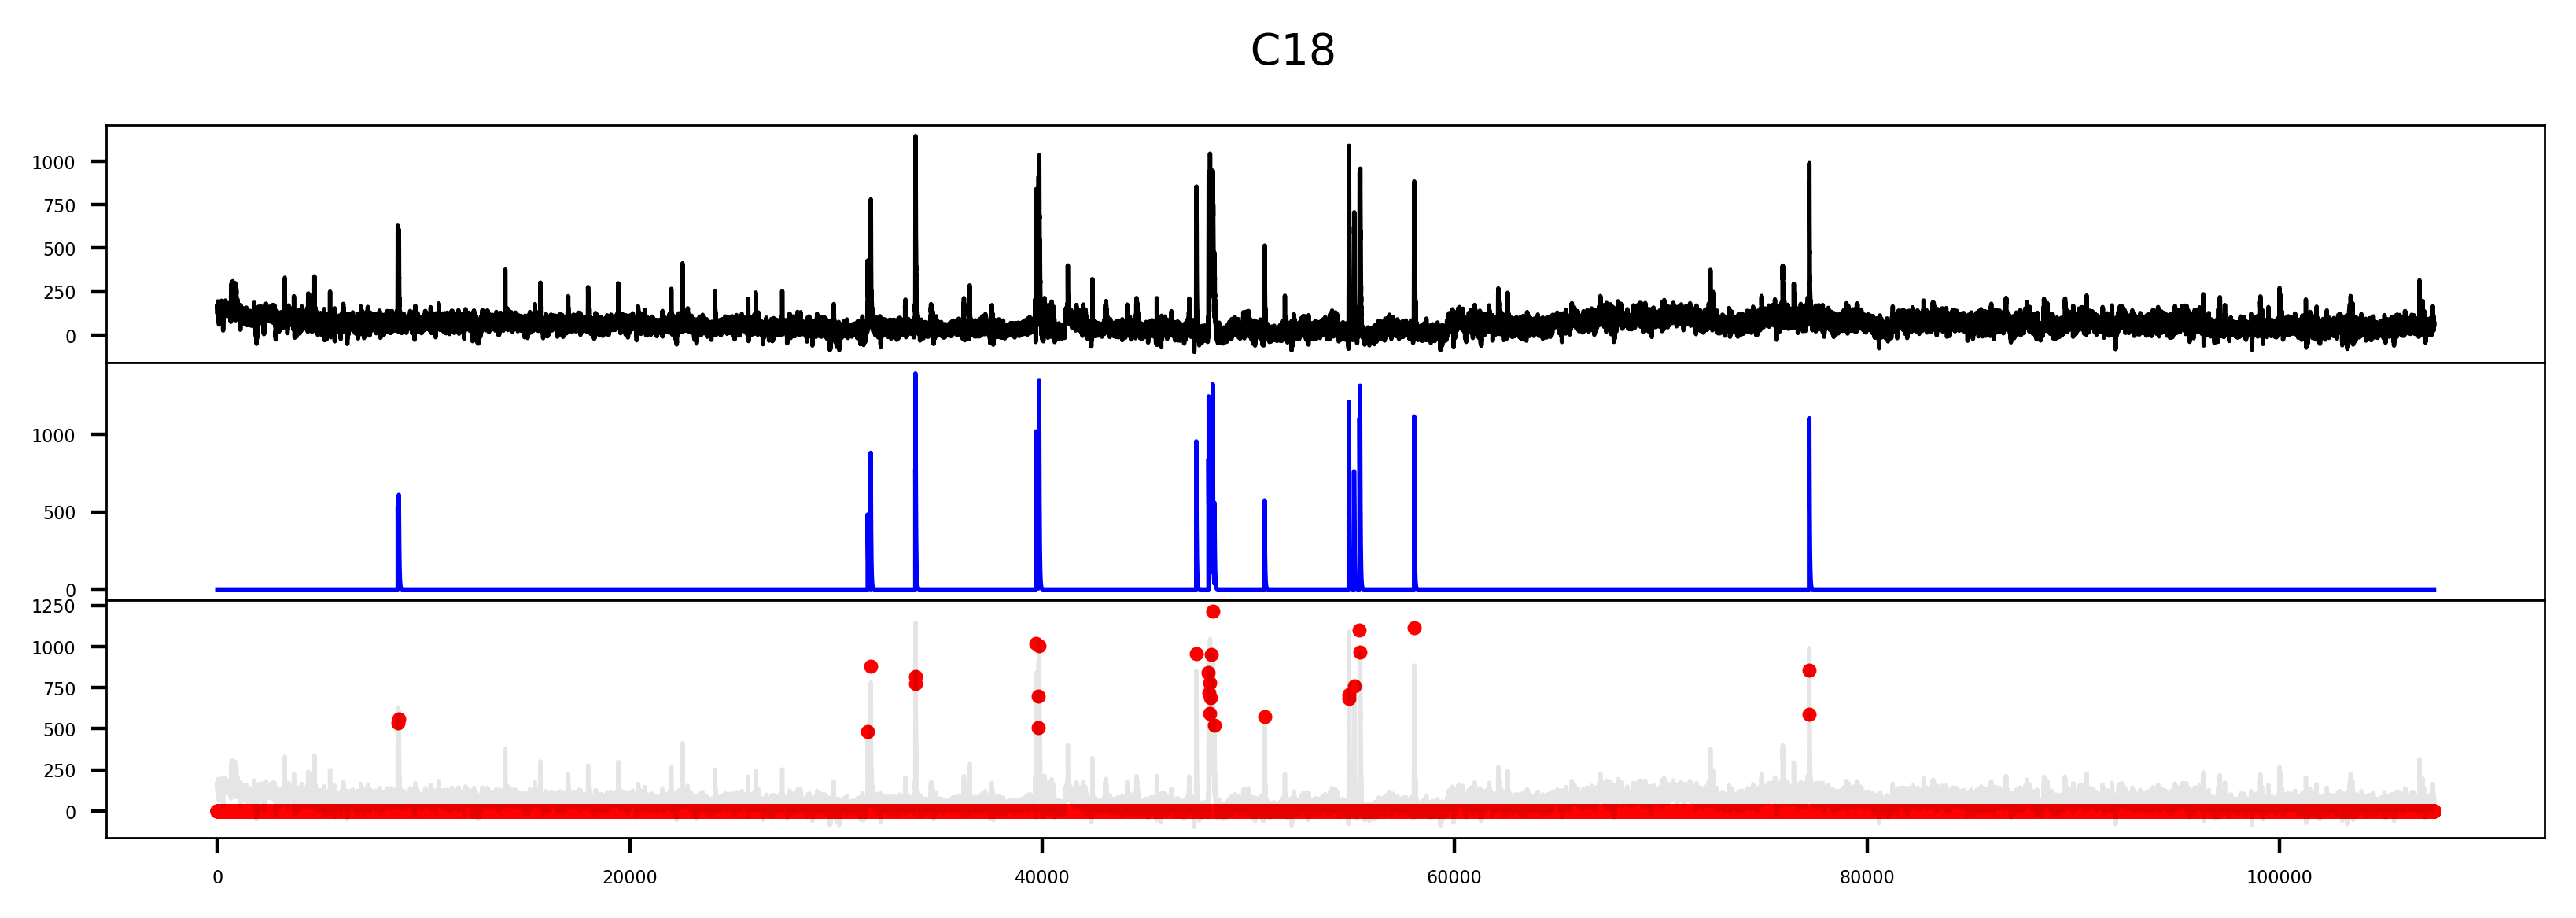

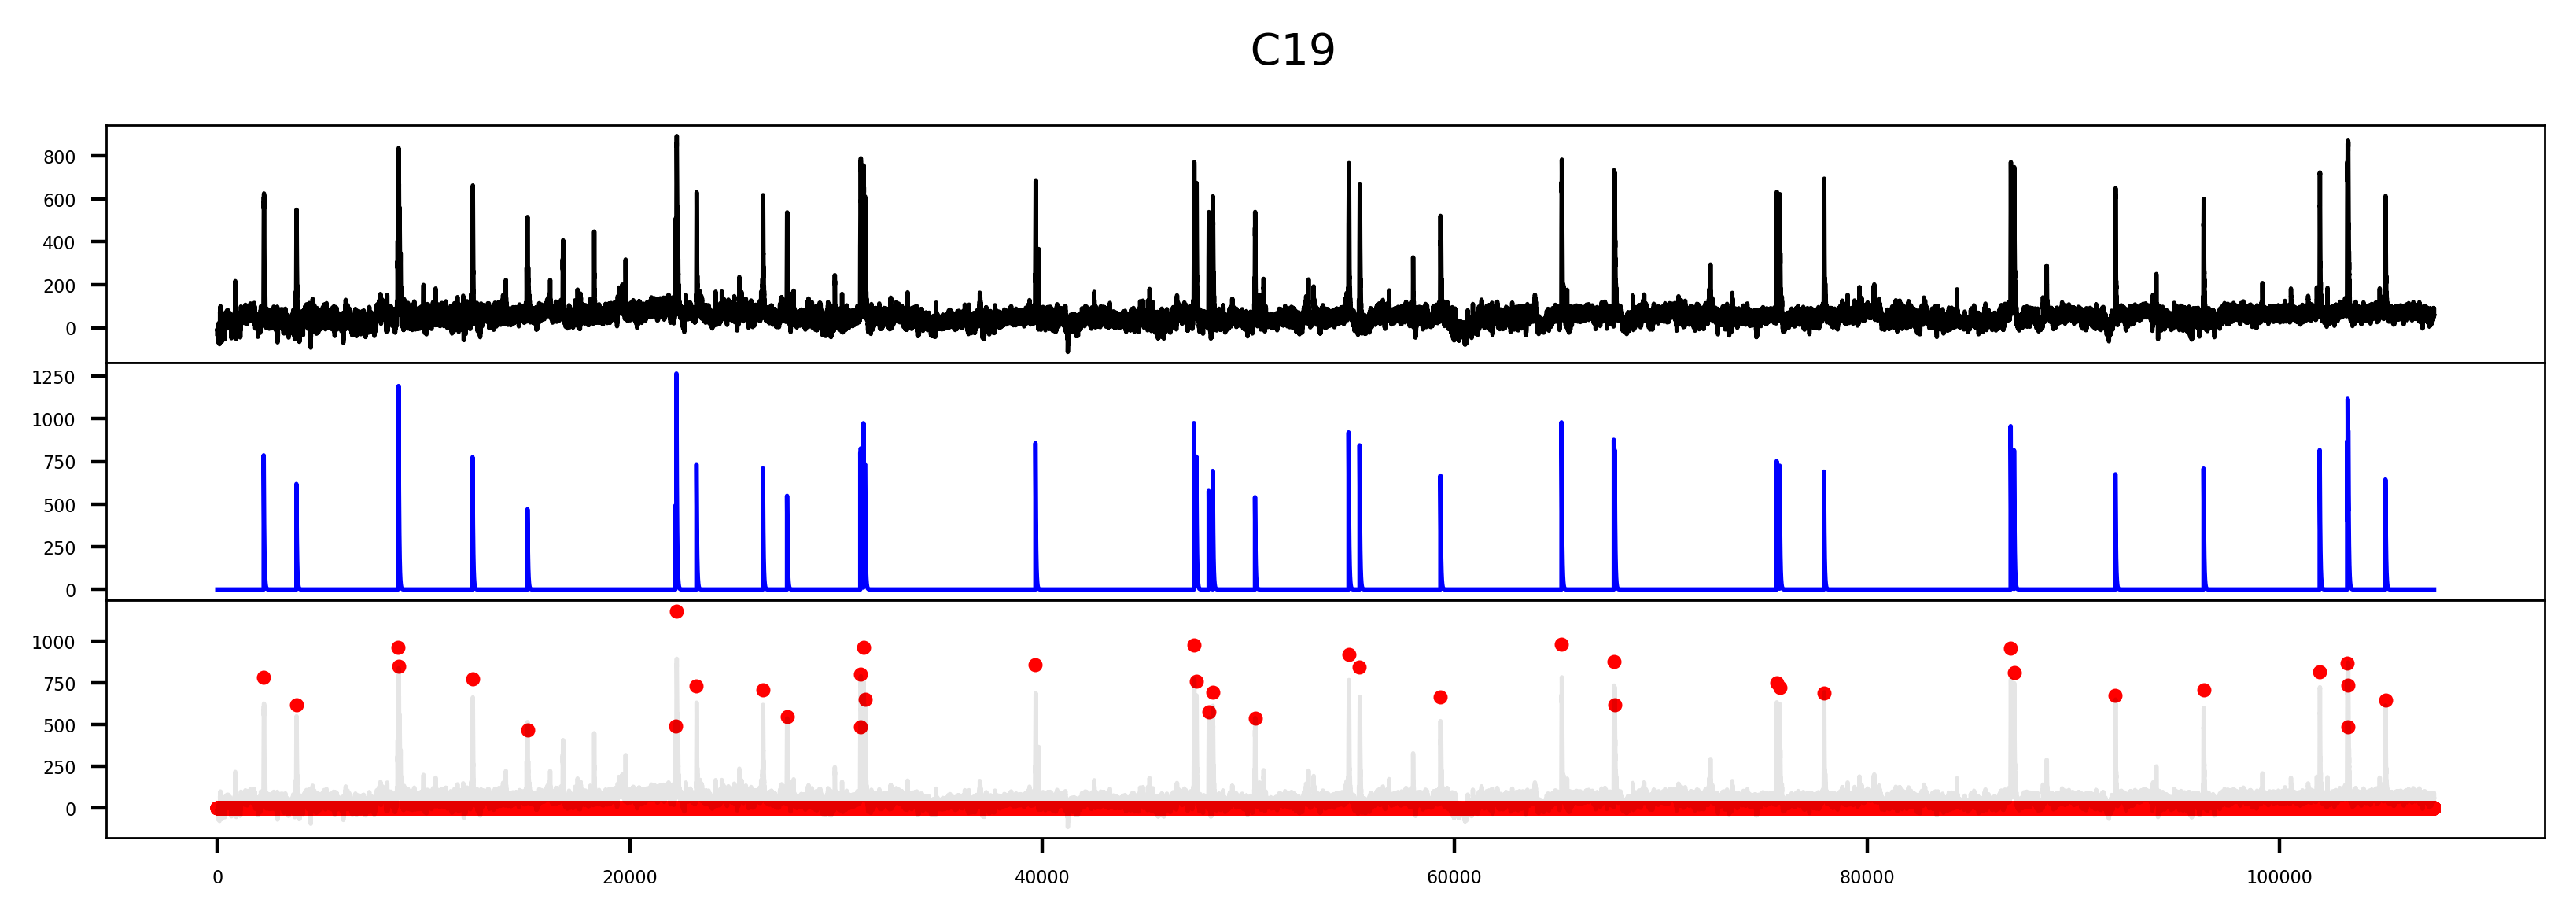

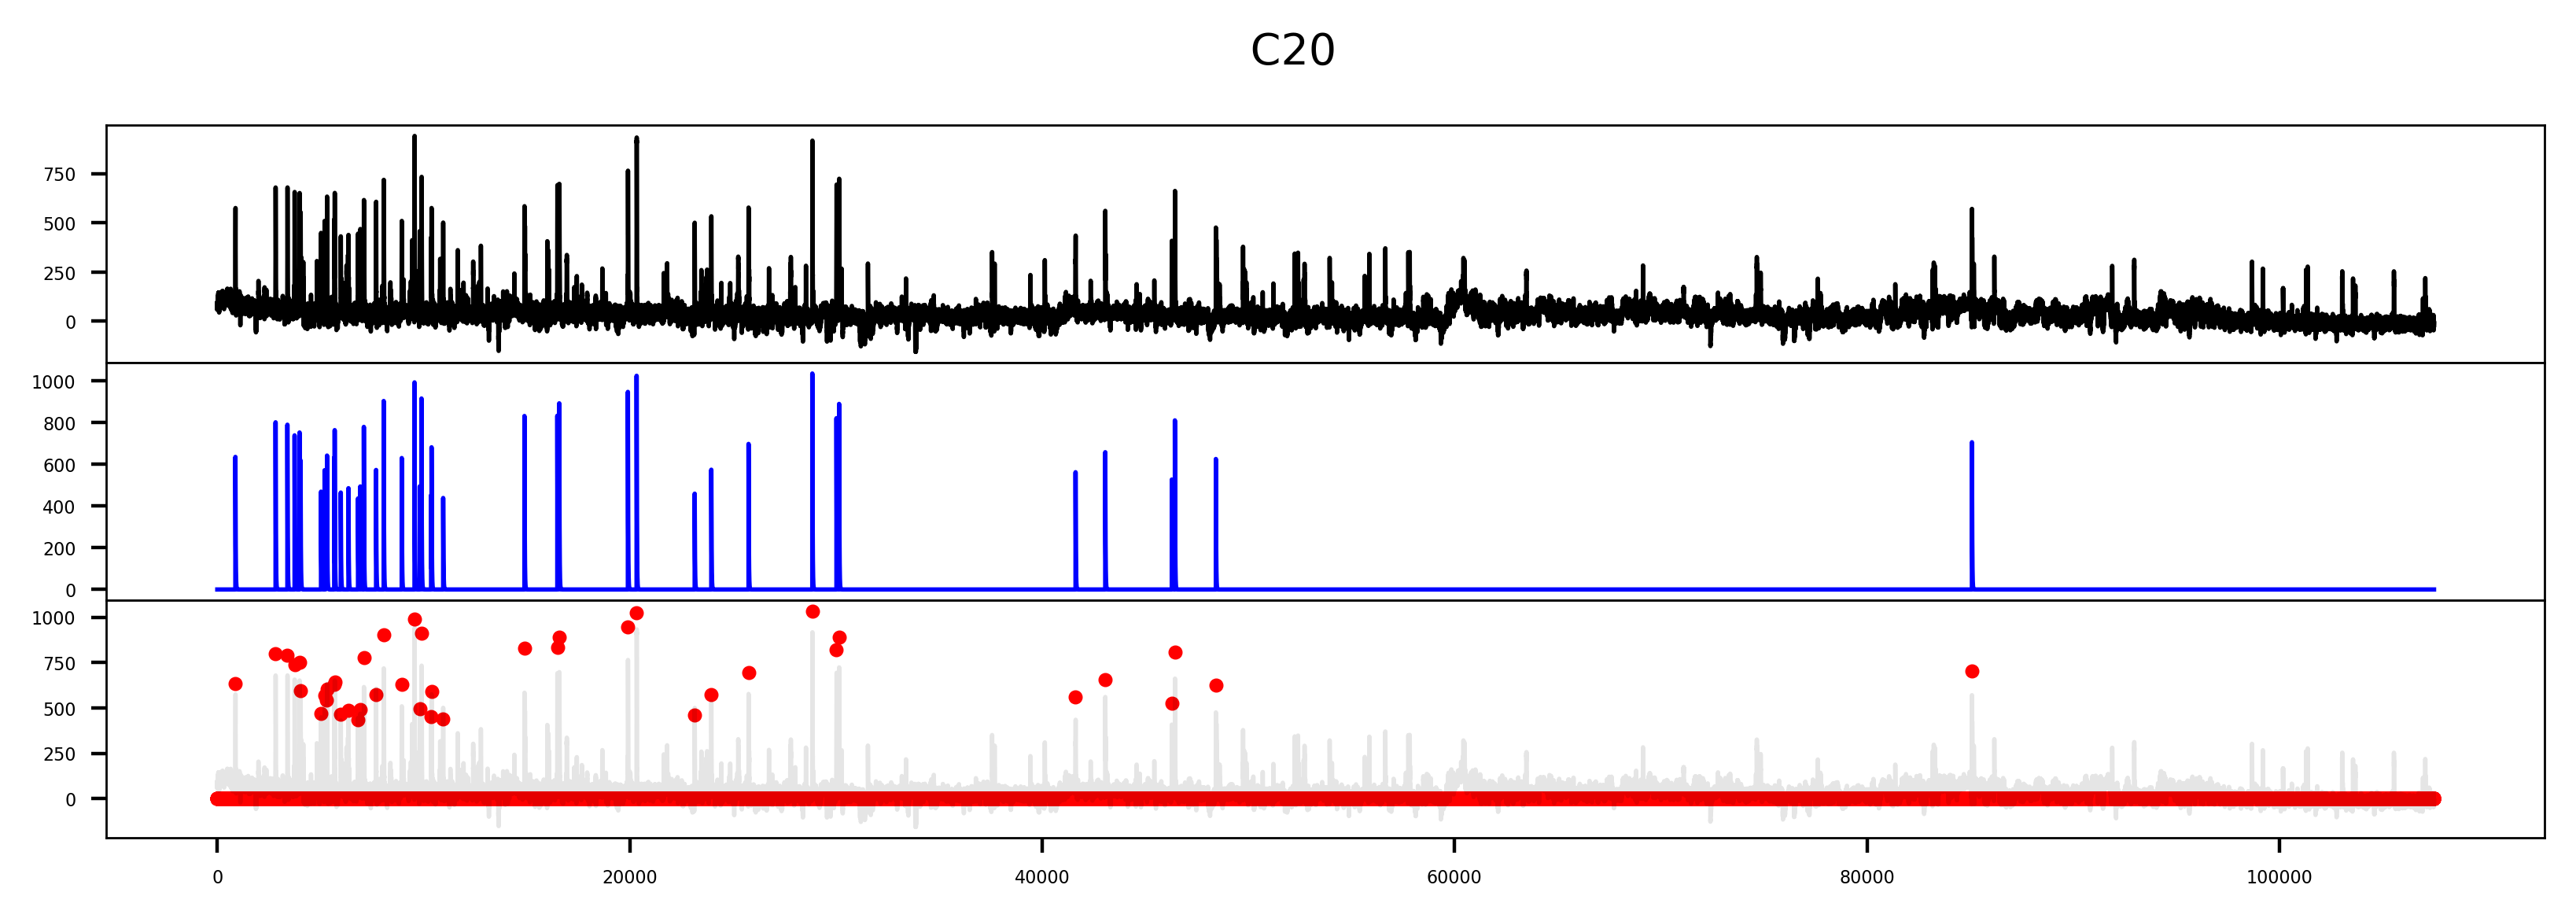

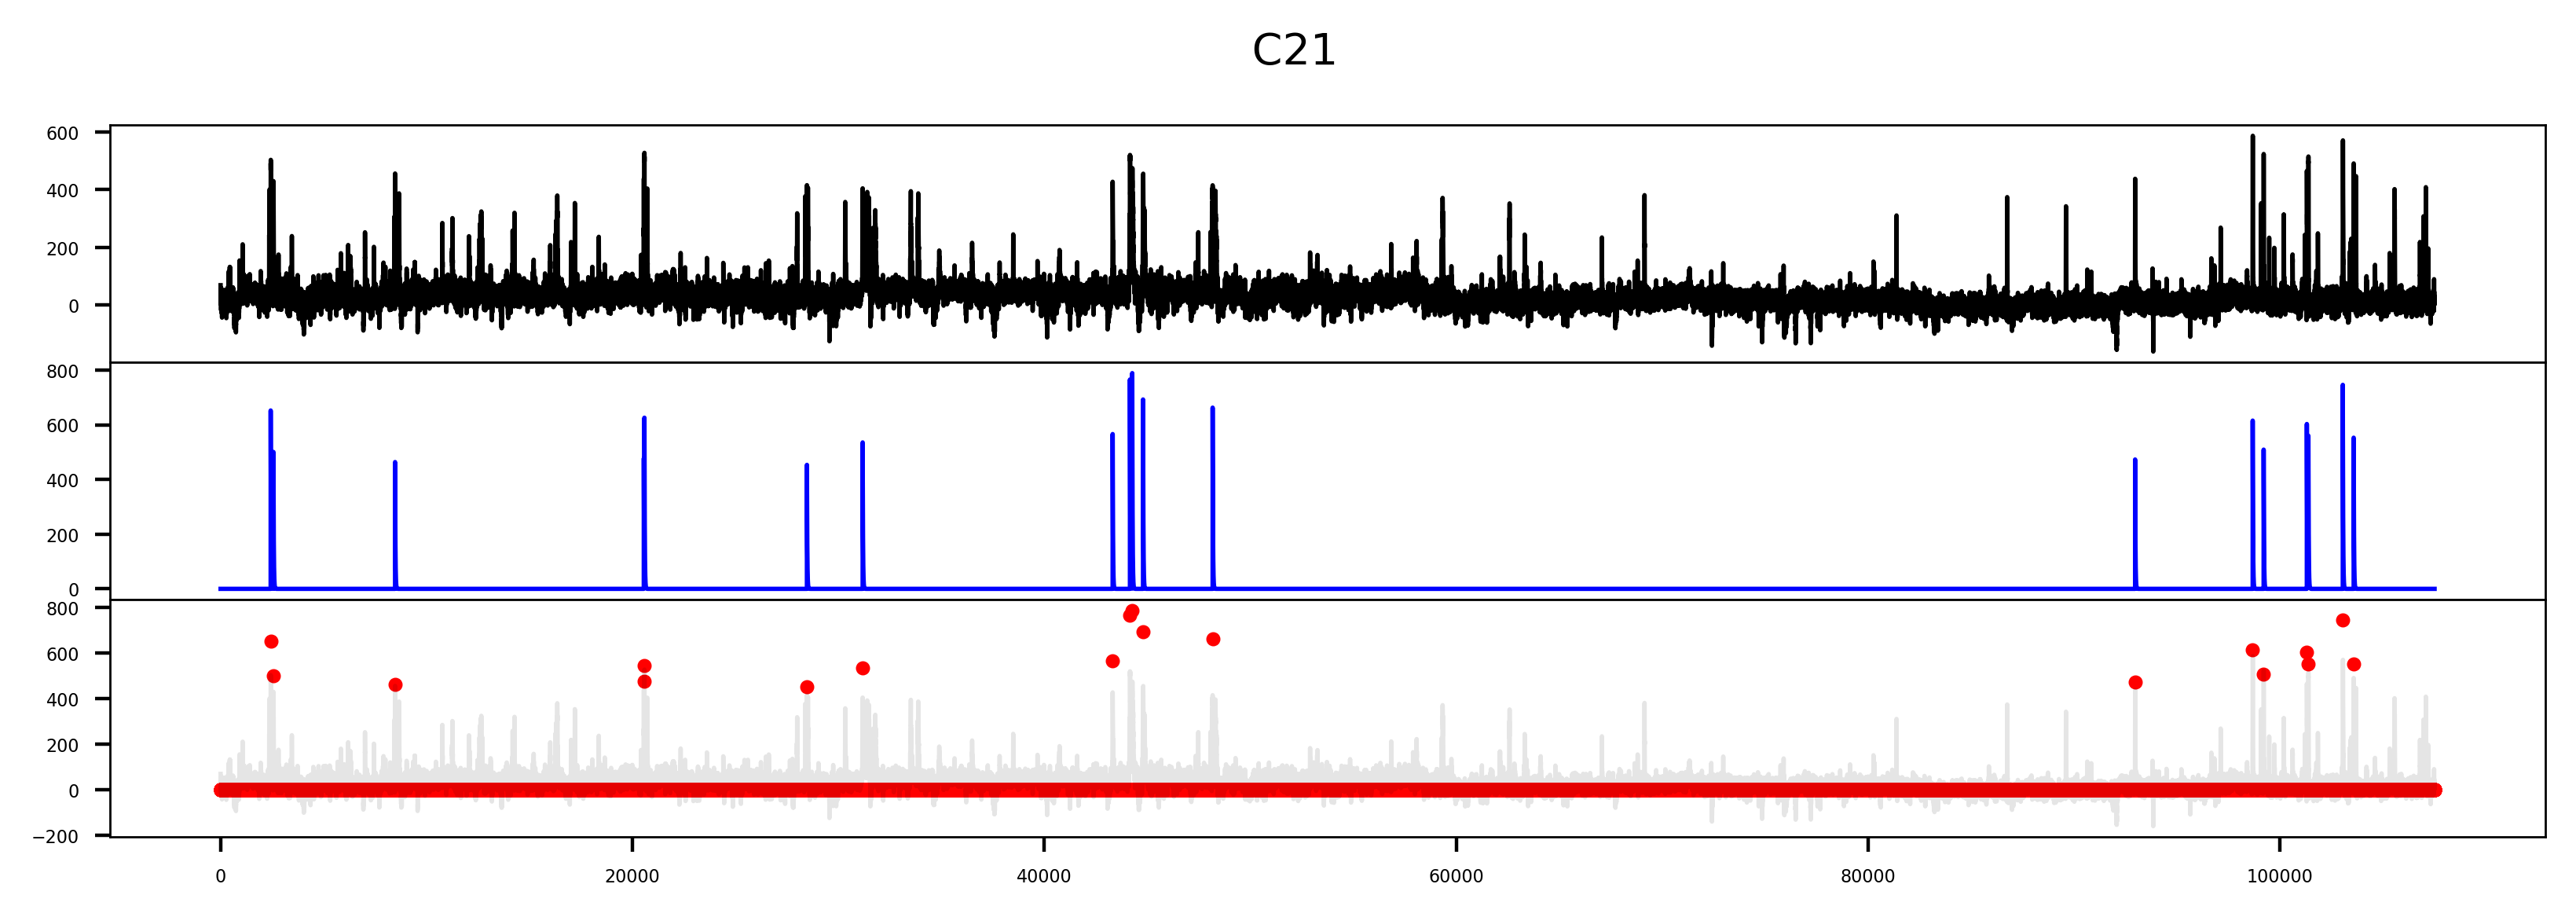

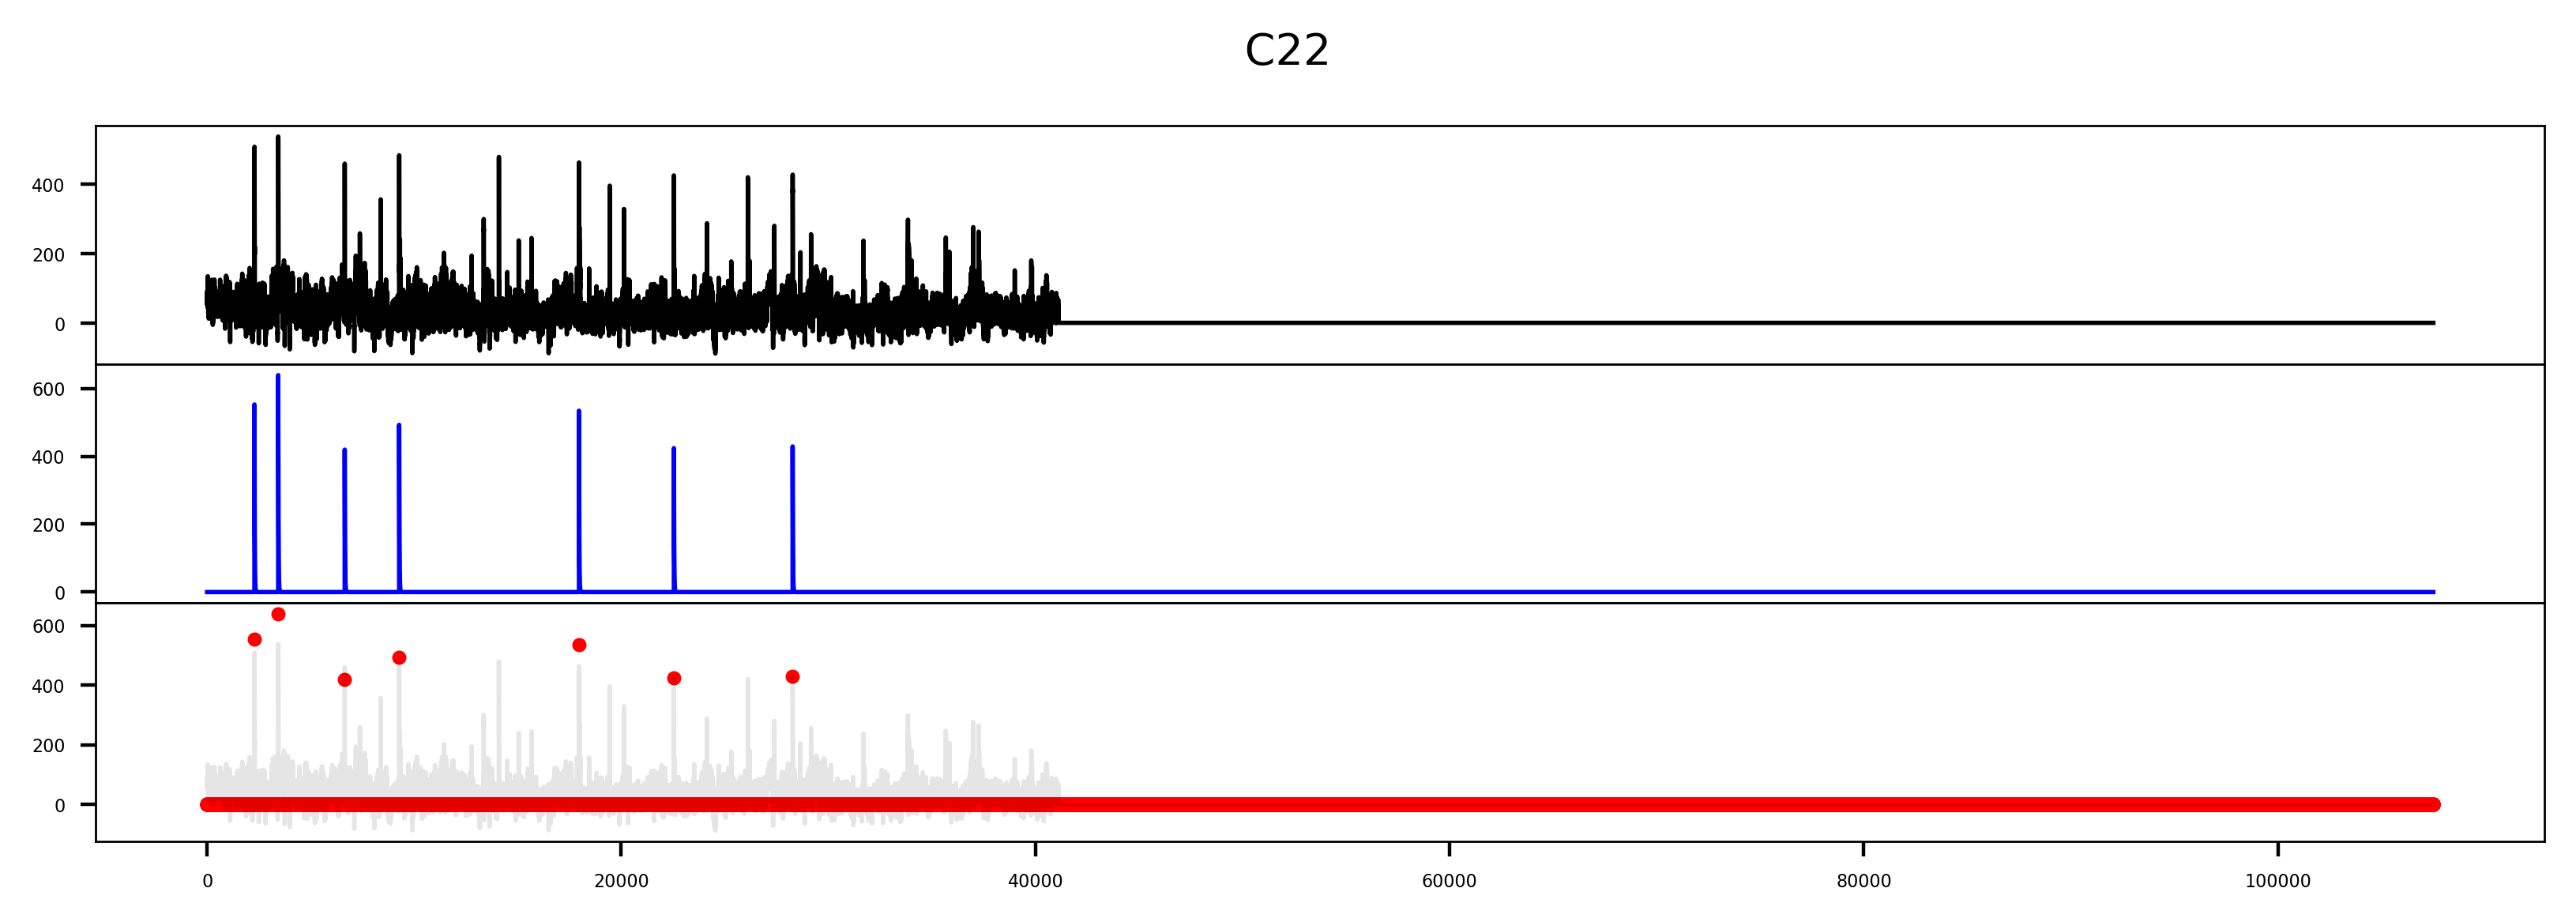

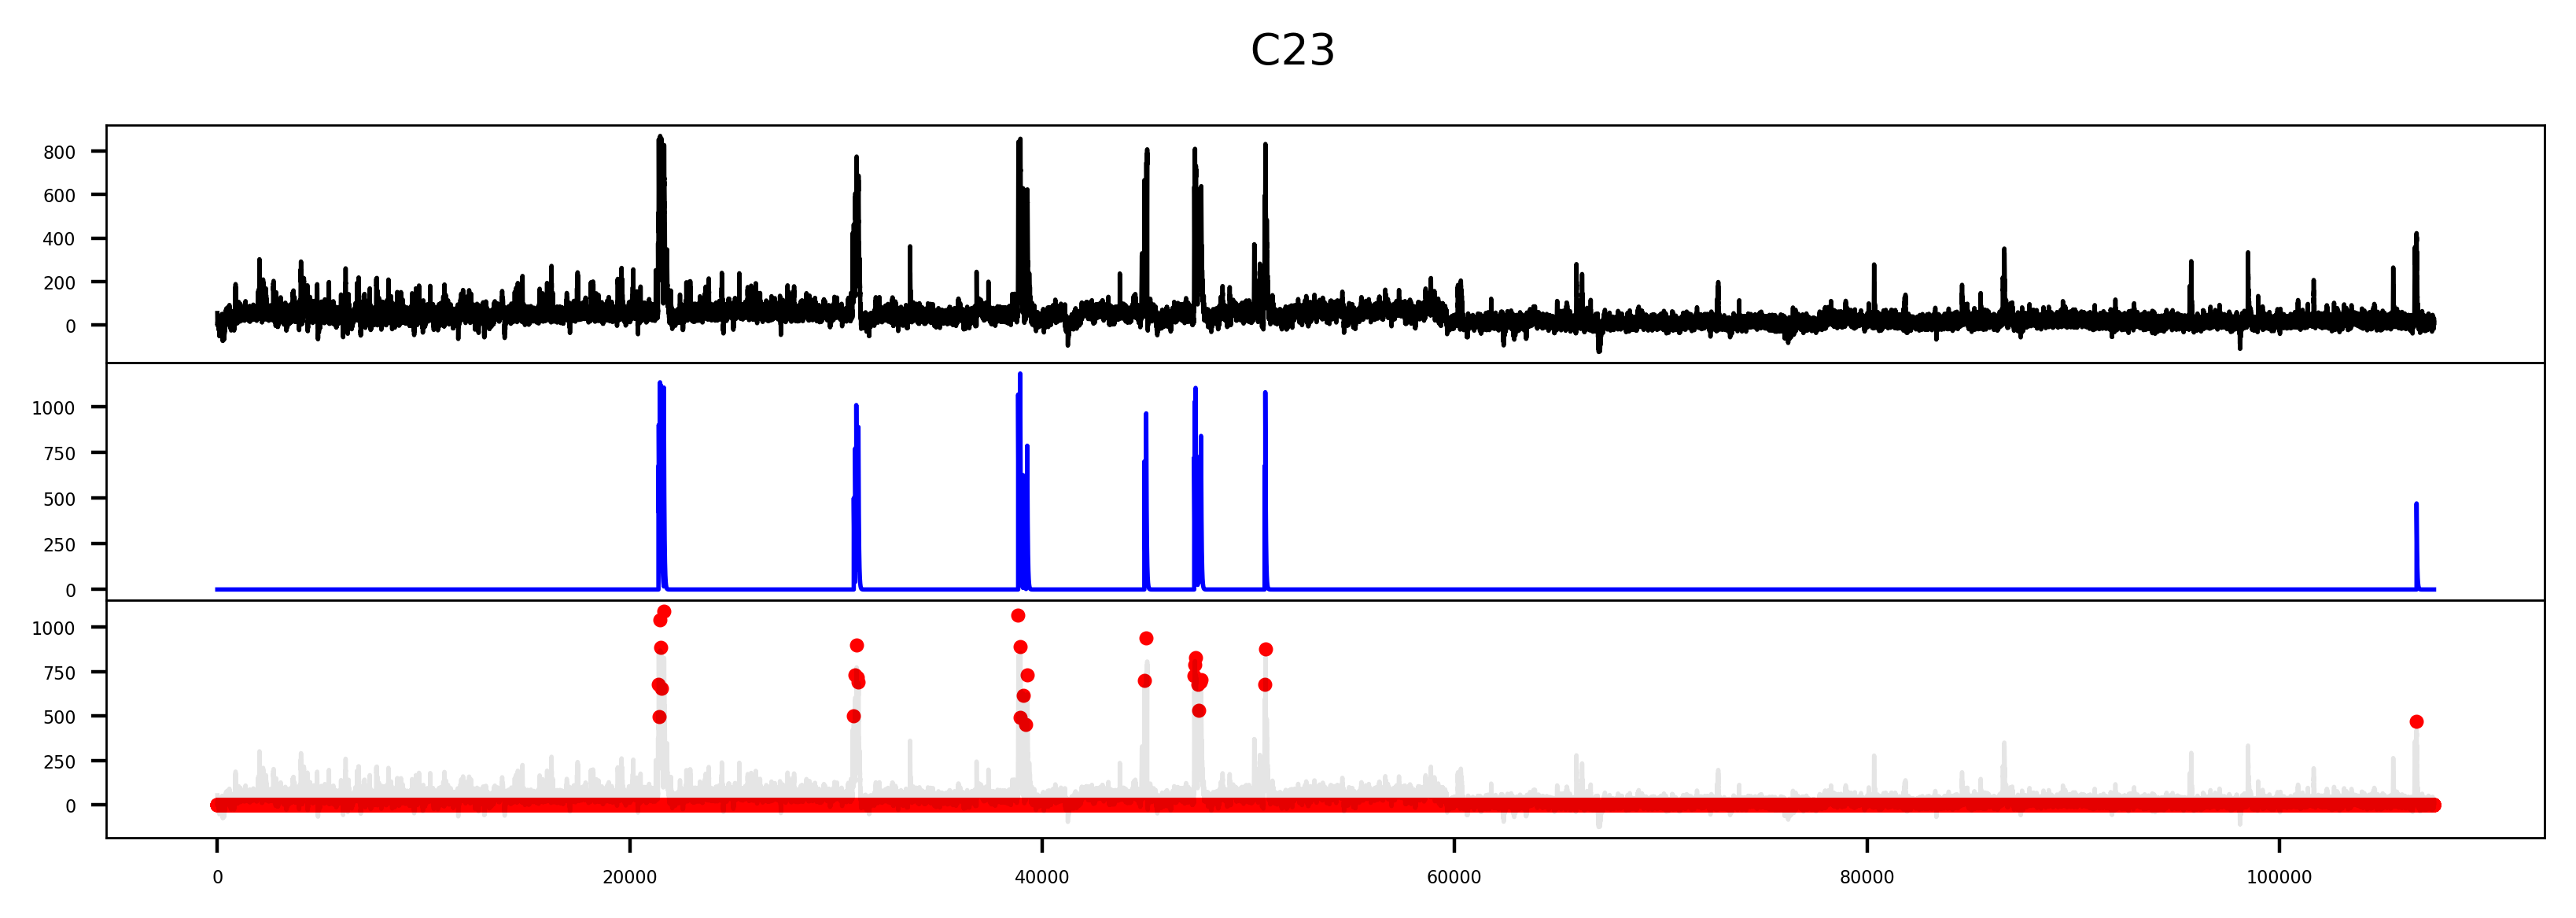

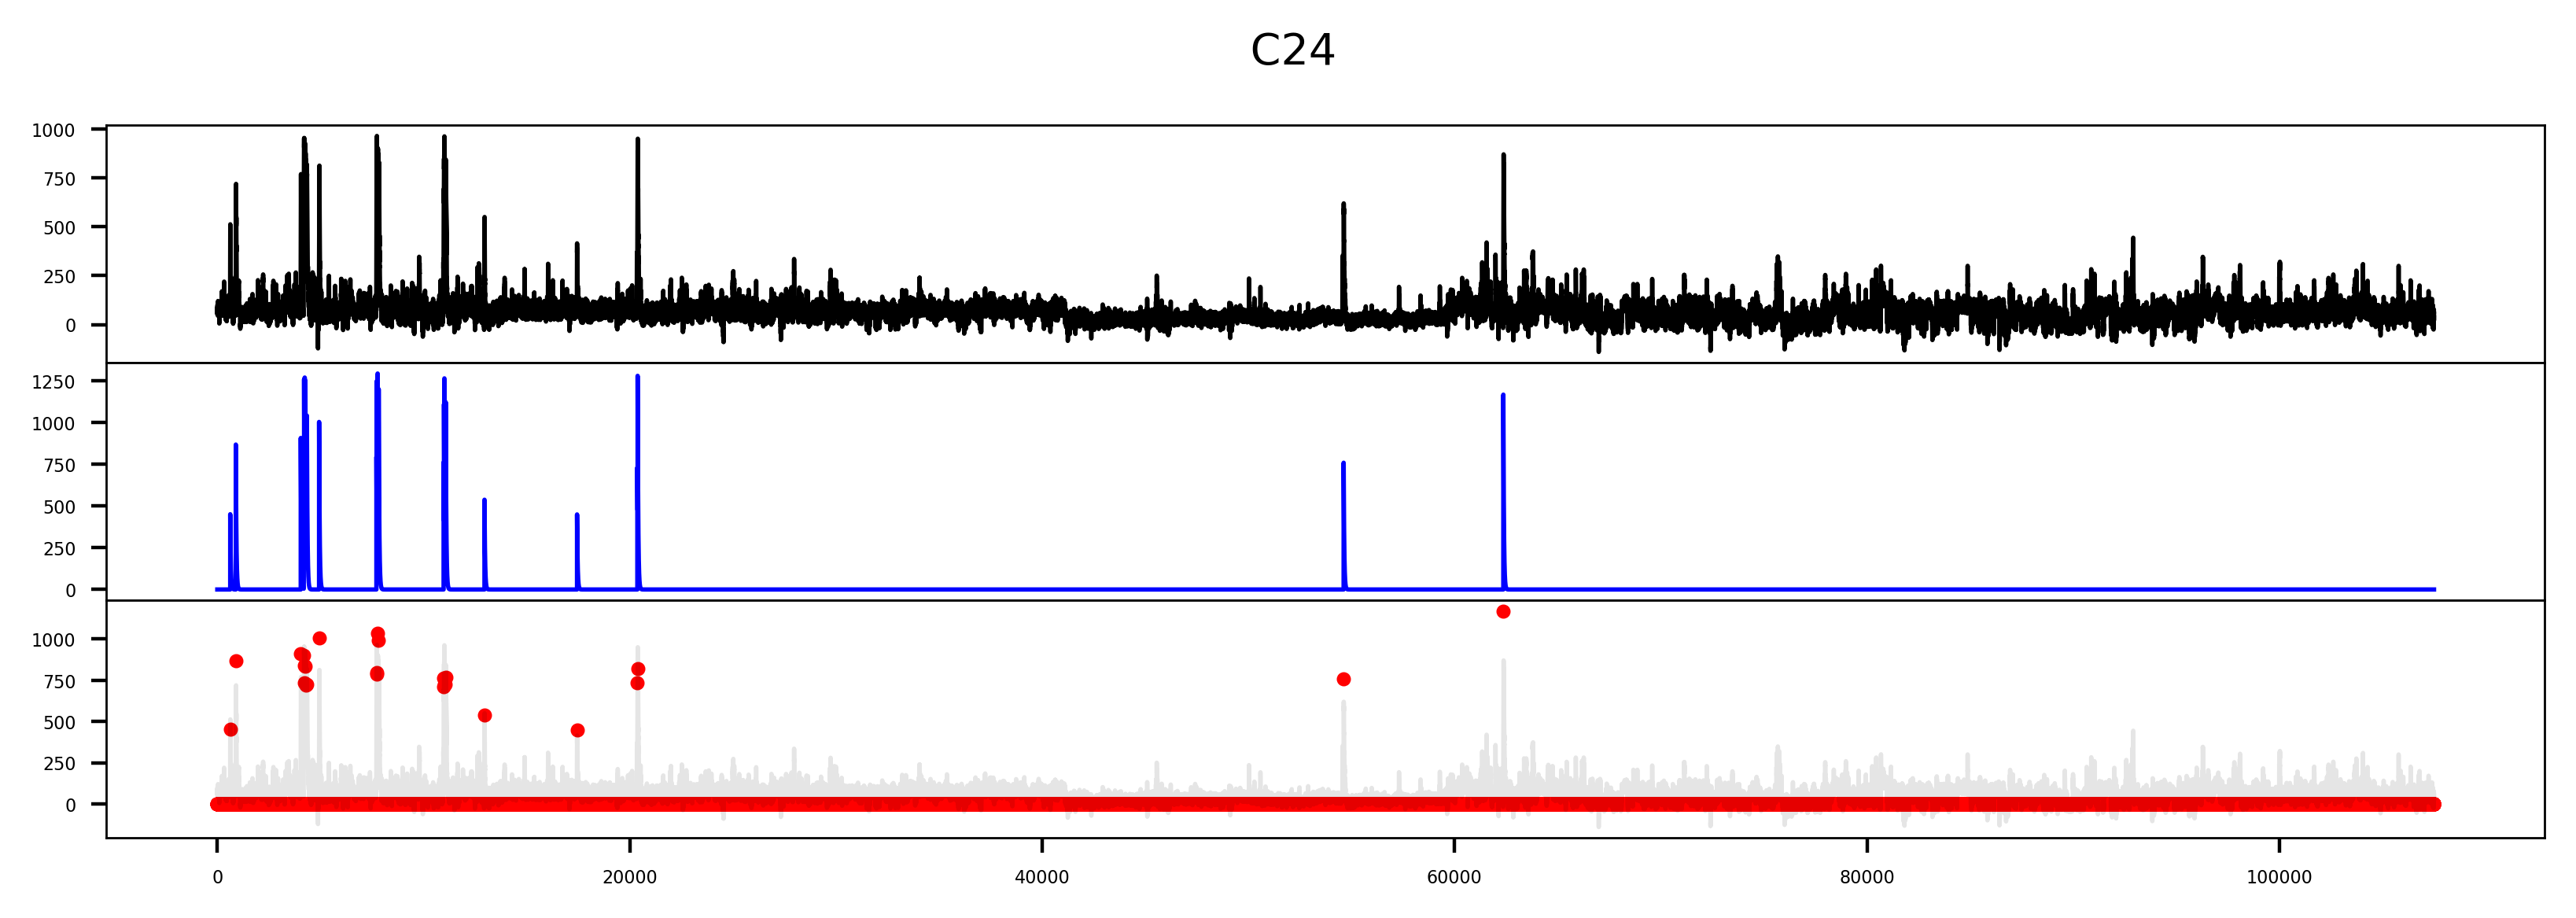

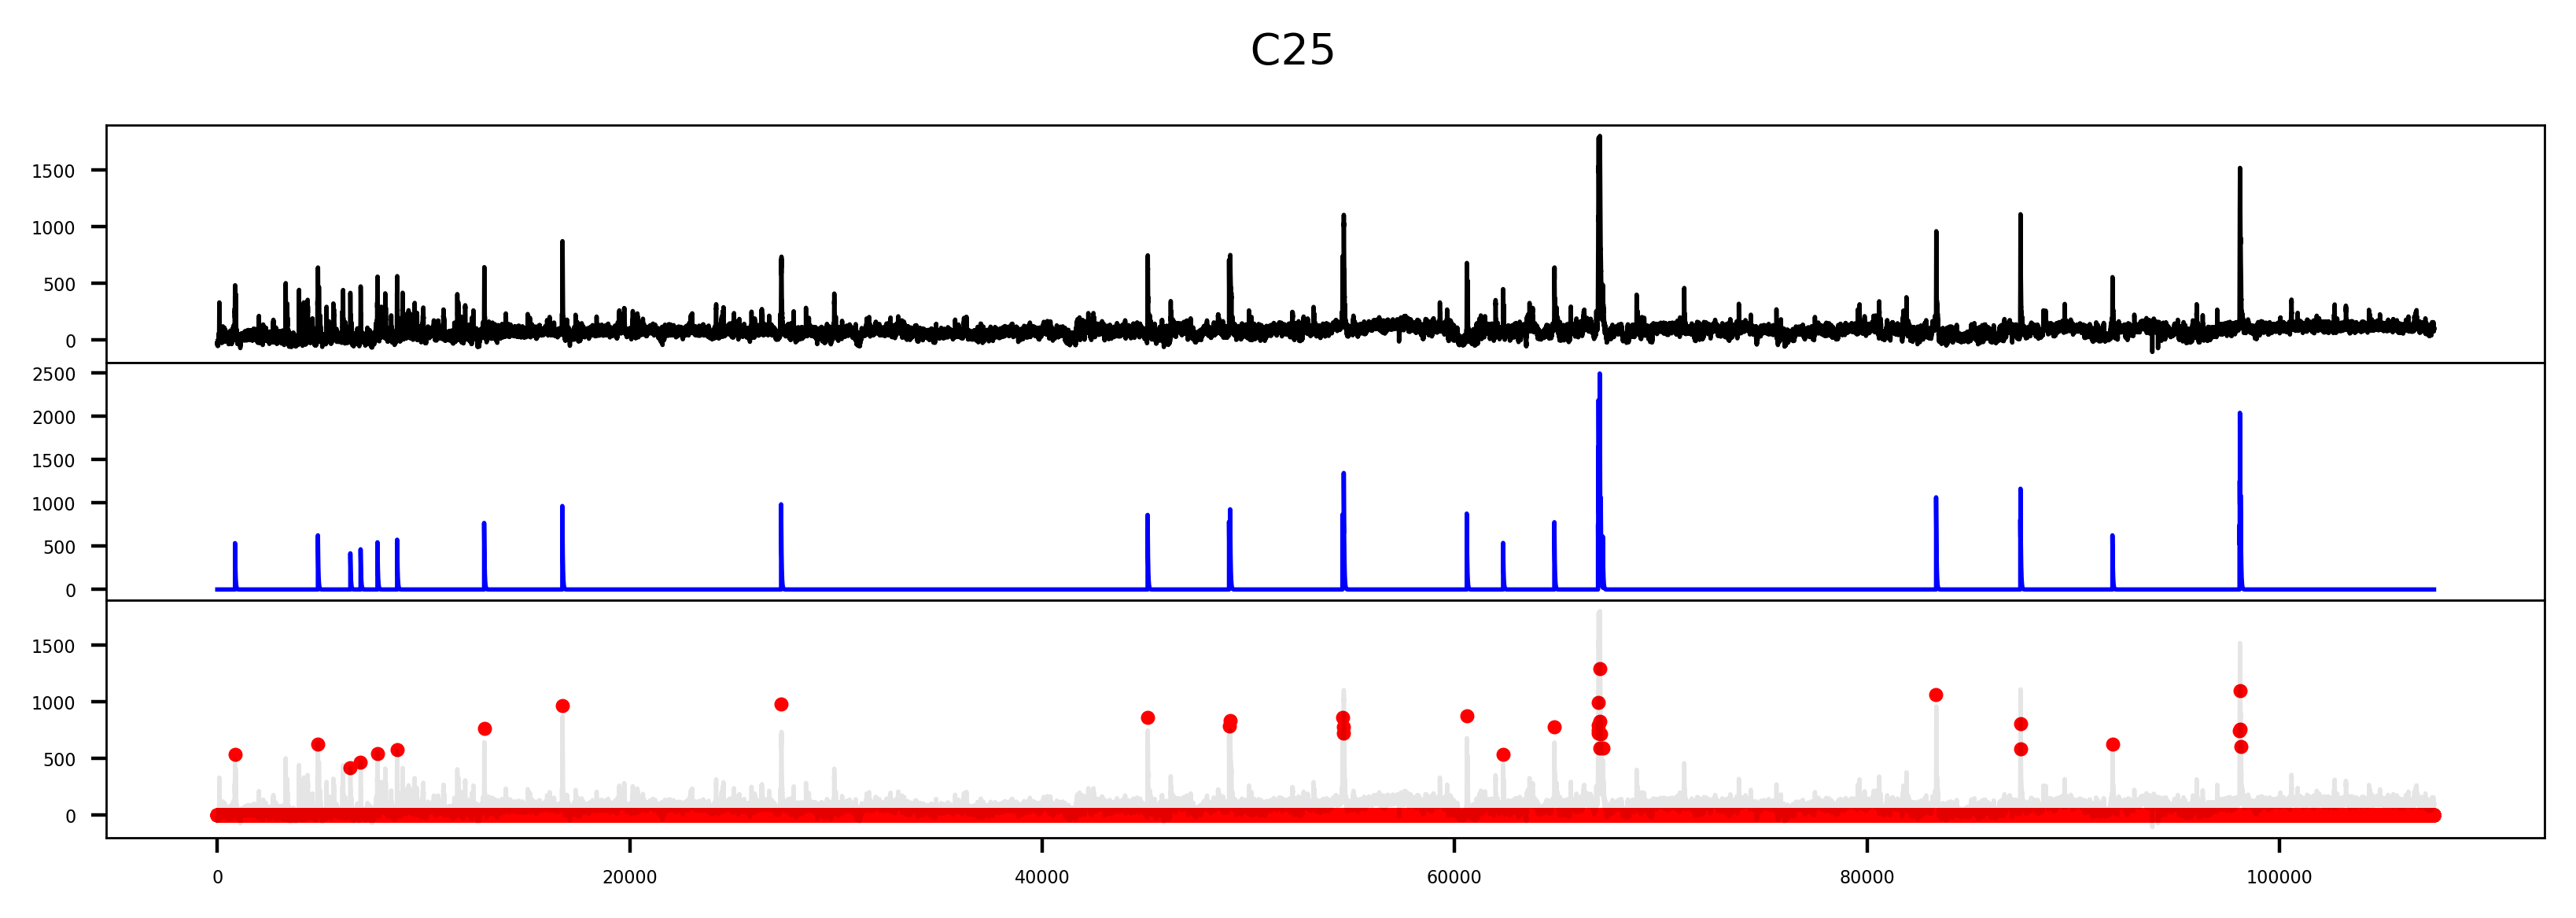

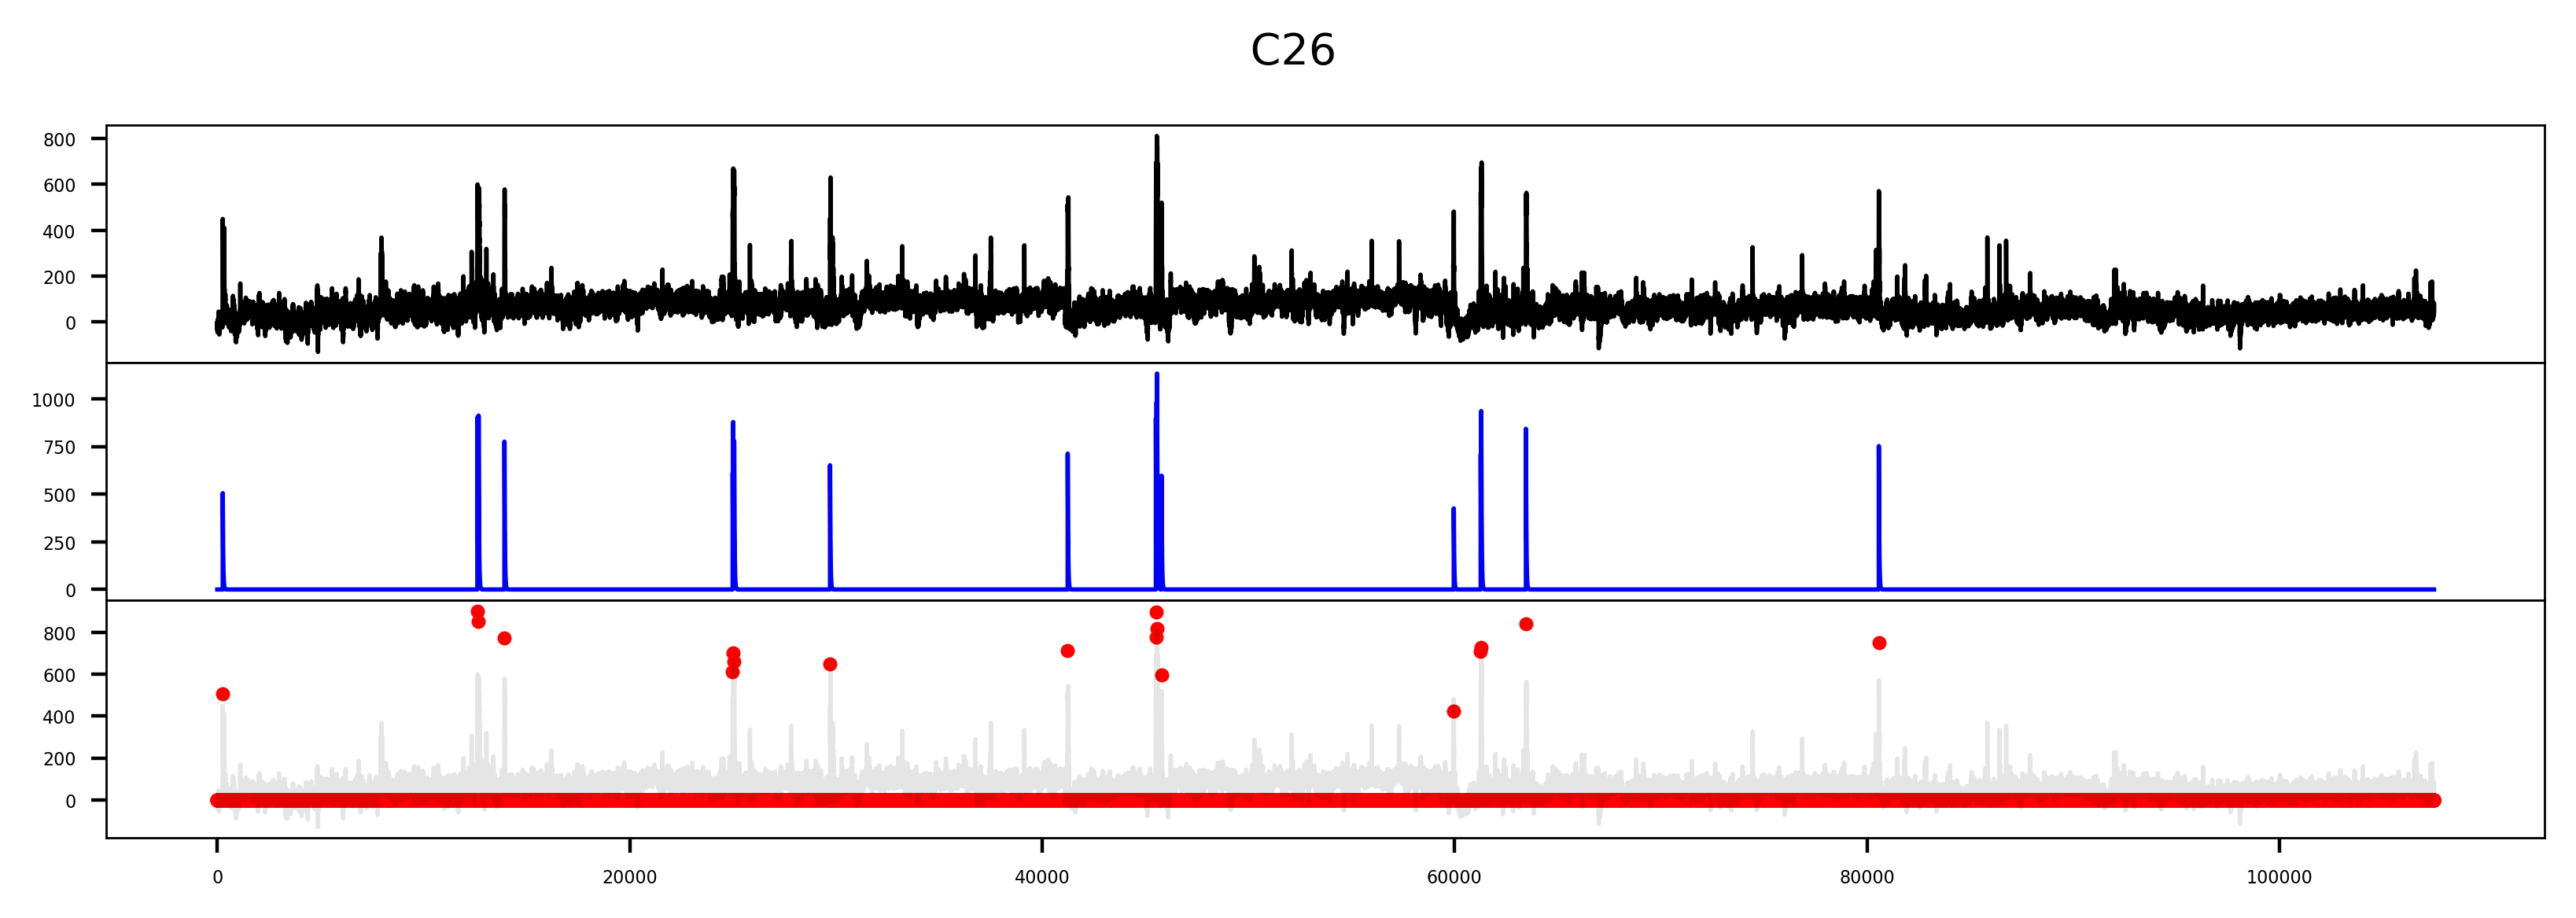

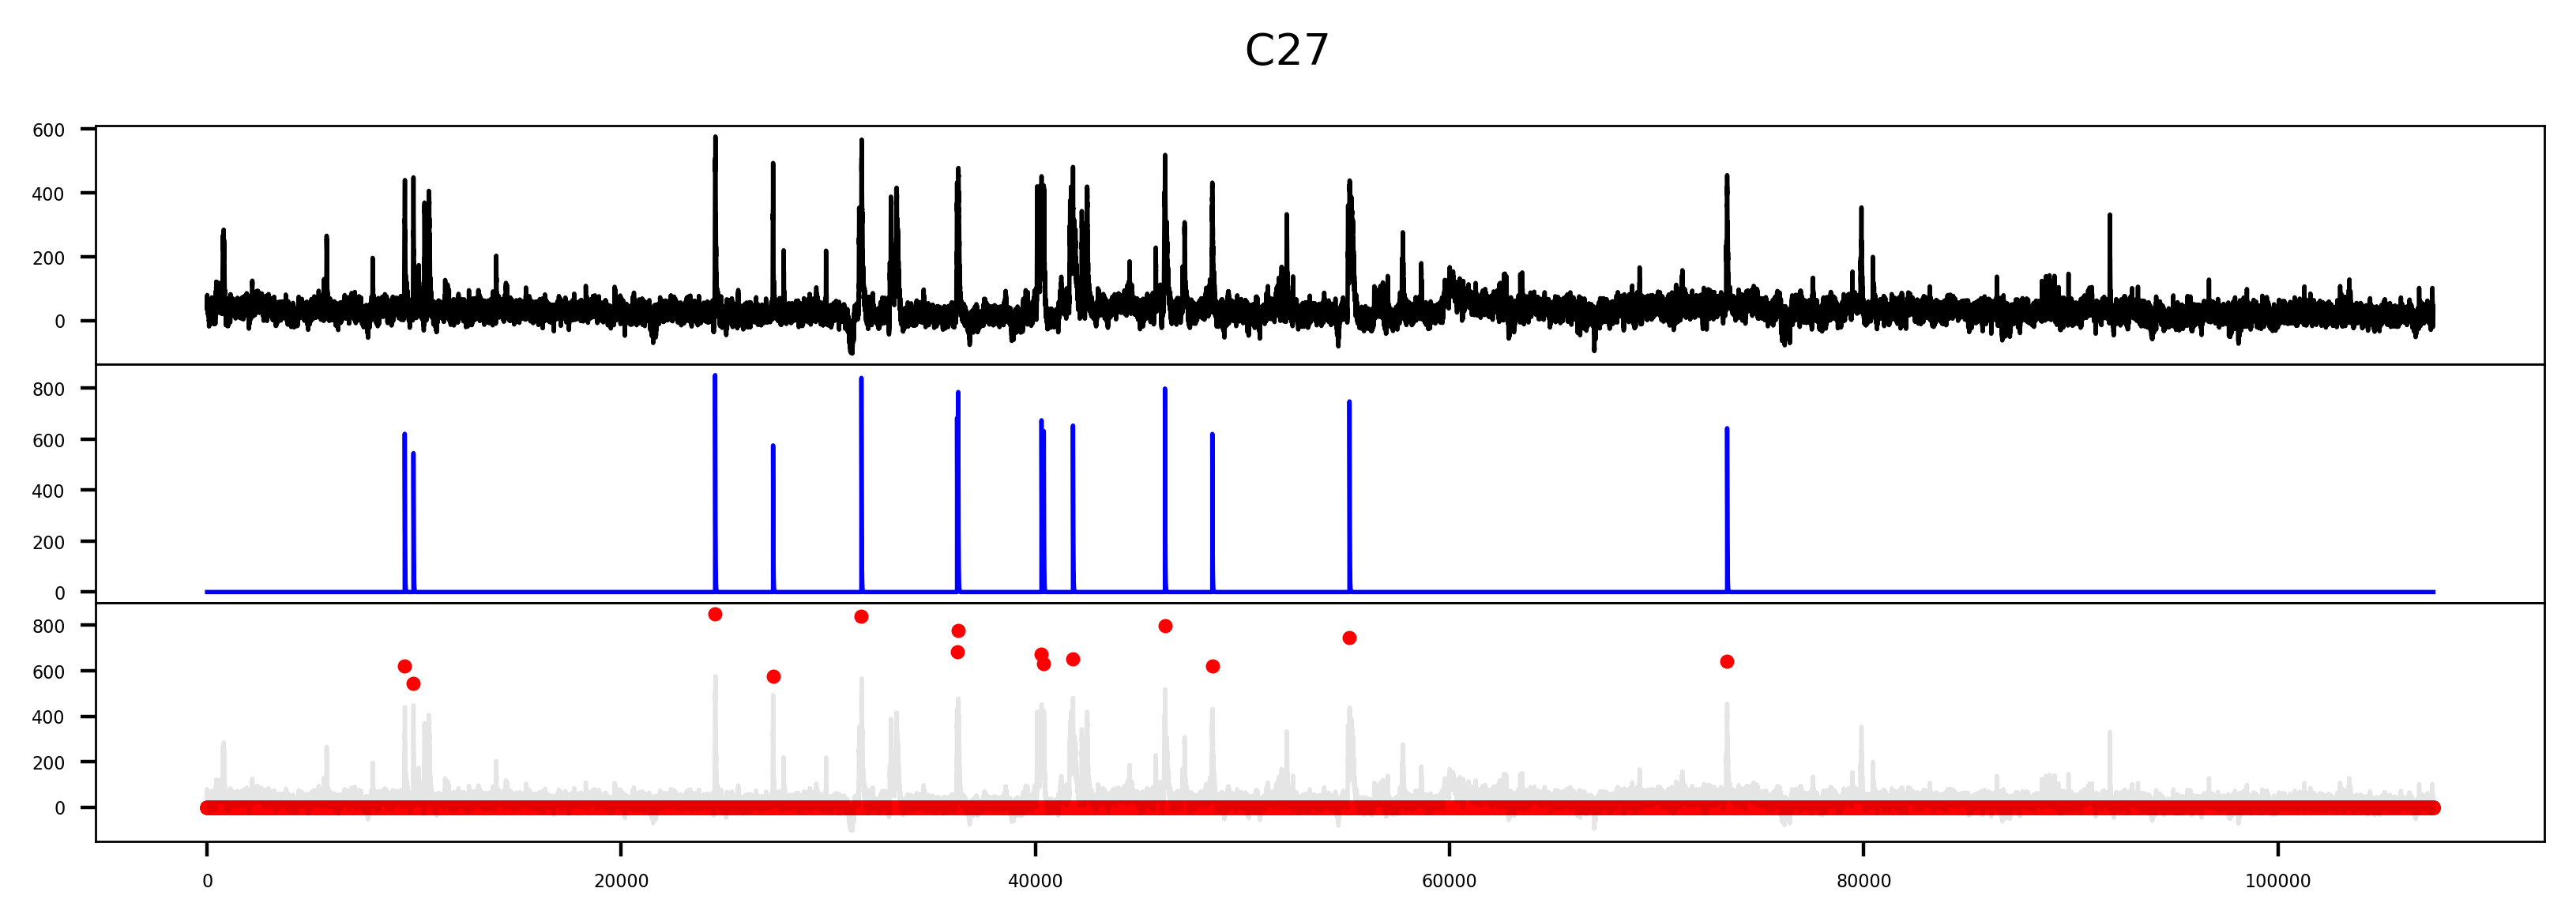

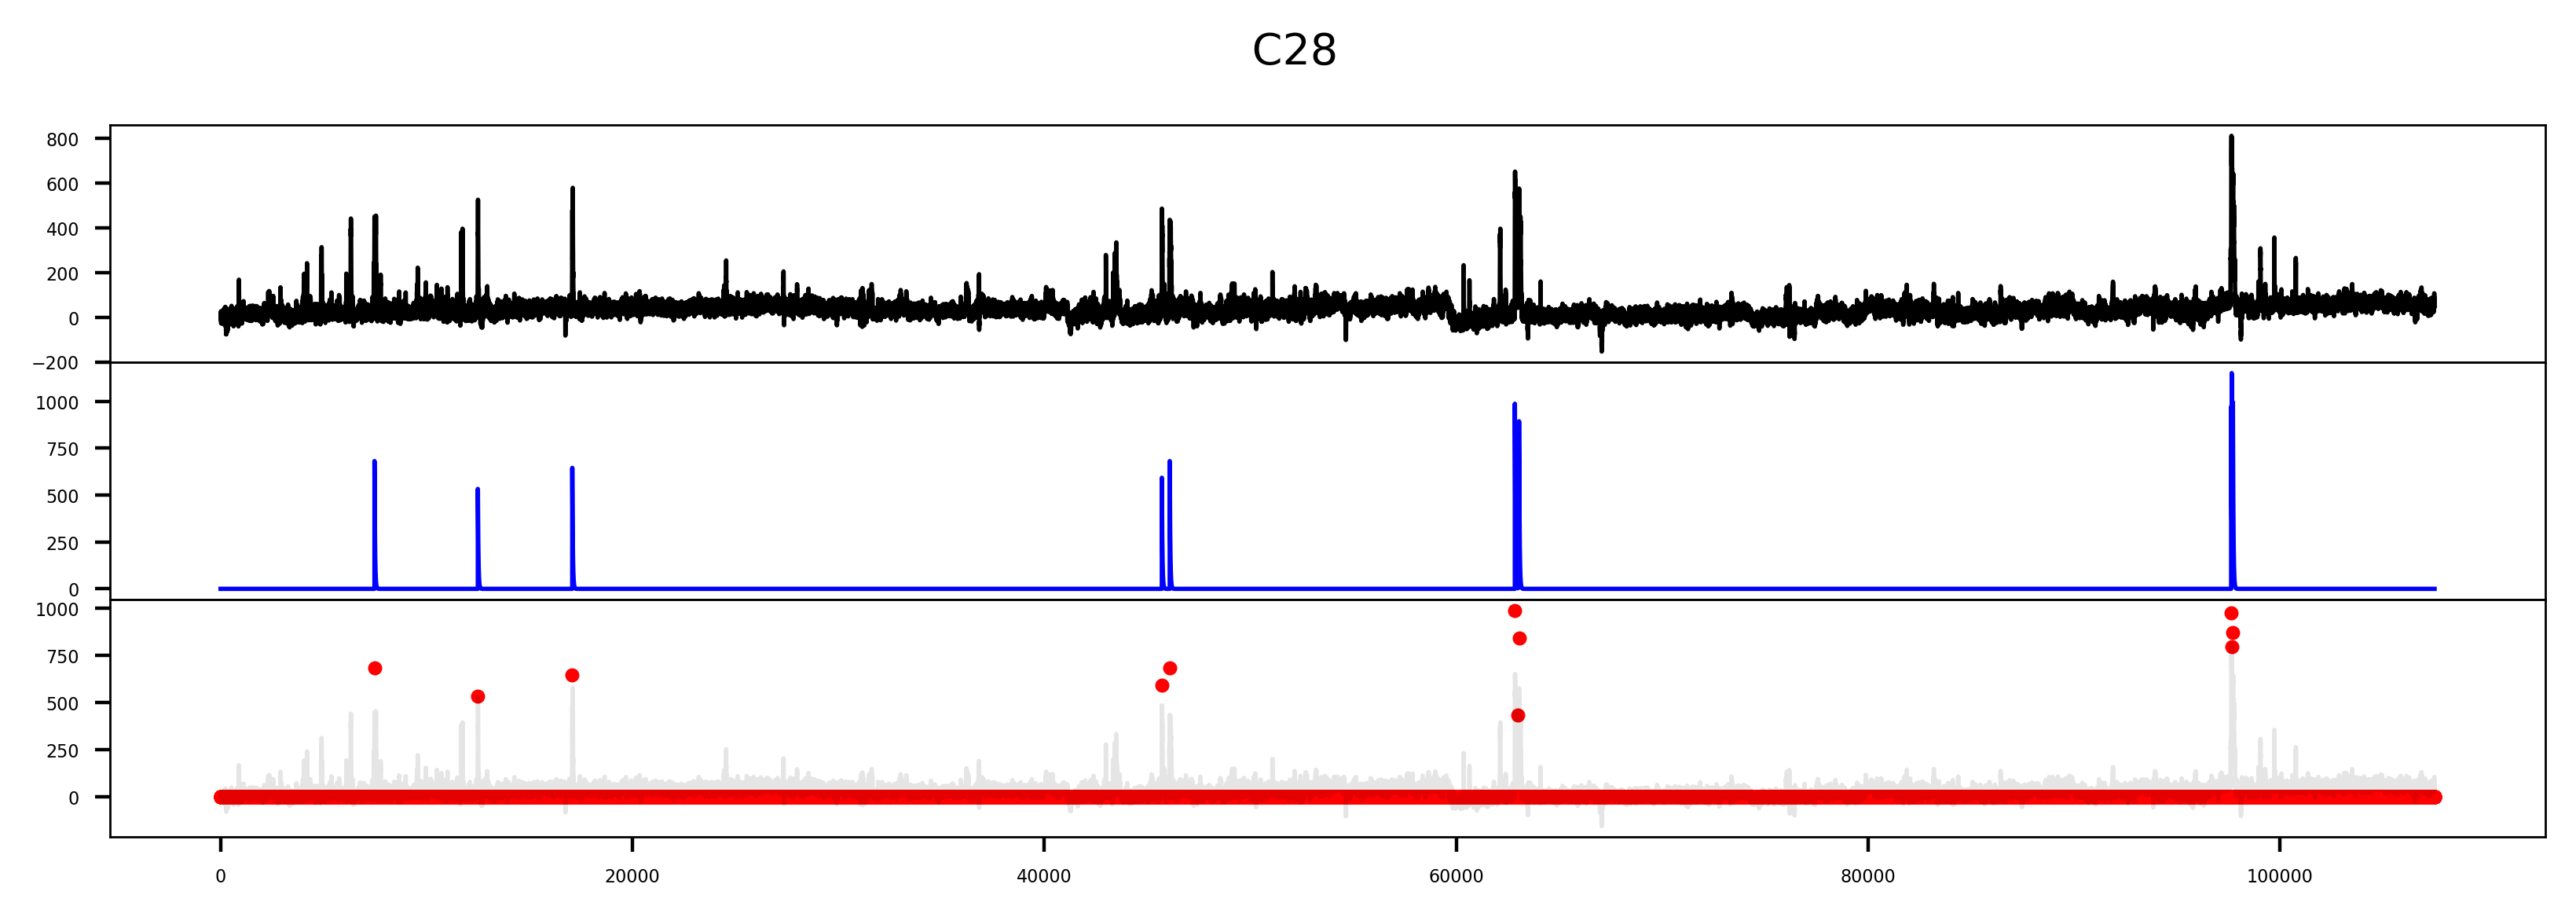

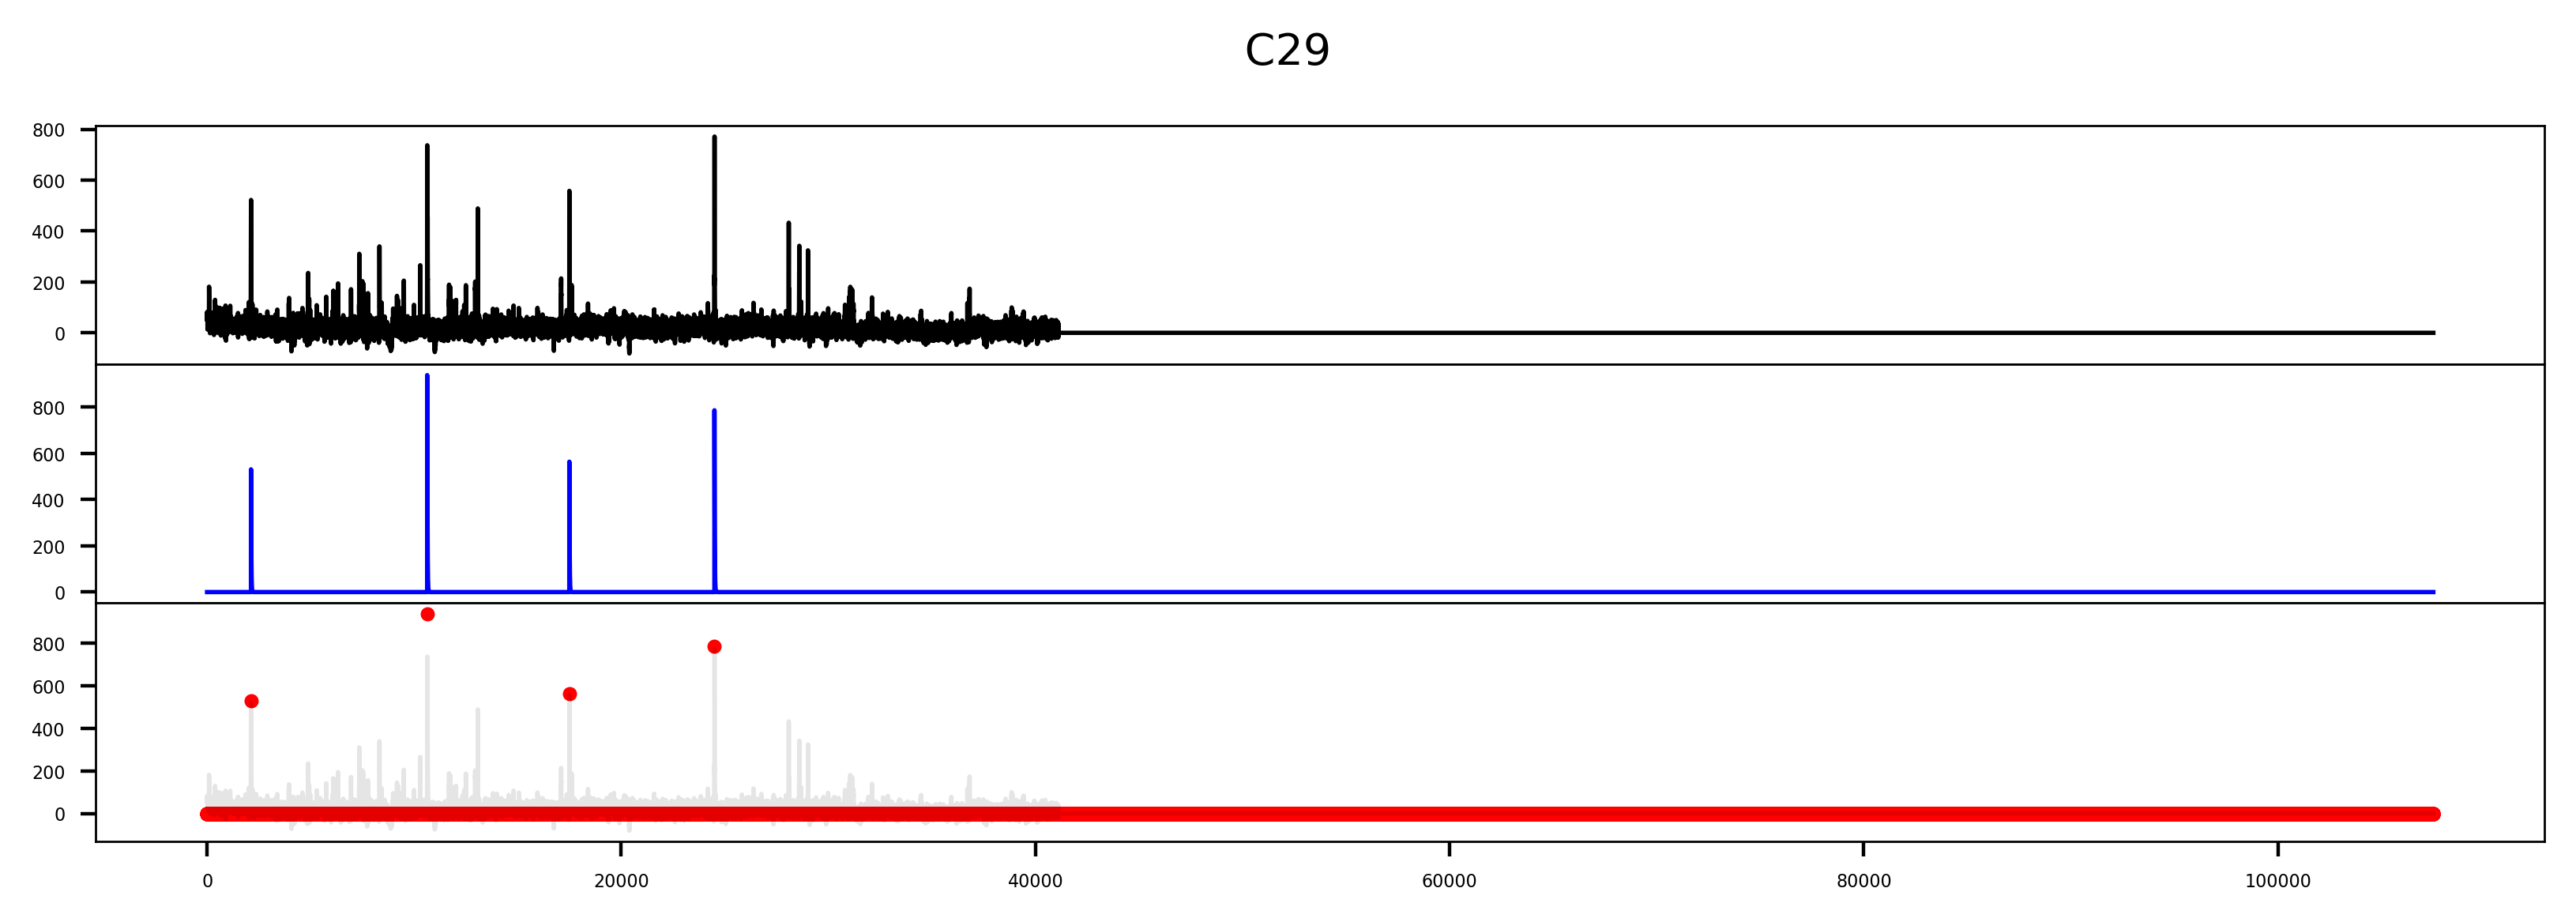

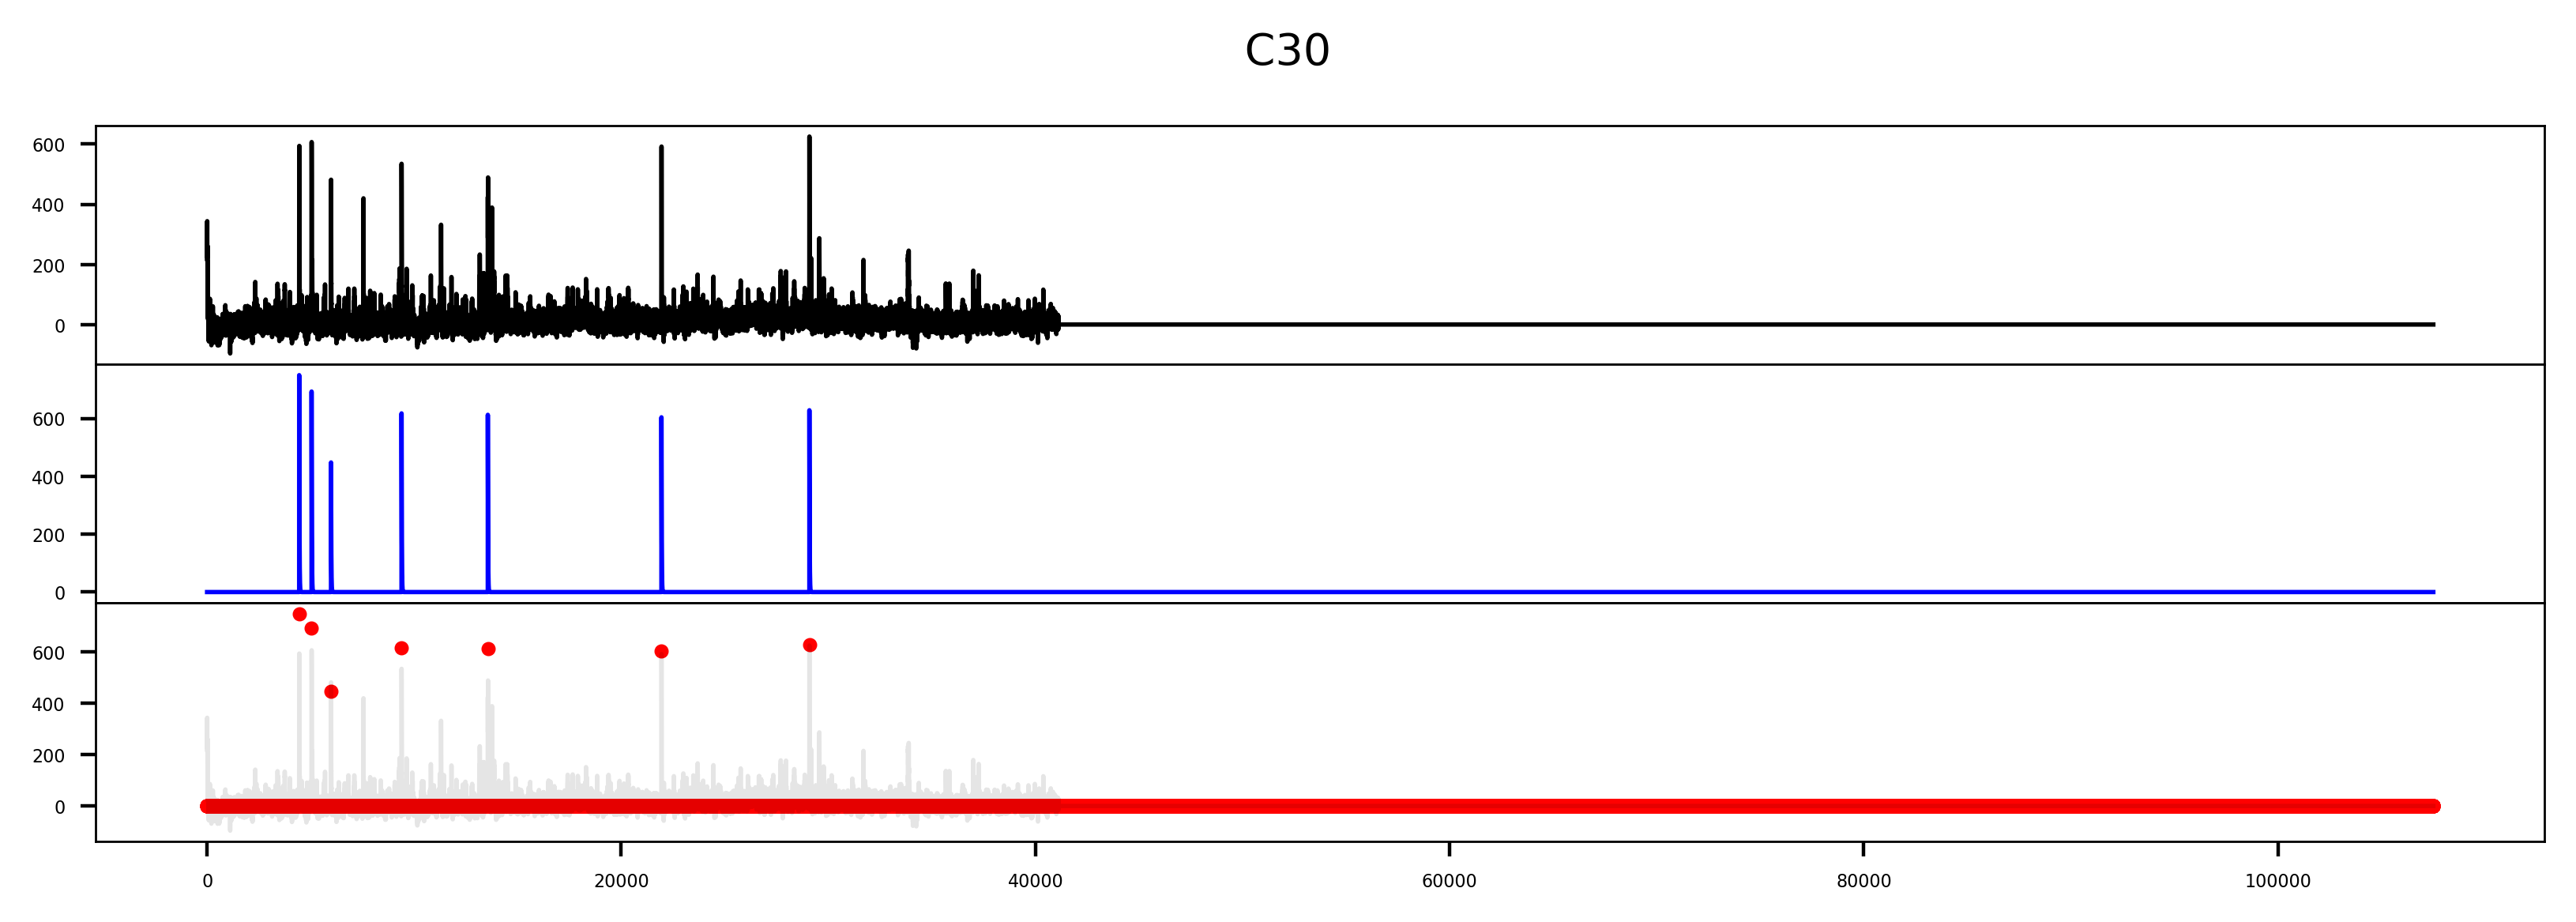

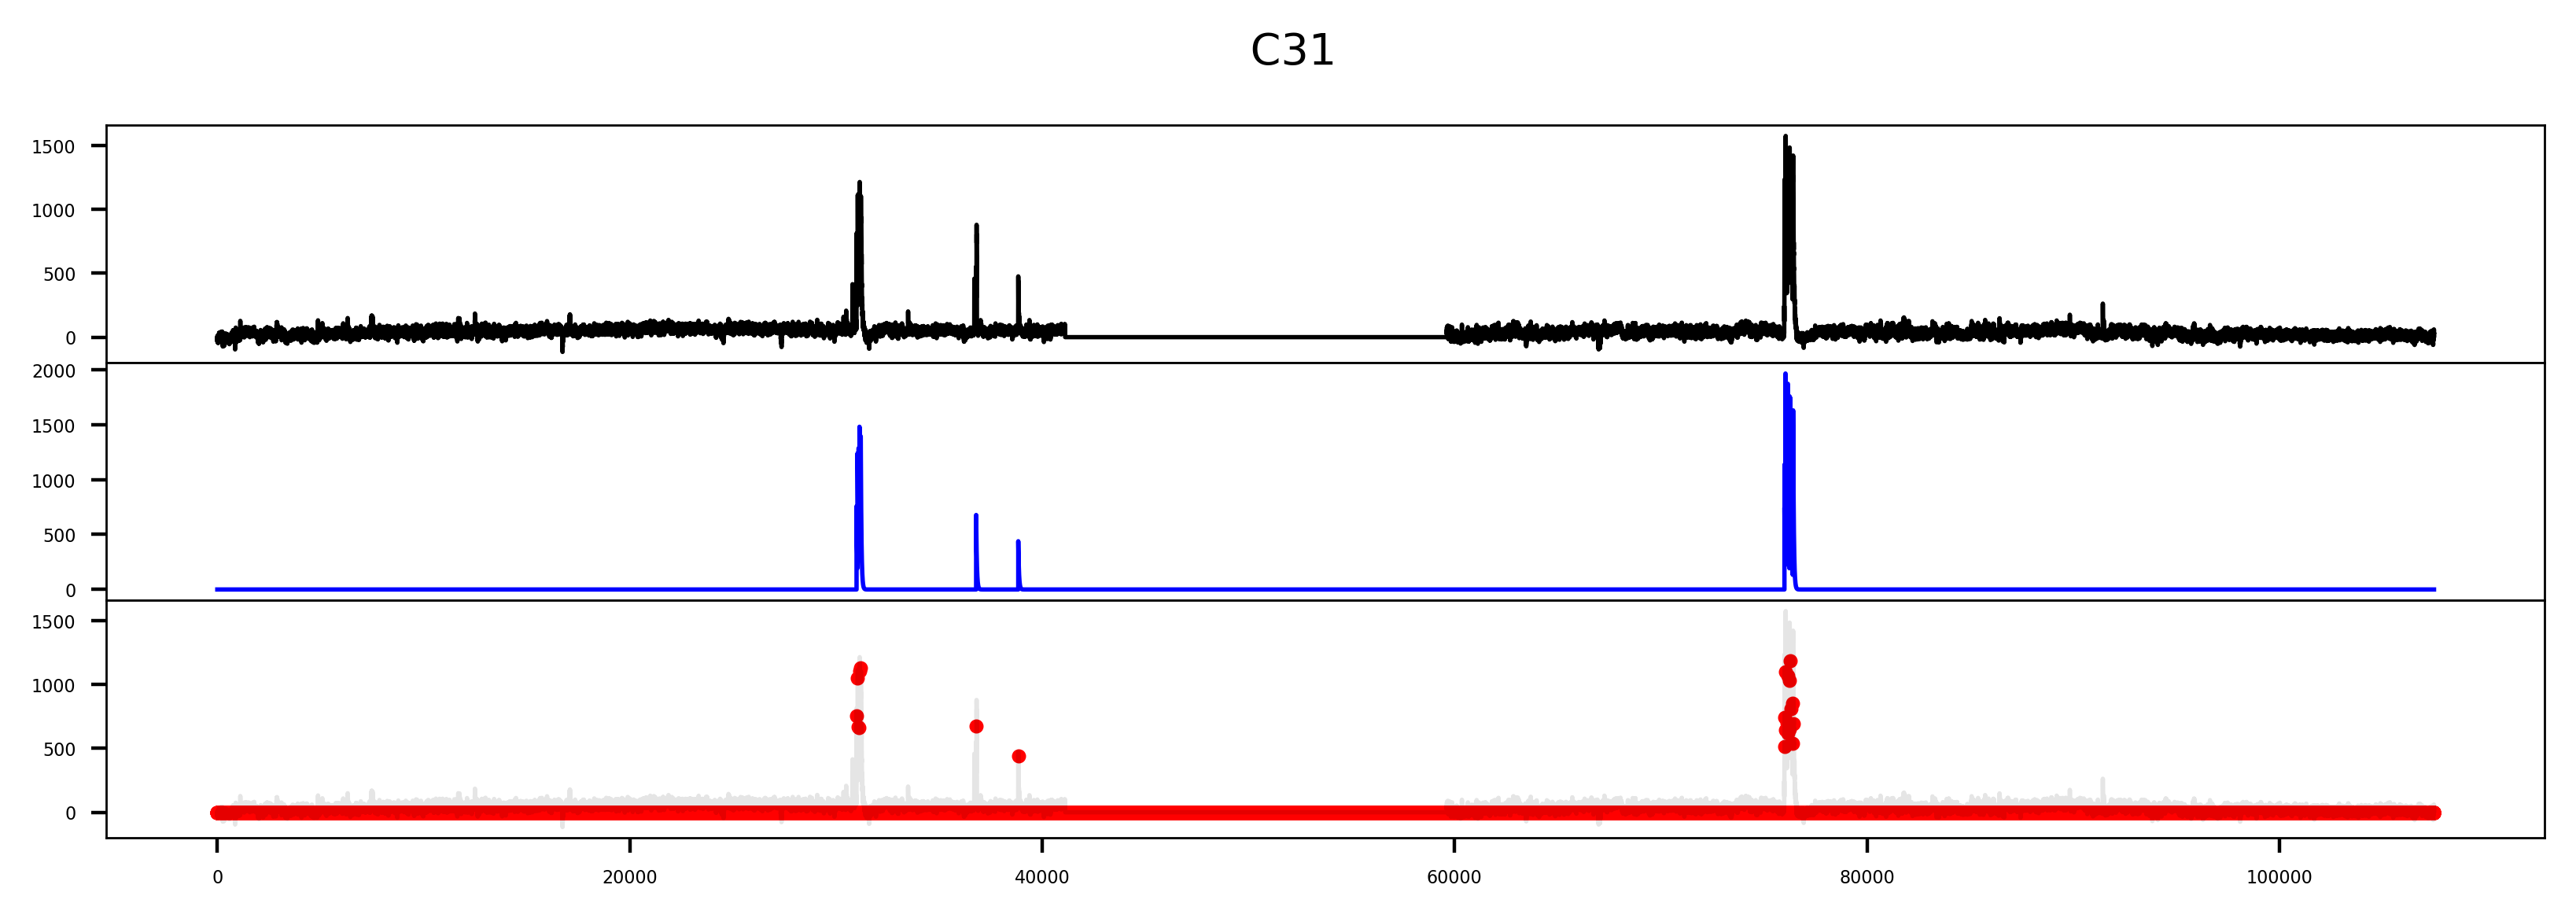

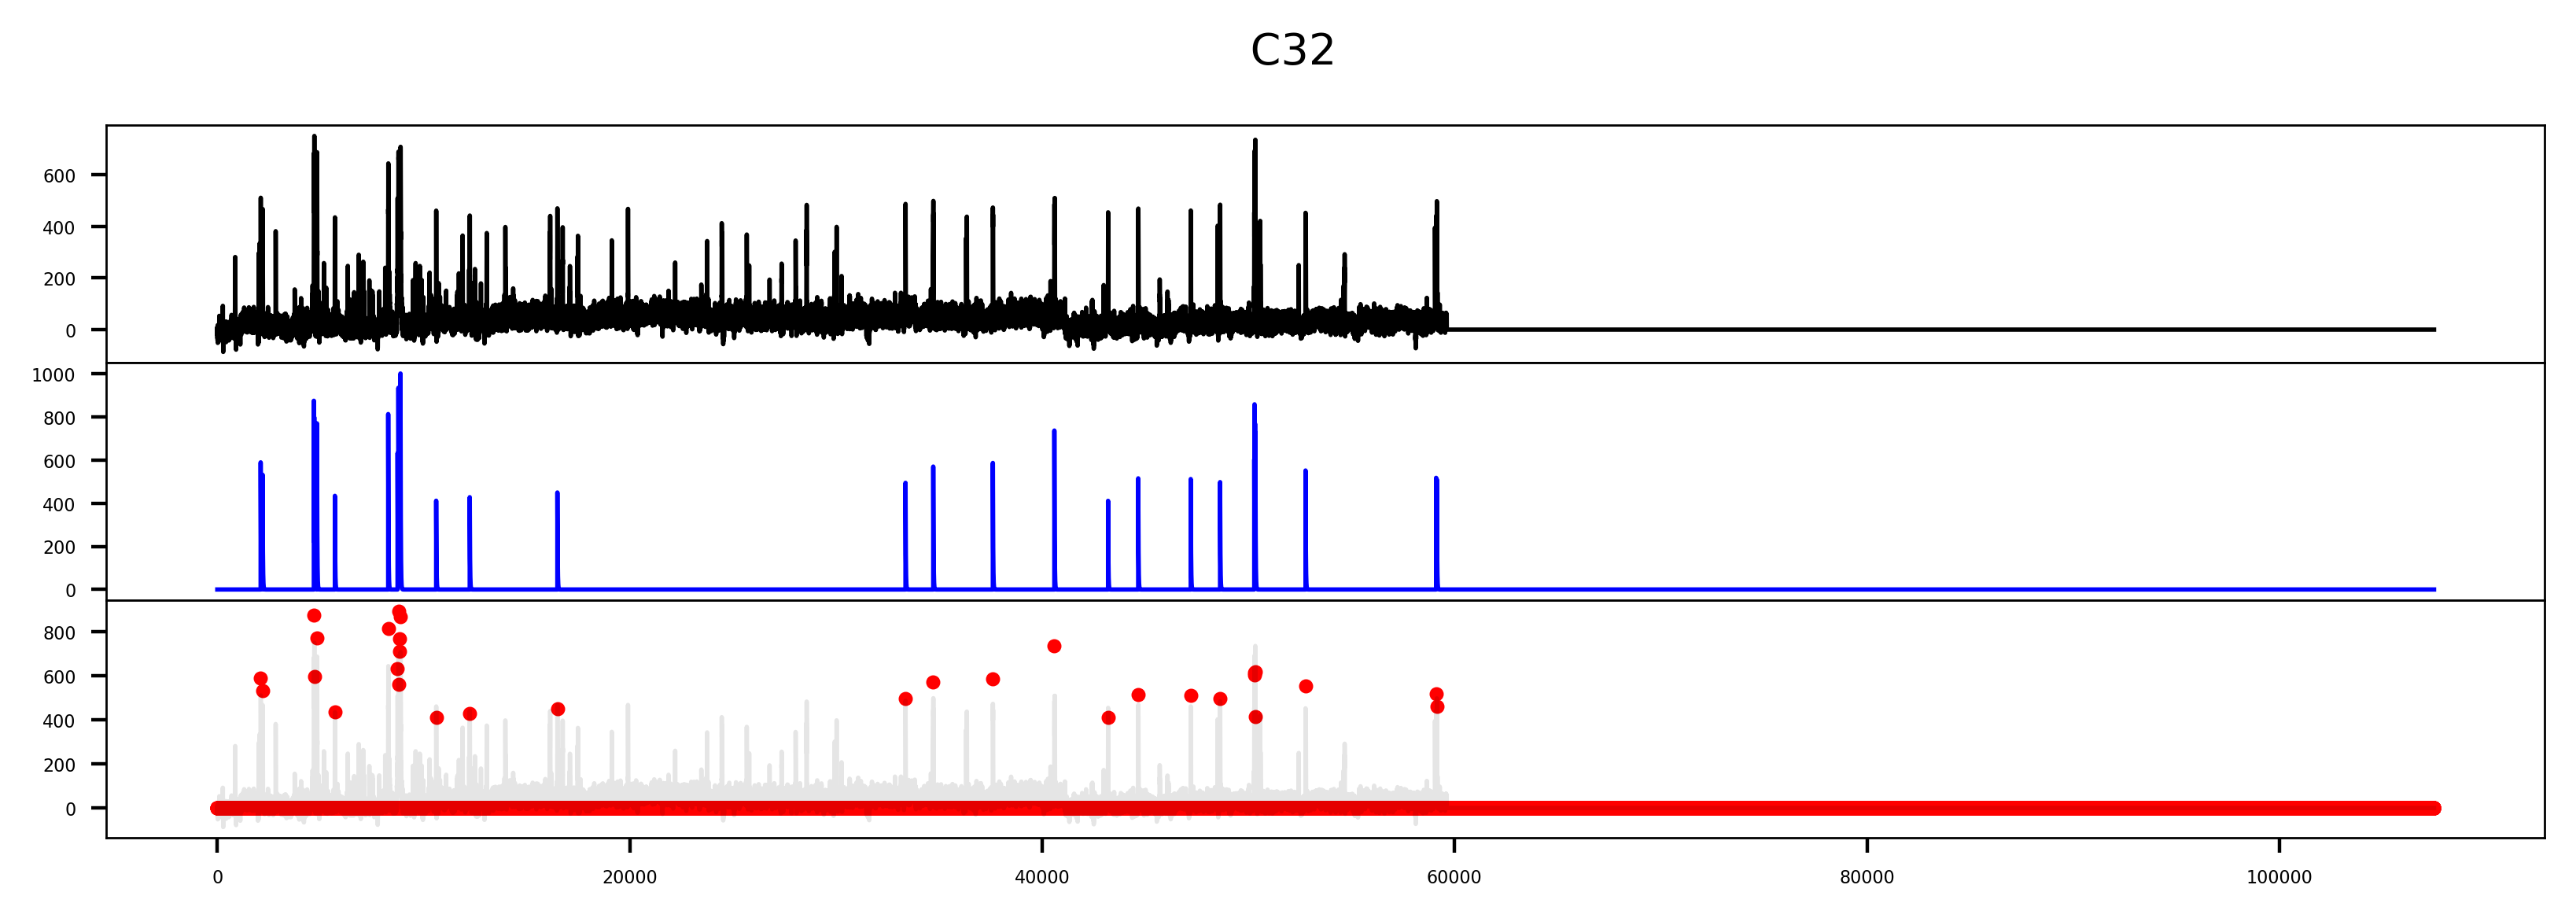

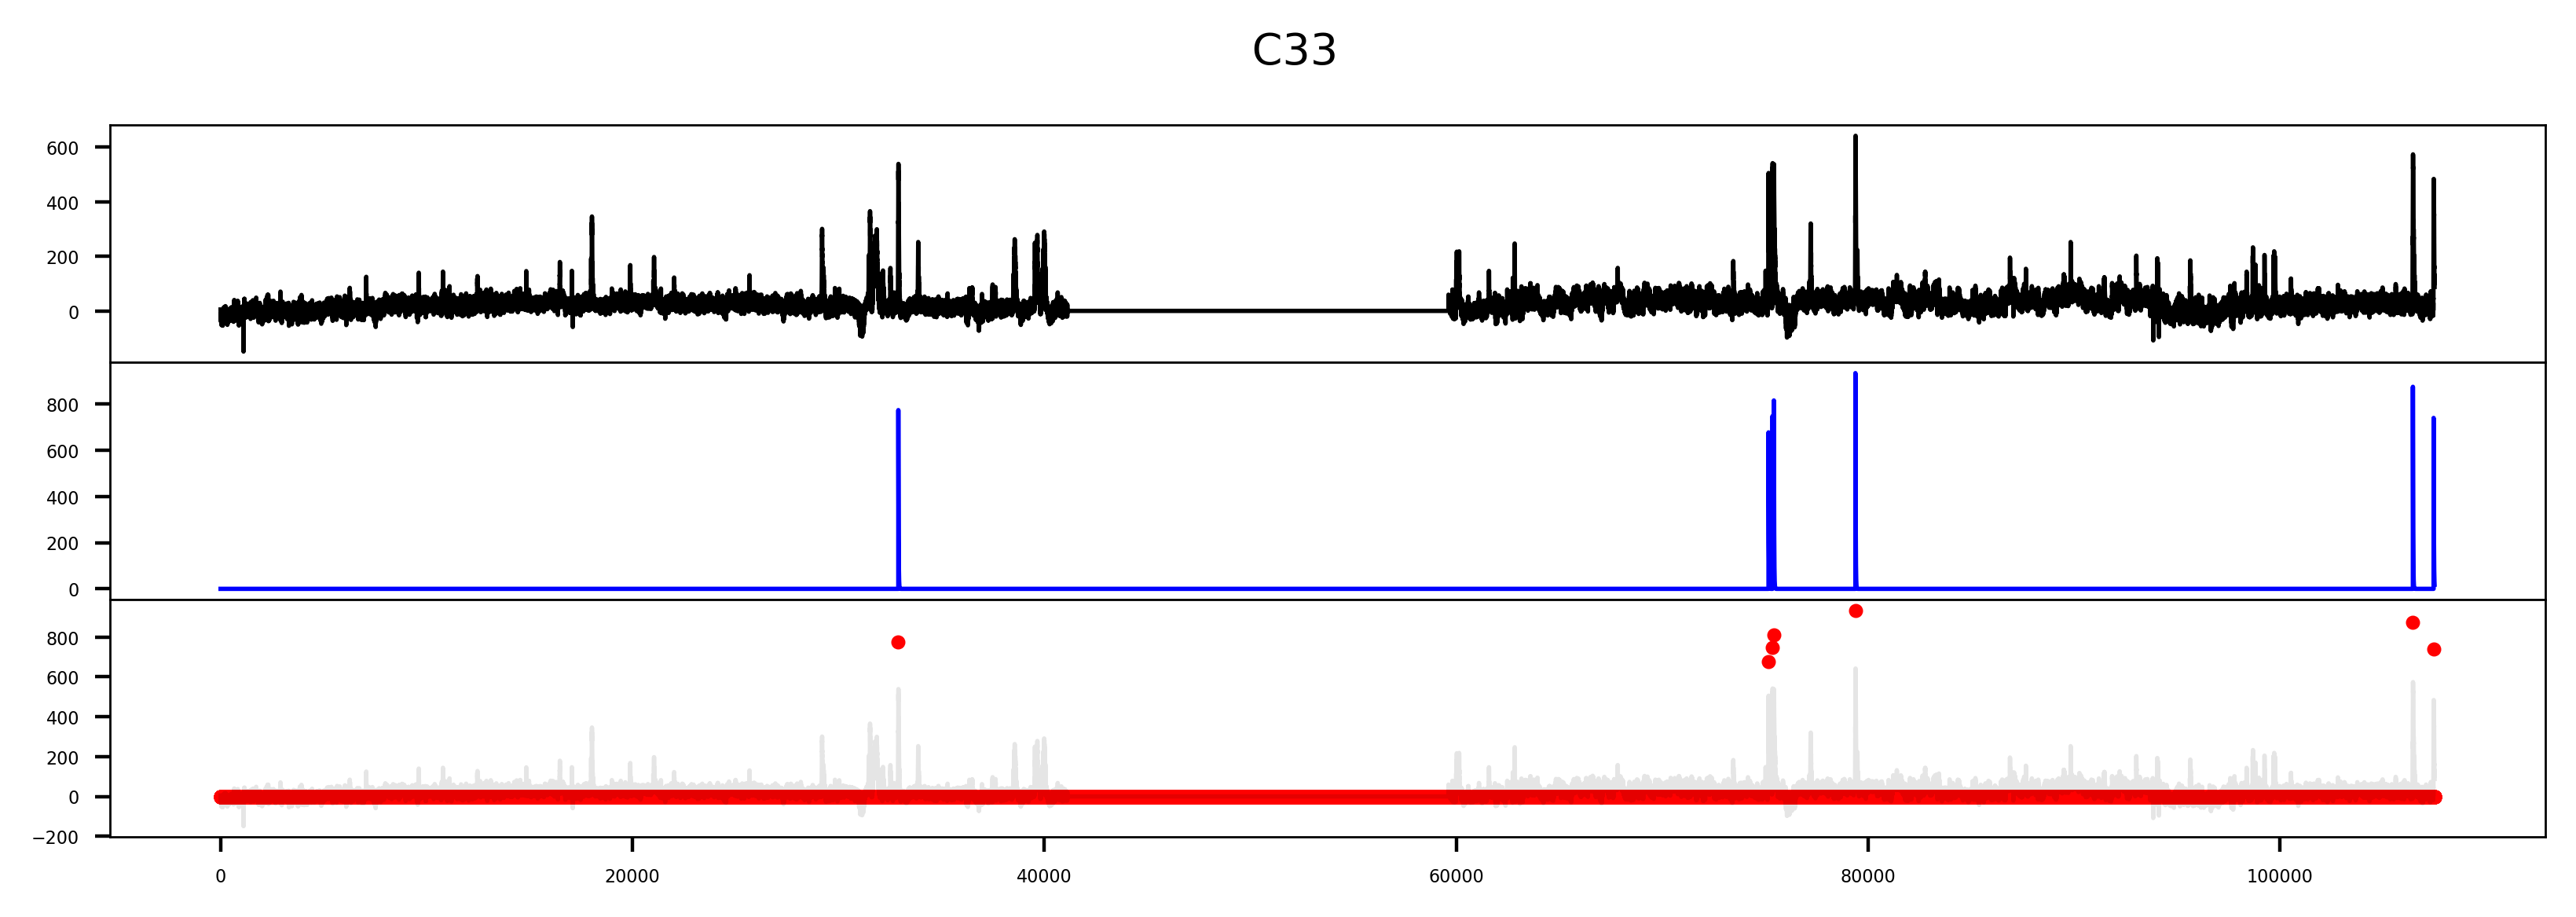

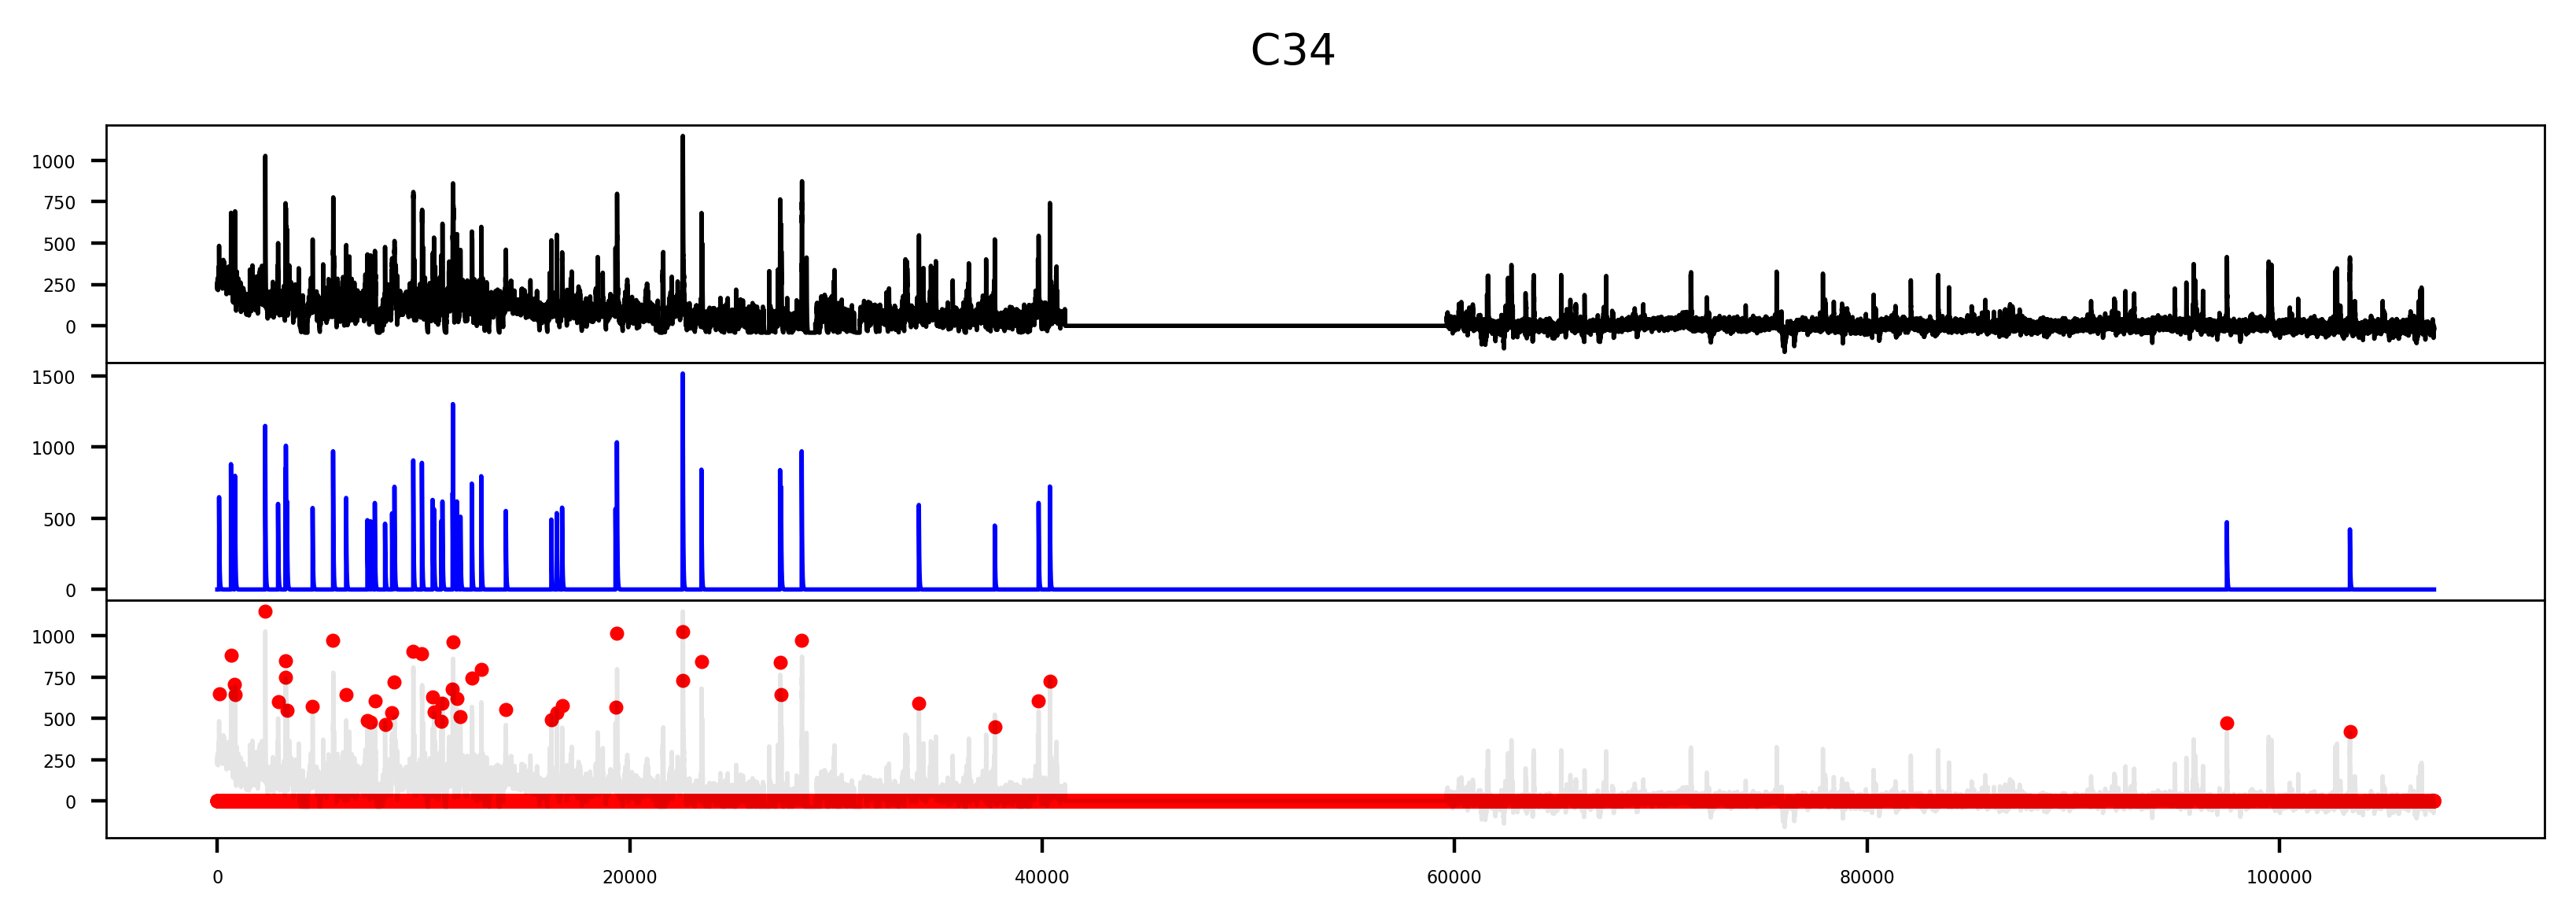

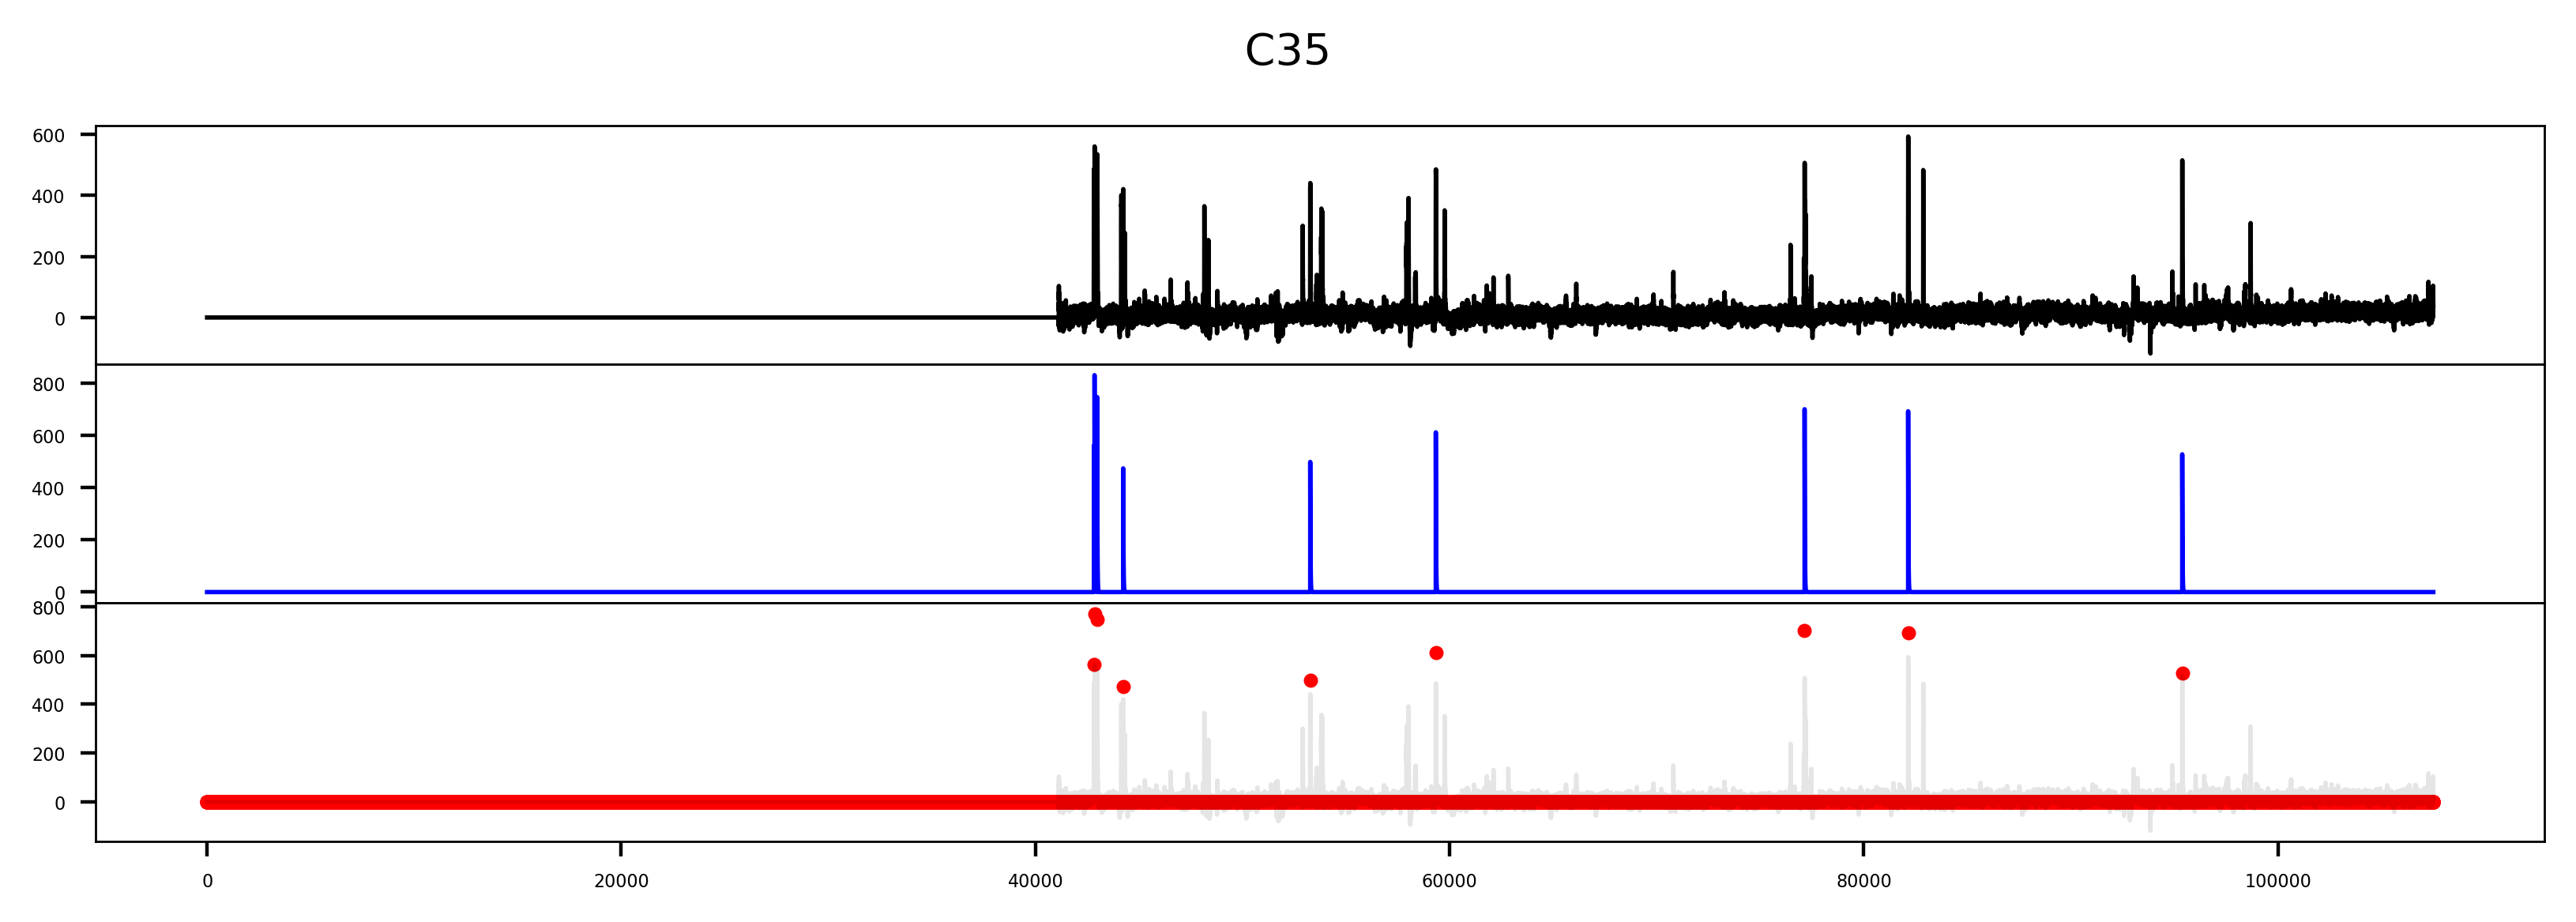

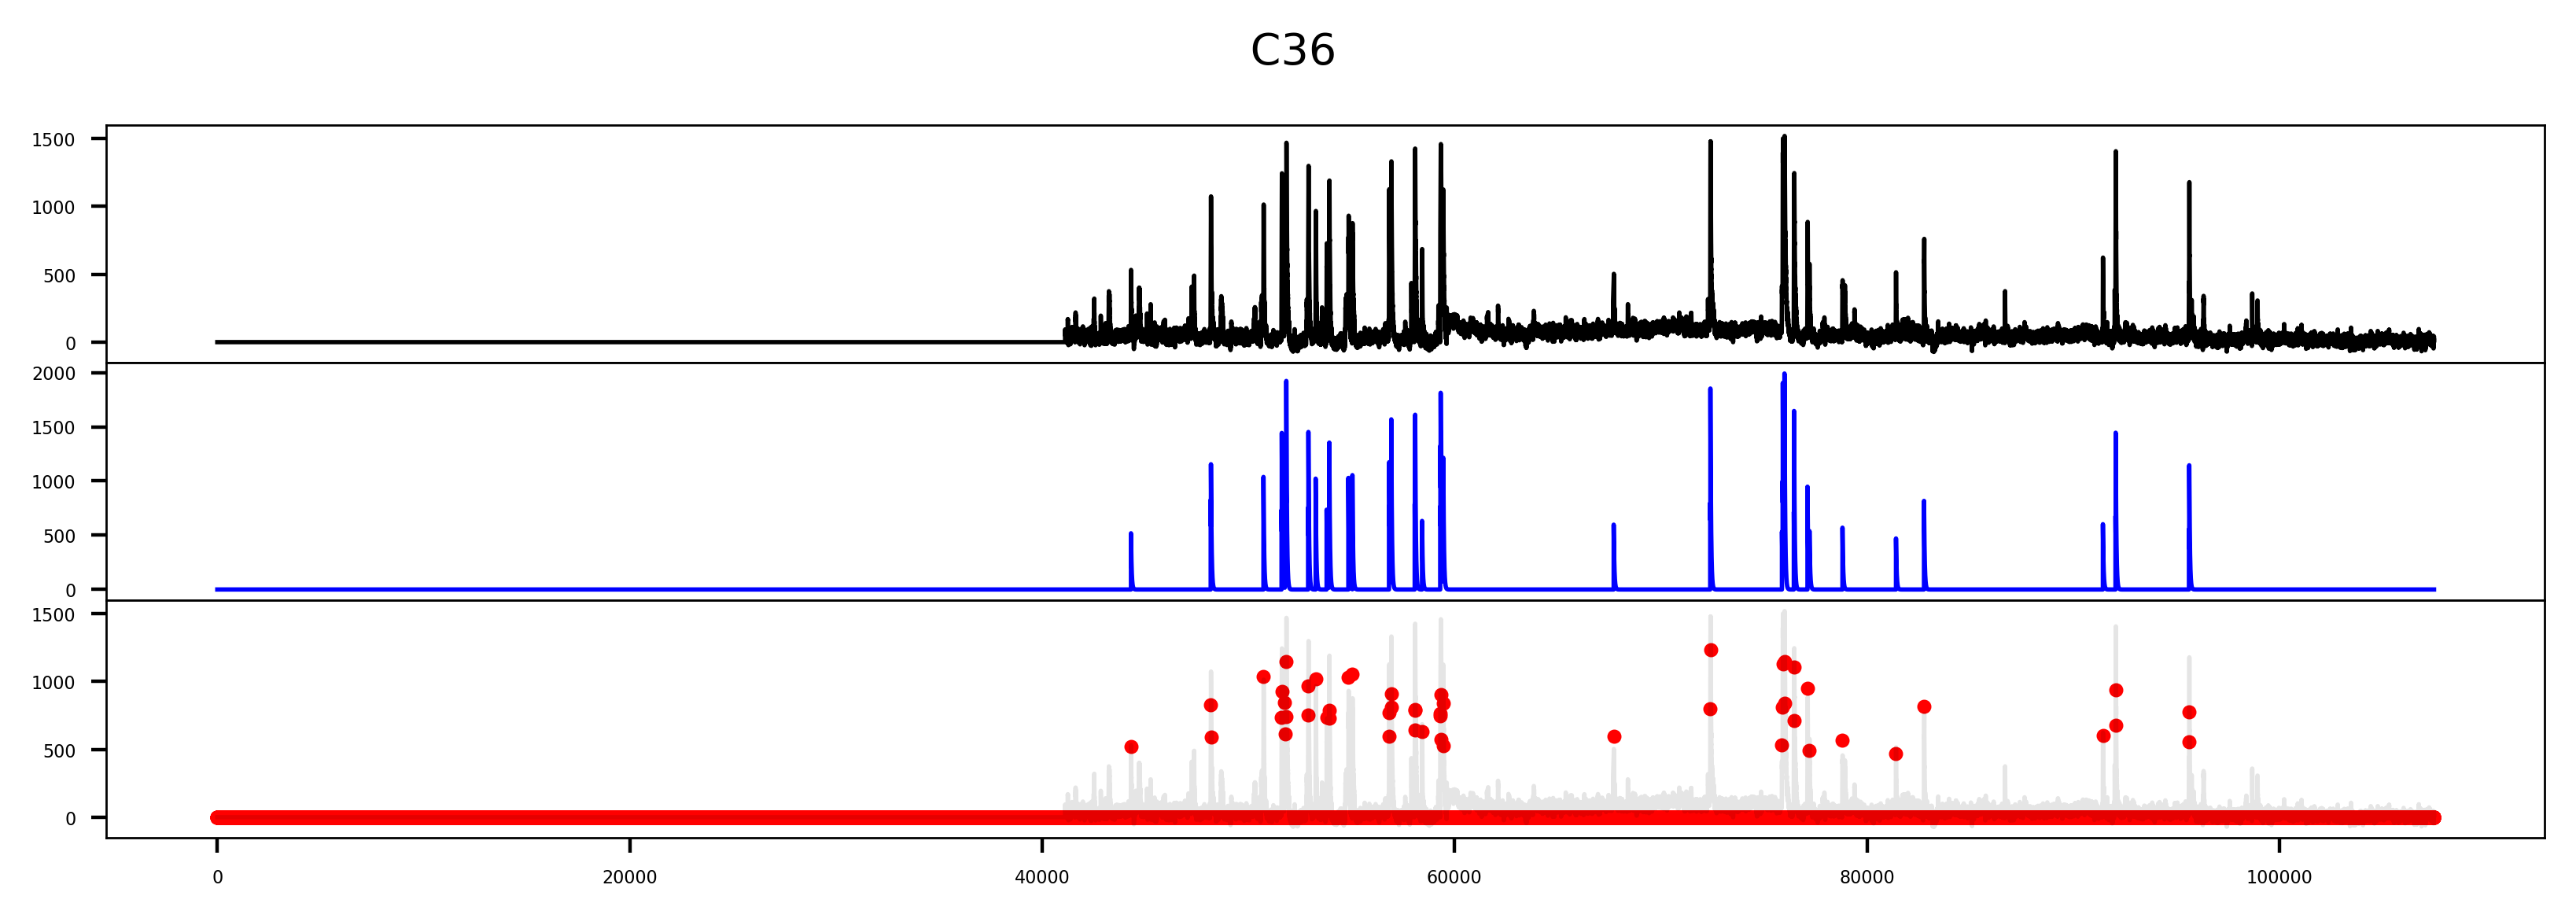

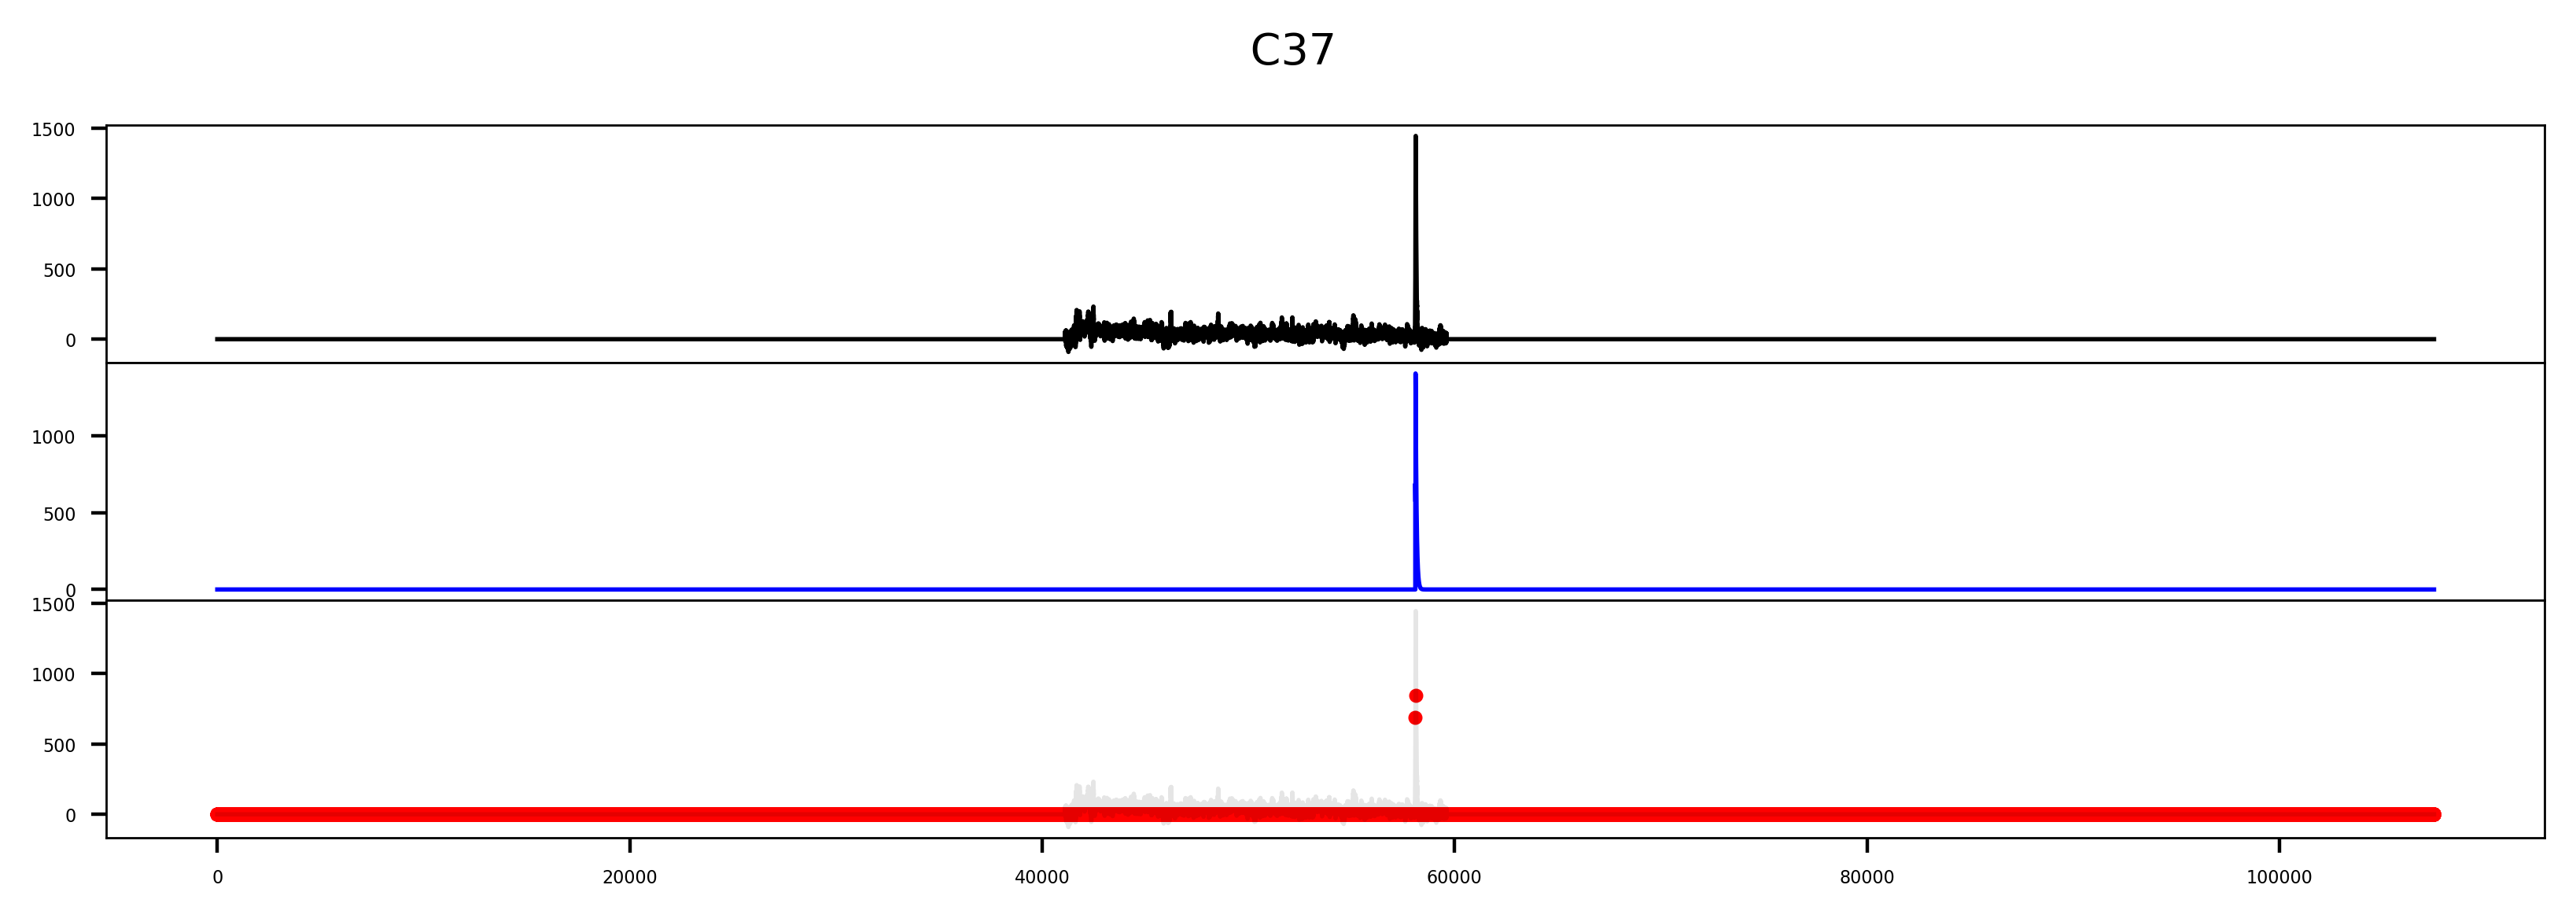

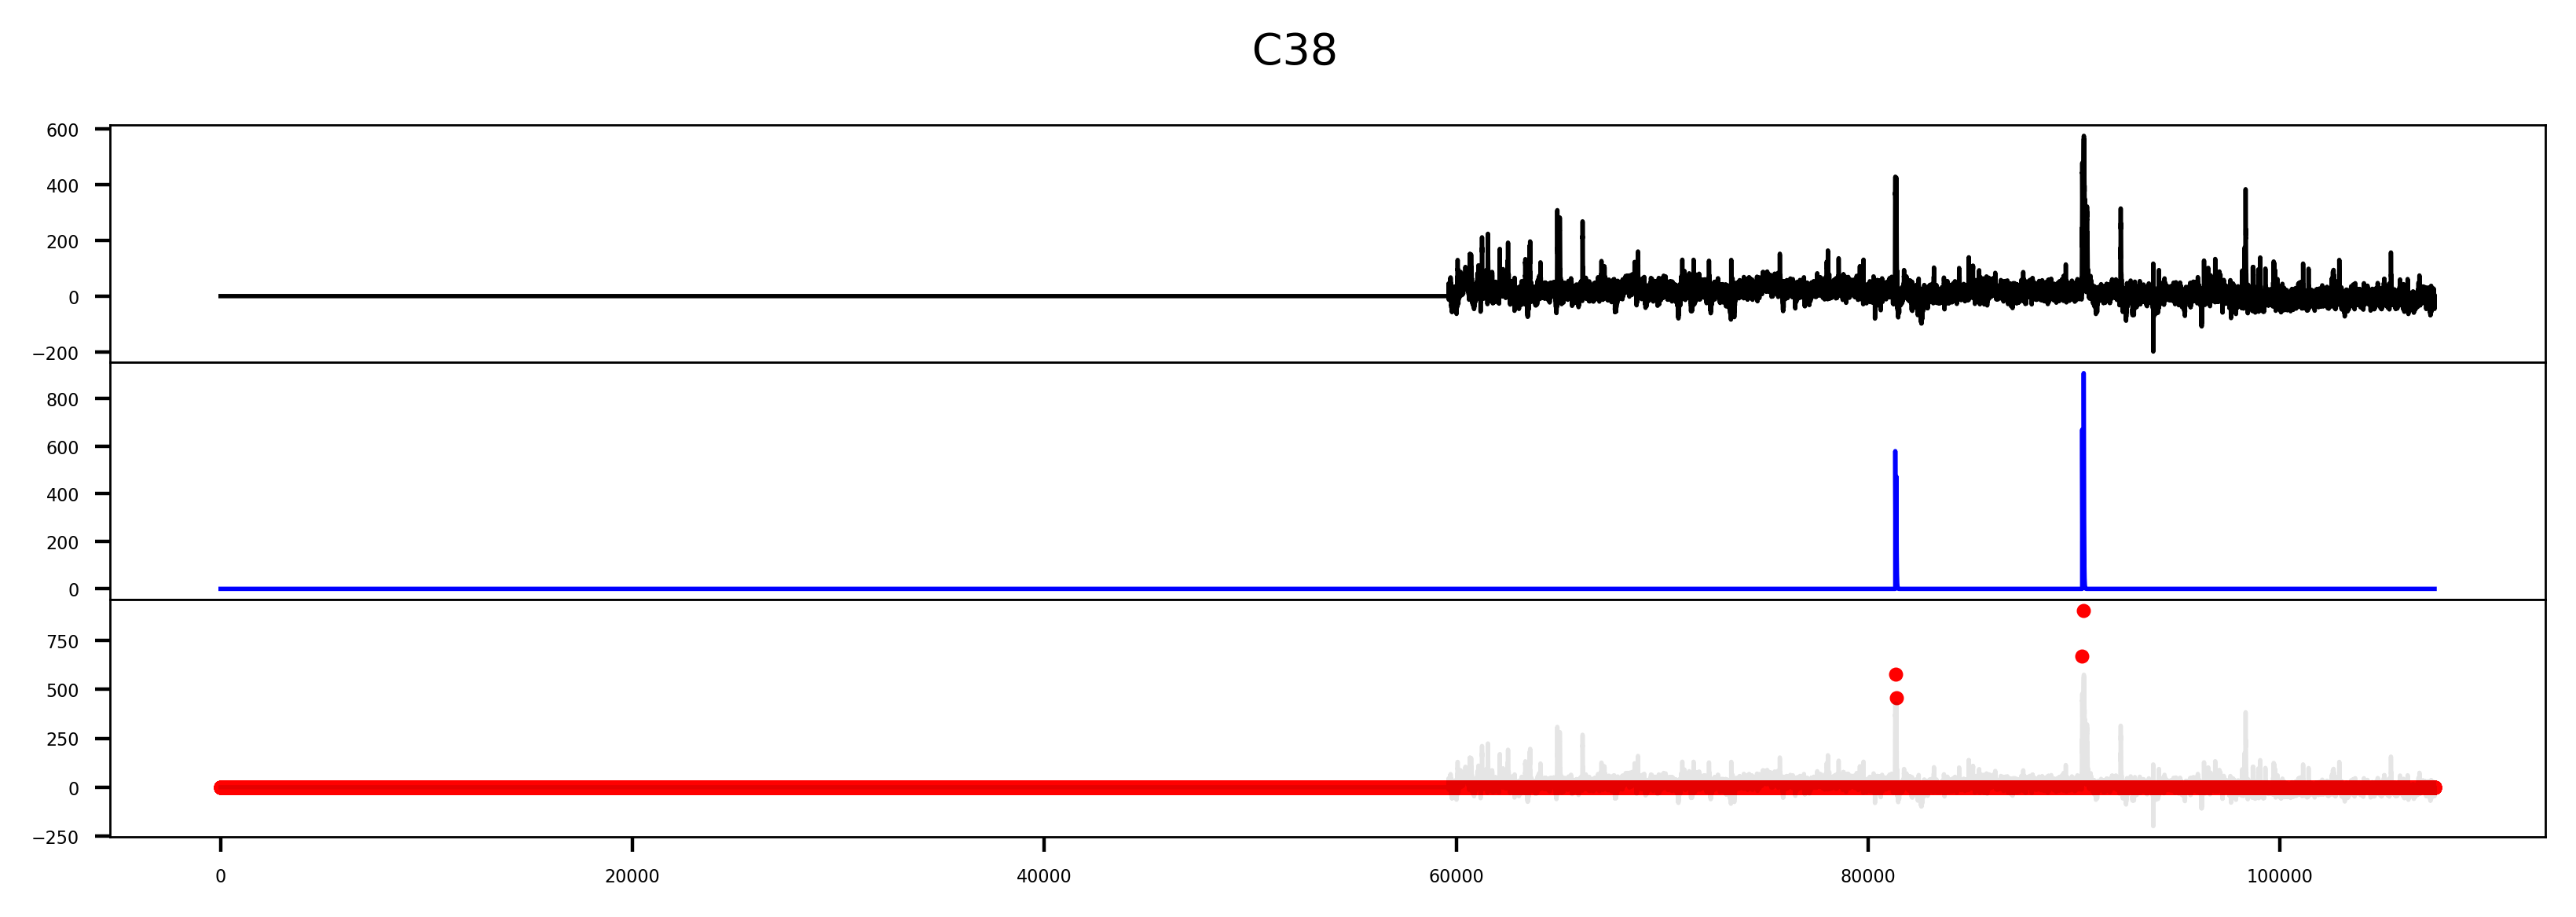

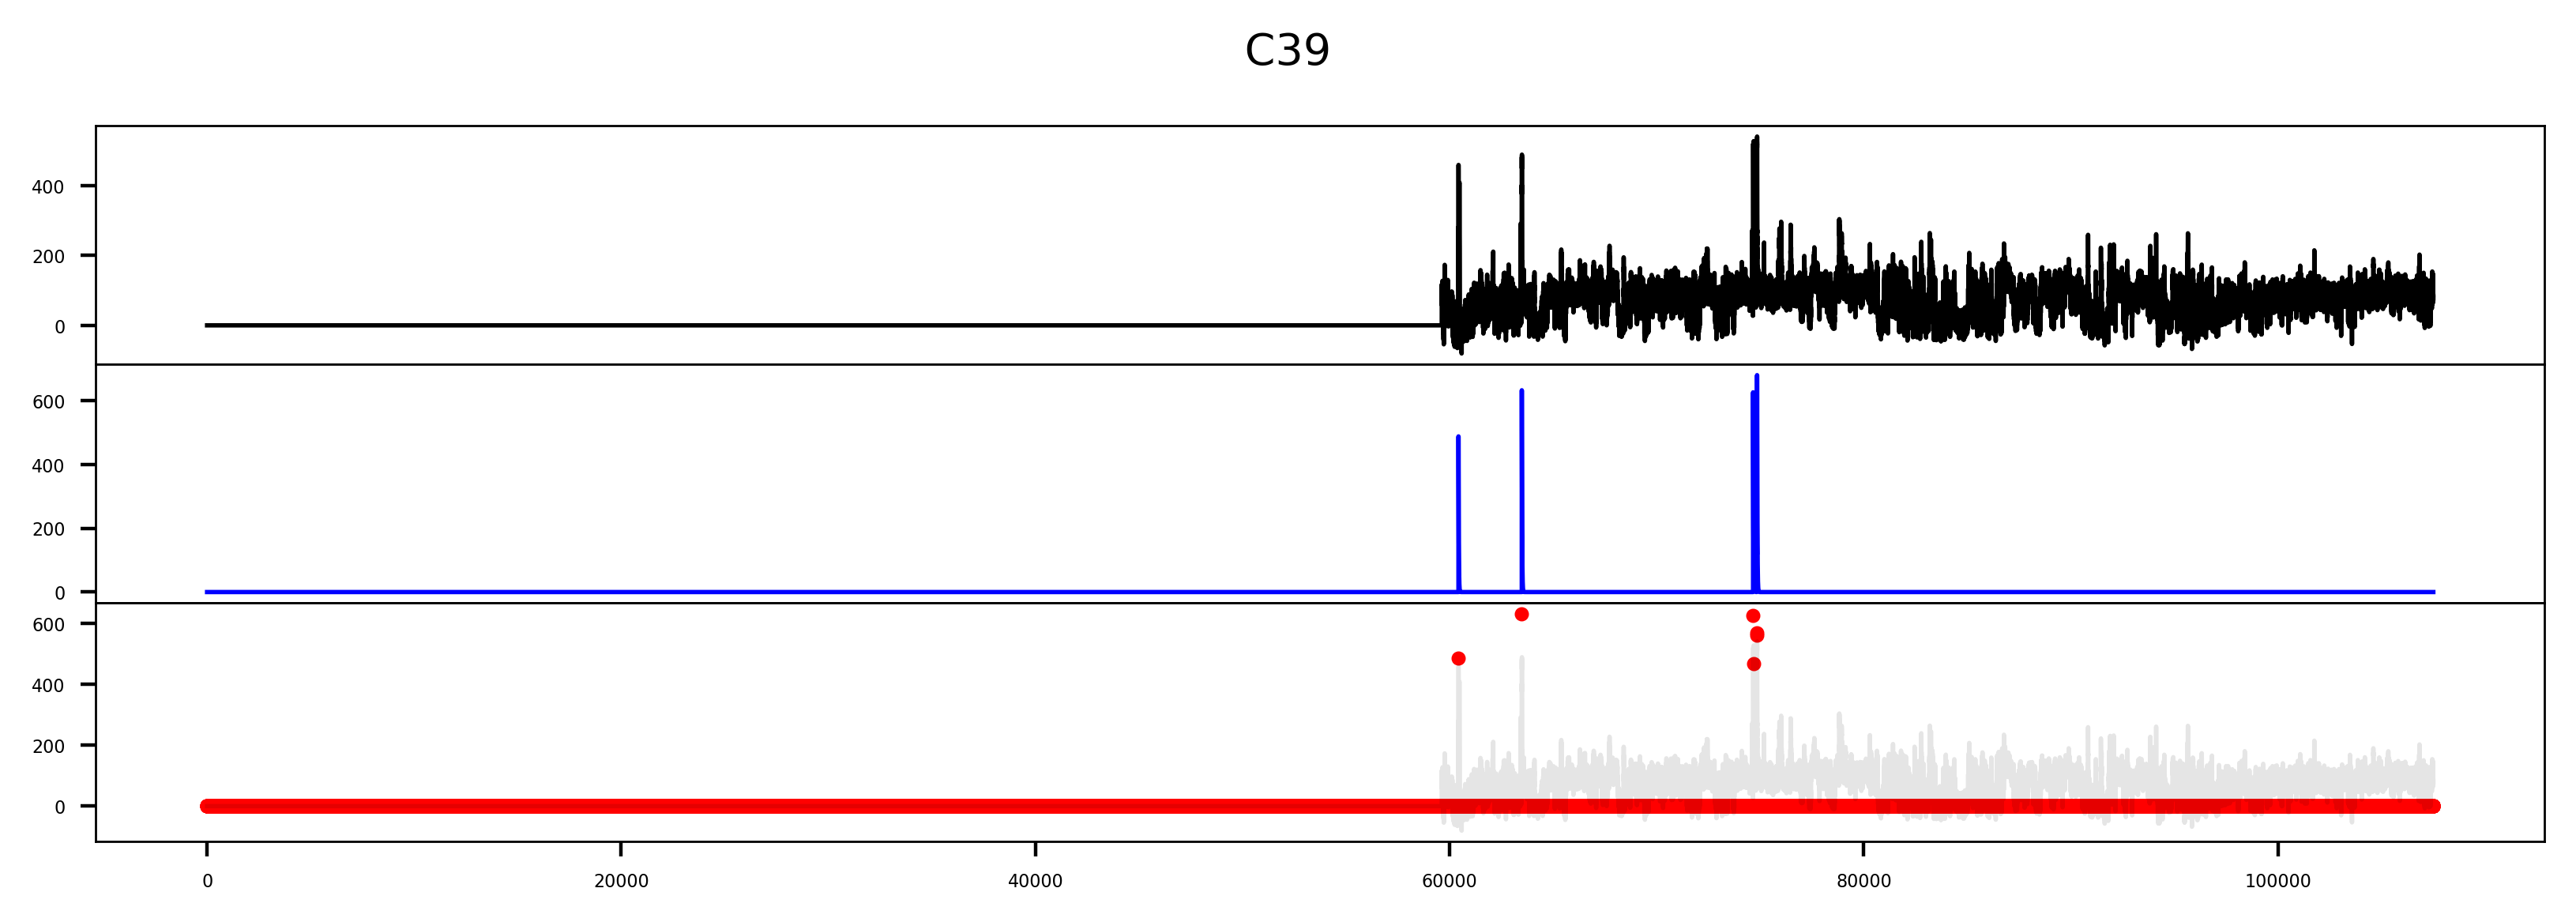

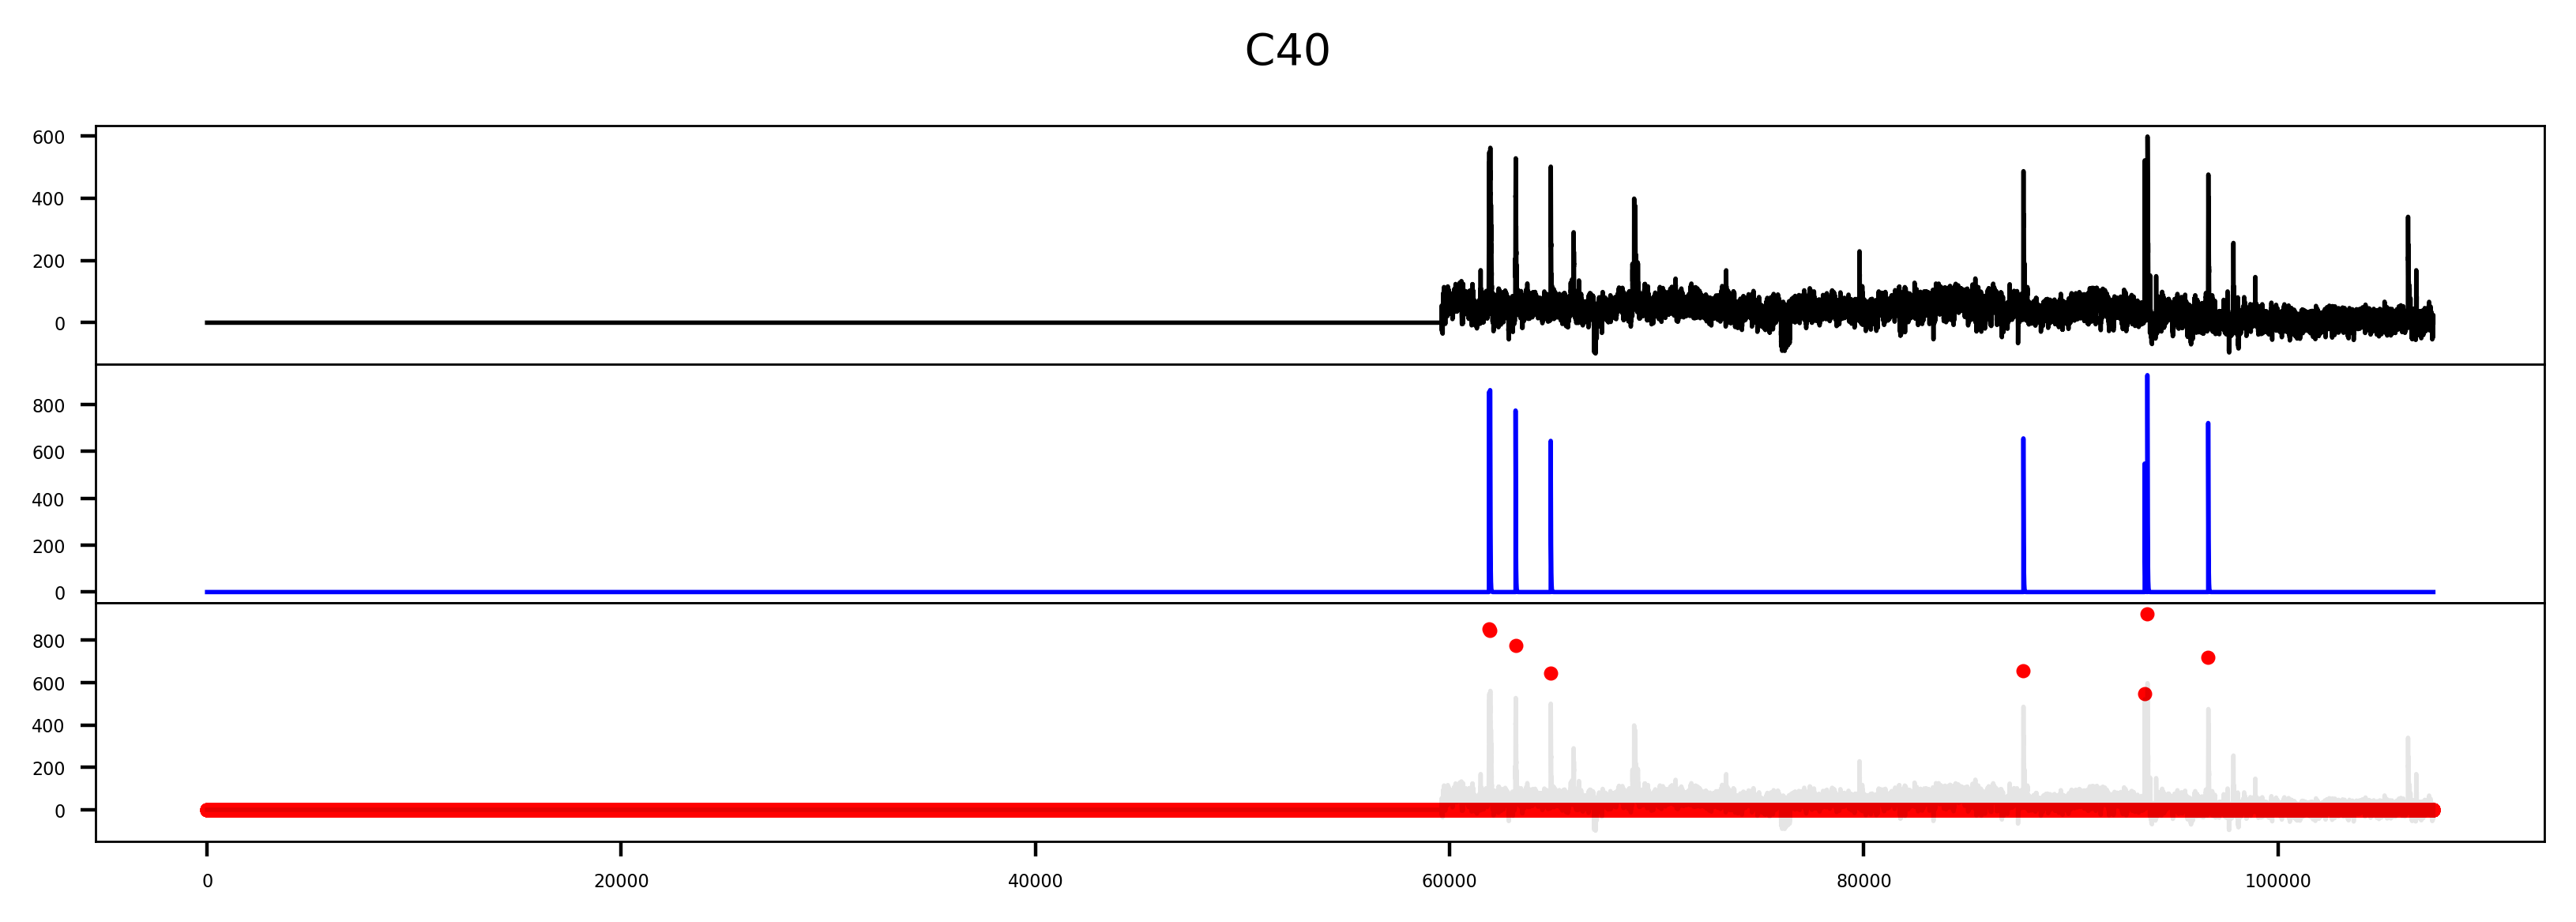

In [84]:
# #Params to investigate:
bl=None
c1=None
g=None
sn=15
p=1
method_deconvolution='oasis'
bas_nonneg=True
noise_range=[0, 50]
noise_method='logmexp'
lags=5
fudge_factor=.98
verbosity=False
solvers=None
optimize_g=100
s_min=400

#--------------------------------------------------------------------------------------------------------------------------------------------

trace_dlc = np.array(raw_traces.values.astype(float)).transpose()[:]
cells_tv = cells[:]
all_events = []
for cell in range(len(trace_dlc)):
    
    raw_trace = trace_dlc[cell]
#     raw_trace = np.array(raw_trace)/max(np.array(raw_trace)) #If we want traces between 0 and 1 (OPTIONAL)

    #OASIS function run through
    events = constrained_foopsi(raw_trace, 
                                bl=bl,  
                                c1=c1, 
                                g=g,  
                                sn=sn, 
                                p=p, 
                                method_deconvolution=method_deconvolution, 
                                bas_nonneg=bas_nonneg,
                                noise_range=noise_range,
                                noise_method=noise_method,
                                lags=lags,
                                fudge_factor=fudge_factor,
                                verbosity=verbosity,
                                solvers=solvers,
                                optimize_g=optimize_g,
                                s_min=s_min)
    
    
    all_events.append(events[5])
    #Viualising data
    fig, axs = plt.subplots(3, 1, figsize=(10,3), dpi=400, facecolor='w', edgecolor='k')
    gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,1]) 
    fig.suptitle(cells_tv[cell], fontsize=10)

    #Raw traces
    axs[0] = plt.subplot(gs[0])
    axs[0] = plt.plot(raw_trace, c='k', linewidth=1)

    #OASIS noise consideration
    axs[1] = plt.subplot(gs[1])
    axs[1] = plt.plot(events[0], c='b', linewidth=1)
    
    #Events plotted on raw trace
    axs[2] = plt.subplot(gs[2])
    axs[2] = plt.plot(raw_trace, c='k', alpha=0.1, linewidth=1)
    axs[2] = plt.scatter(np.arange(0,len(events[5]),1),events[5], c='r', s=5)
   
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    


In [85]:
need_higher_sn=[

]
try_lower=['02','12','13','21','22','32'

]

In [86]:
all_events_copy=all_events.copy()
need_higher_sn=[' C%s'%i for i in need_higher_sn]
try_lower=[' C%s'%i for i in try_lower]


In [87]:
all_events_copy=np.transpose(all_events_copy)
all_events_df=pd.DataFrame(data=all_events_copy, columns=be_a_cell)
"don't mind this error, it's a non error"

"don't mind this error, it's a non error"

In [88]:
#change the parameters for the subset "need higher SN"
sn=25
p=1
method_deconvolution='oasis'
bas_nonneg=True
noise_range=[0, 100]
noise_method='logmexp'
lags=5
fudge_factor=.98
verbosity=False
solvers=None
optimize_g=10
s_min=600

trace_dlc = np.array(raw_traces[need_higher_sn].values.astype(float)).transpose()[:]
cells = raw_traces[need_higher_sn].columns

cells_tv = cells[:]
all_events = []

for cell in range(len(trace_dlc)):
    
    raw_trace = trace_dlc[cell]
#     raw_trace = np.array(raw_trace)/max(np.array(raw_trace)) #If we want traces between 0 and 1 (OPTIONAL)

    #OASIS function run through
    events = constrained_foopsi(raw_trace, 
                                bl=bl,  
                                c1=c1, 
                                g=g,  
                                sn=sn, 
                                p=p, 
                                method_deconvolution=method_deconvolution, 
                                bas_nonneg=bas_nonneg,
                                noise_range=noise_range,
                                noise_method=noise_method,
                                lags=lags,
                                fudge_factor=fudge_factor,
                                verbosity=verbosity,
                                solvers=solvers,
                                optimize_g=optimize_g,
                                s_min=s_min)
    
    
    all_events.append(events[5])
    #Viualising data
    fig, axs = plt.subplots(3, 1, figsize=(10,3), dpi=400, facecolor='w', edgecolor='k')
    gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,1]) 
    fig.suptitle(cells_tv[cell], fontsize=10)

    #Raw traces
    axs[0] = plt.subplot(gs[0])
    axs[0] = plt.plot(raw_trace, c='k', linewidth=1)

    #OASIS noise consideration
    axs[1] = plt.subplot(gs[1])
    axs[1] = plt.plot(events[0], c='b', linewidth=1)
    
    #Events plotted on raw trace
    axs[2] = plt.subplot(gs[2])
    axs[2] = plt.plot(raw_trace, c='k', alpha=0.1, linewidth=1)
    axs[2] = plt.scatter(np.arange(0,len(events[5]),1),events[5], c='r', s=5)
   
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [89]:
all_events_df_higher_sn=pd.DataFrame(data=np.transpose(all_events), columns=need_higher_sn)


ValueError: Empty data passed with indices specified.

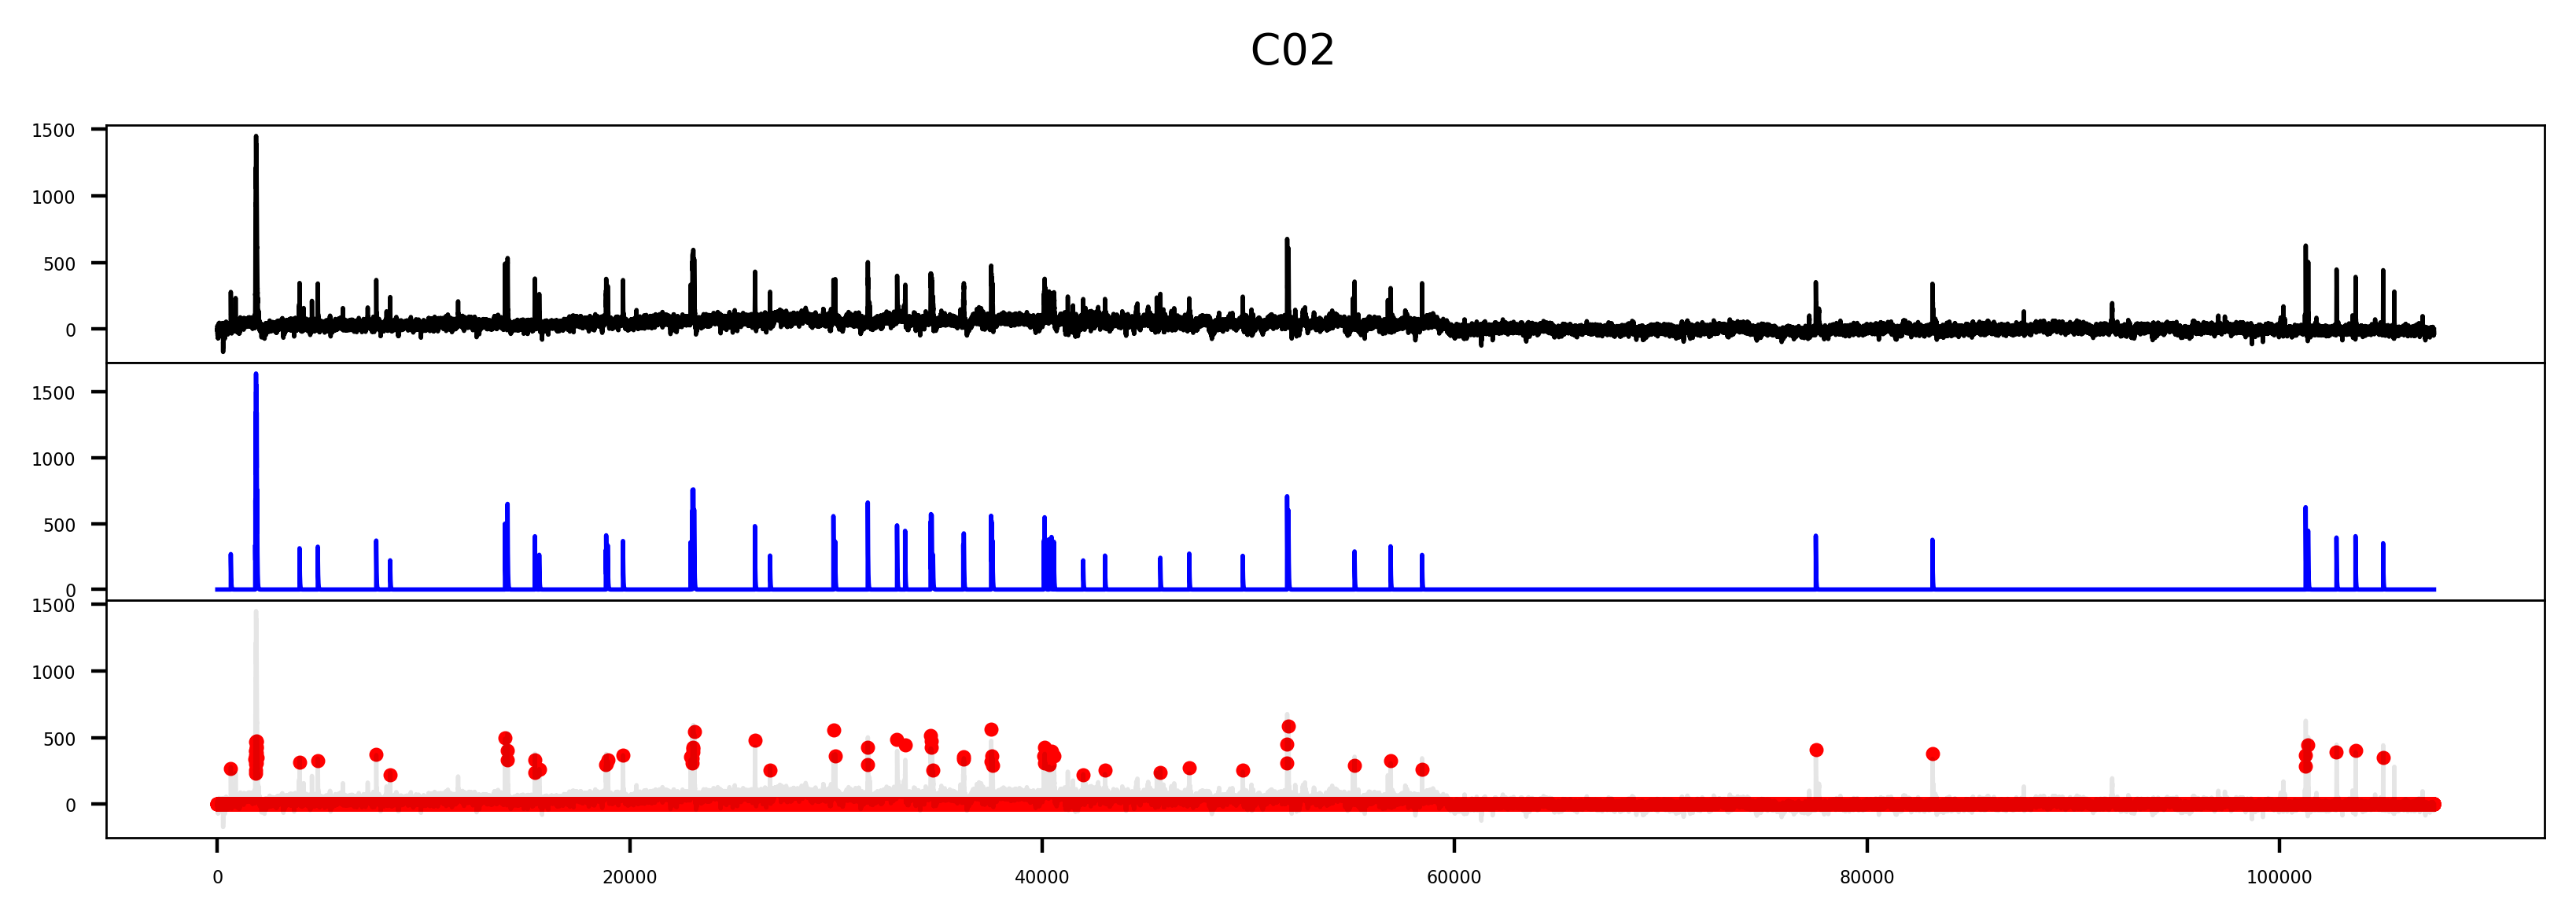

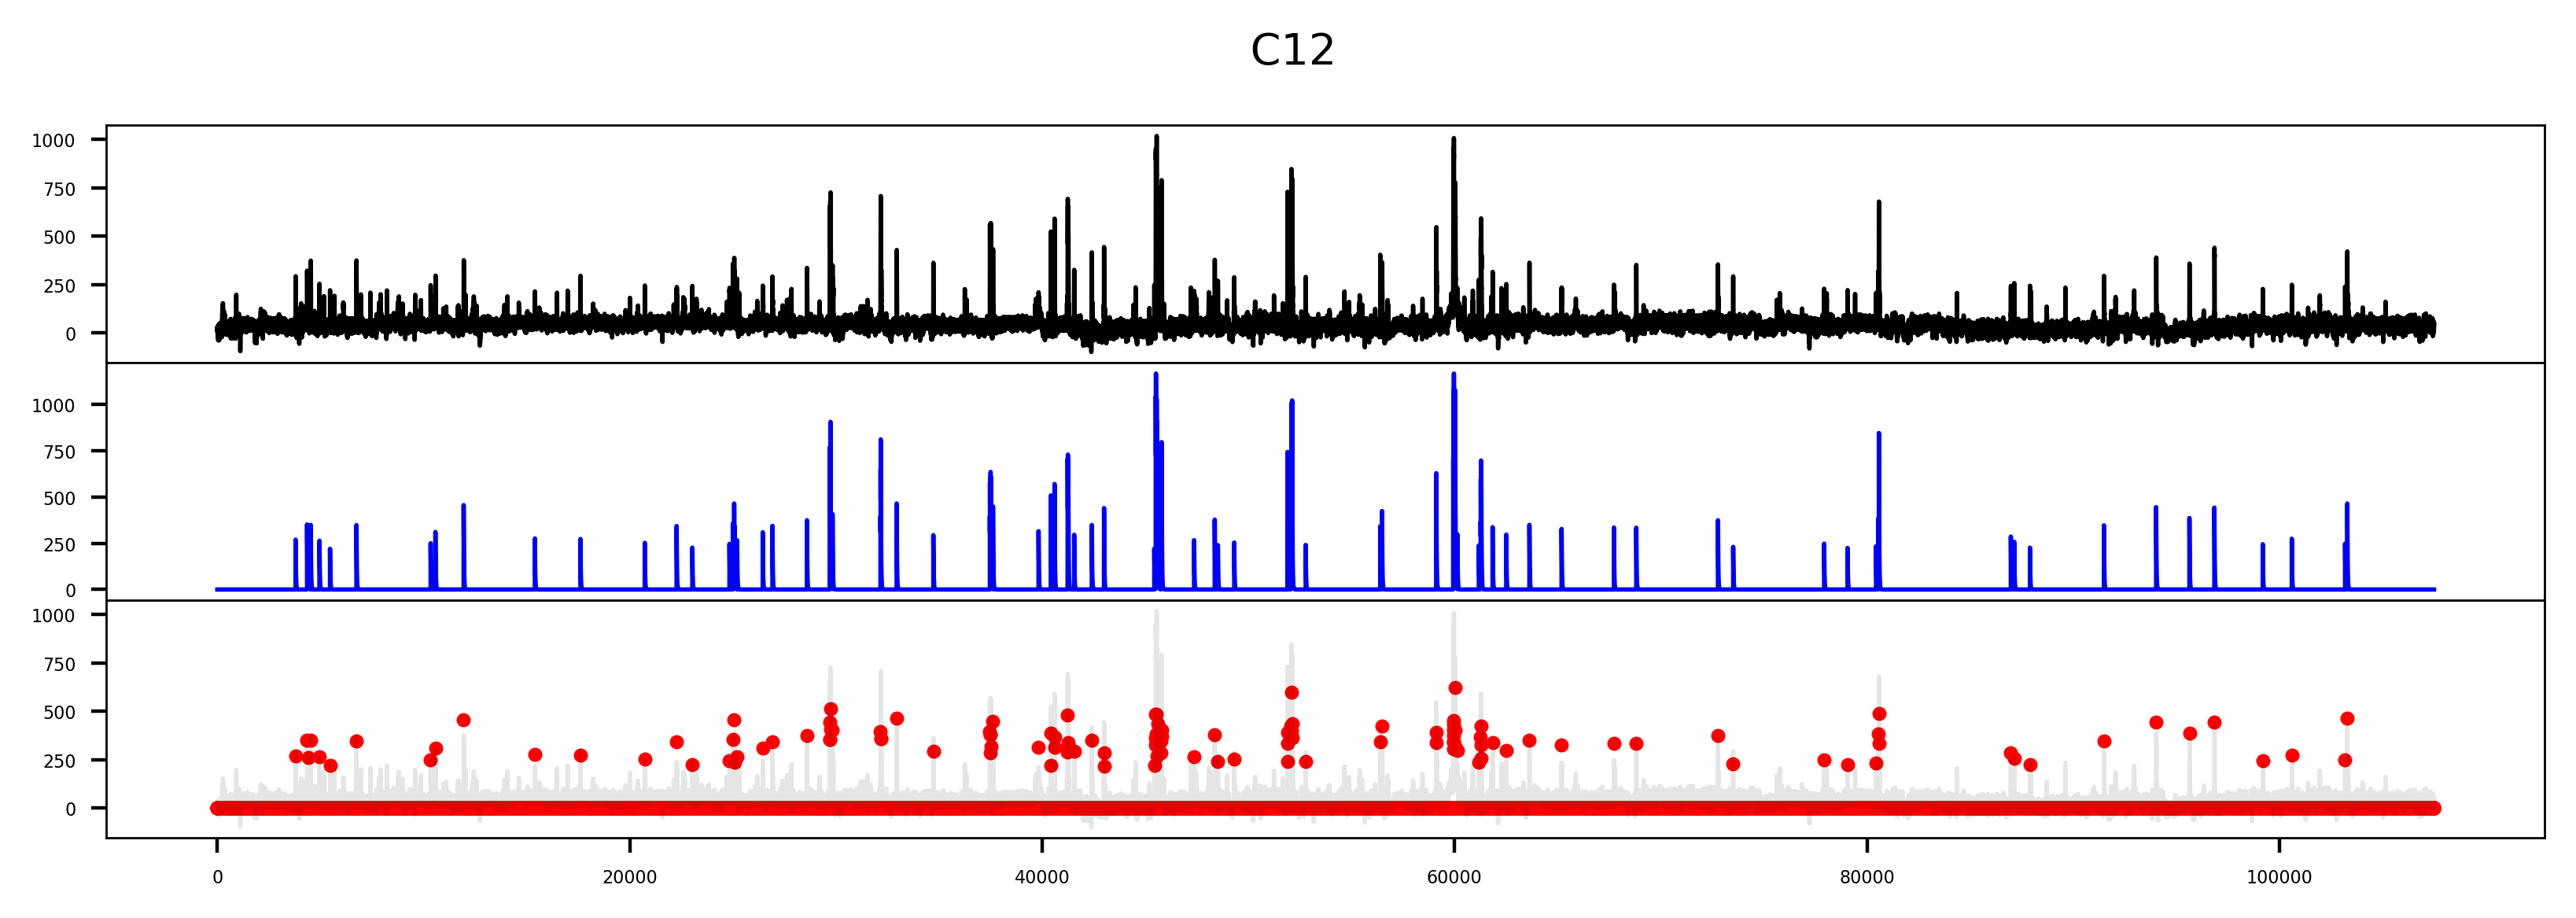

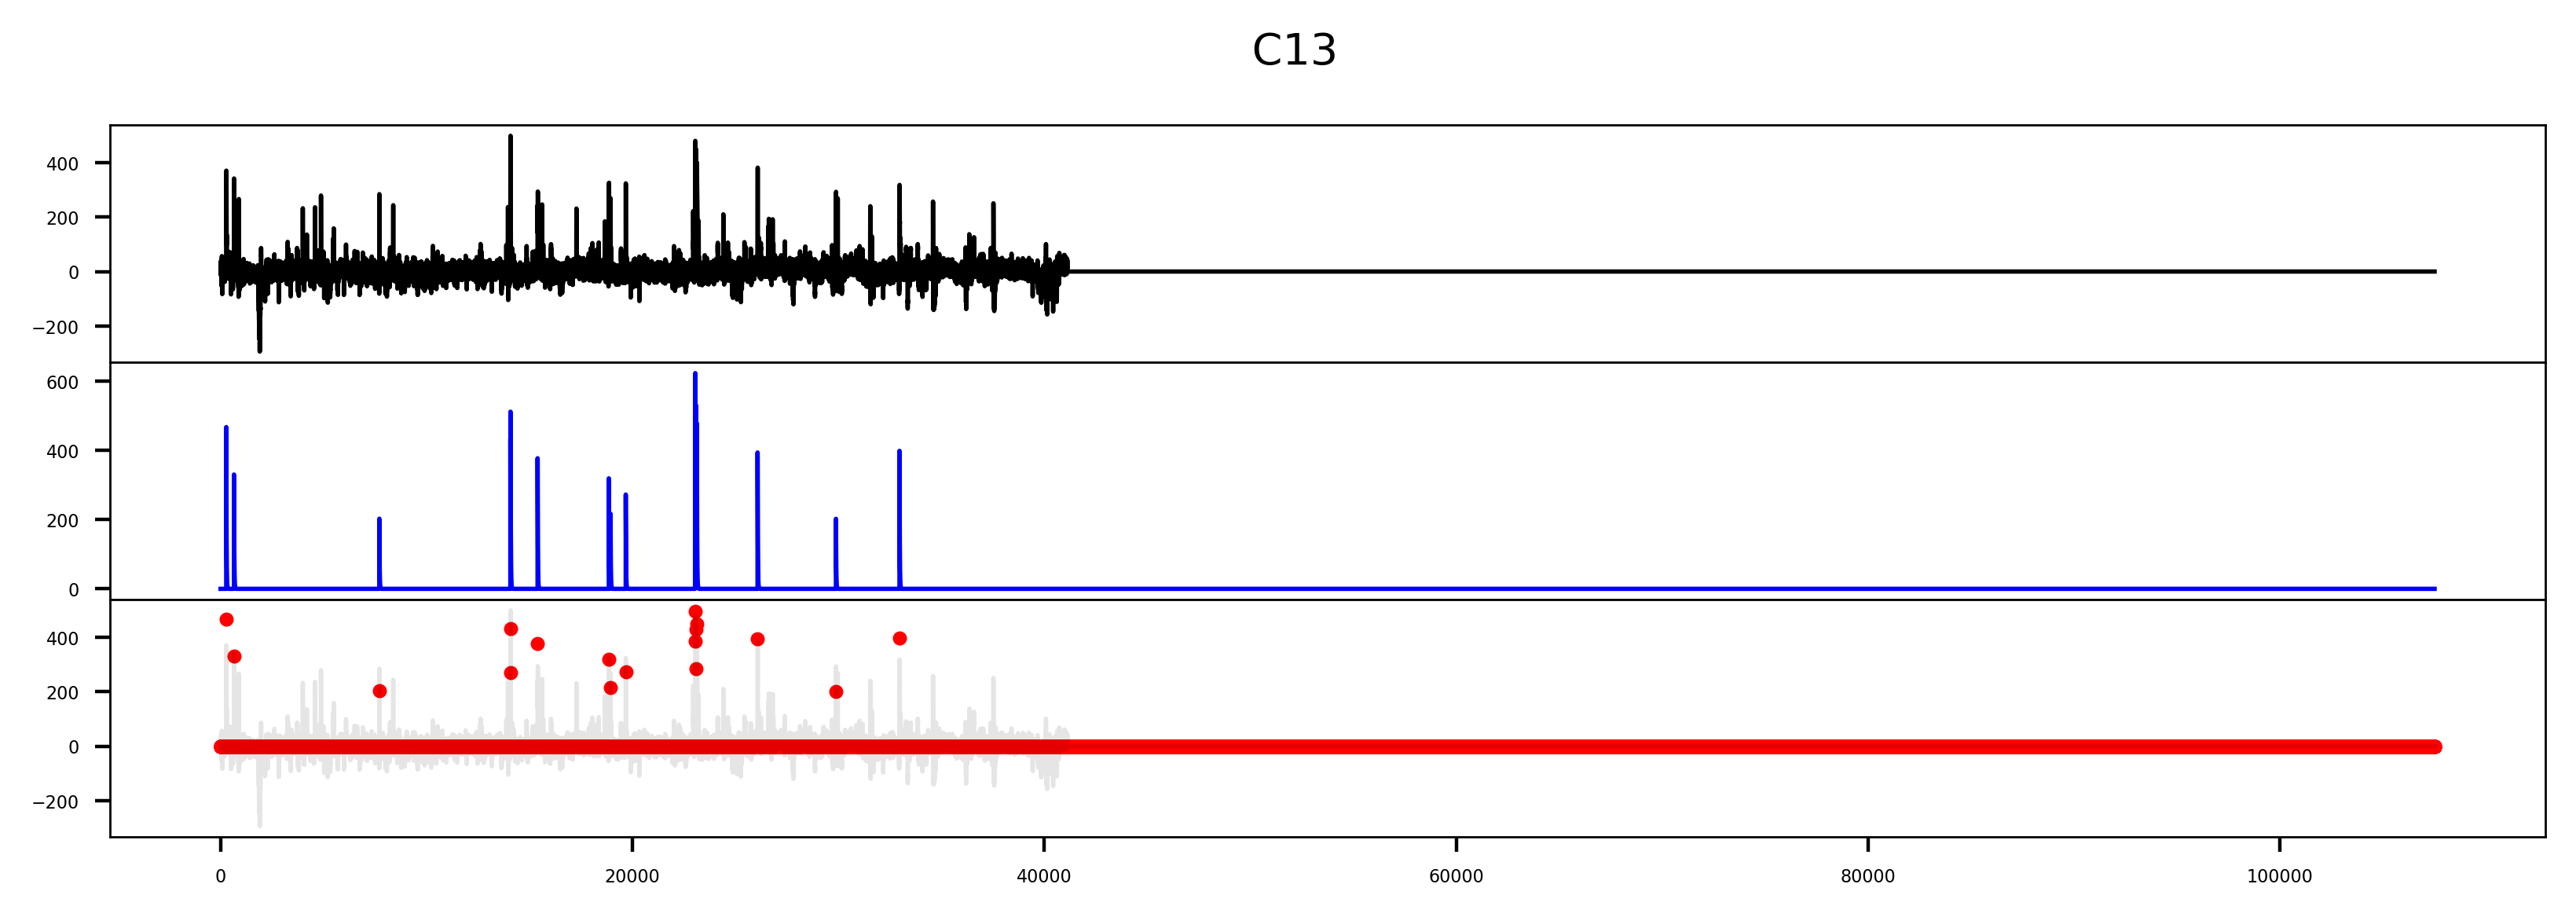

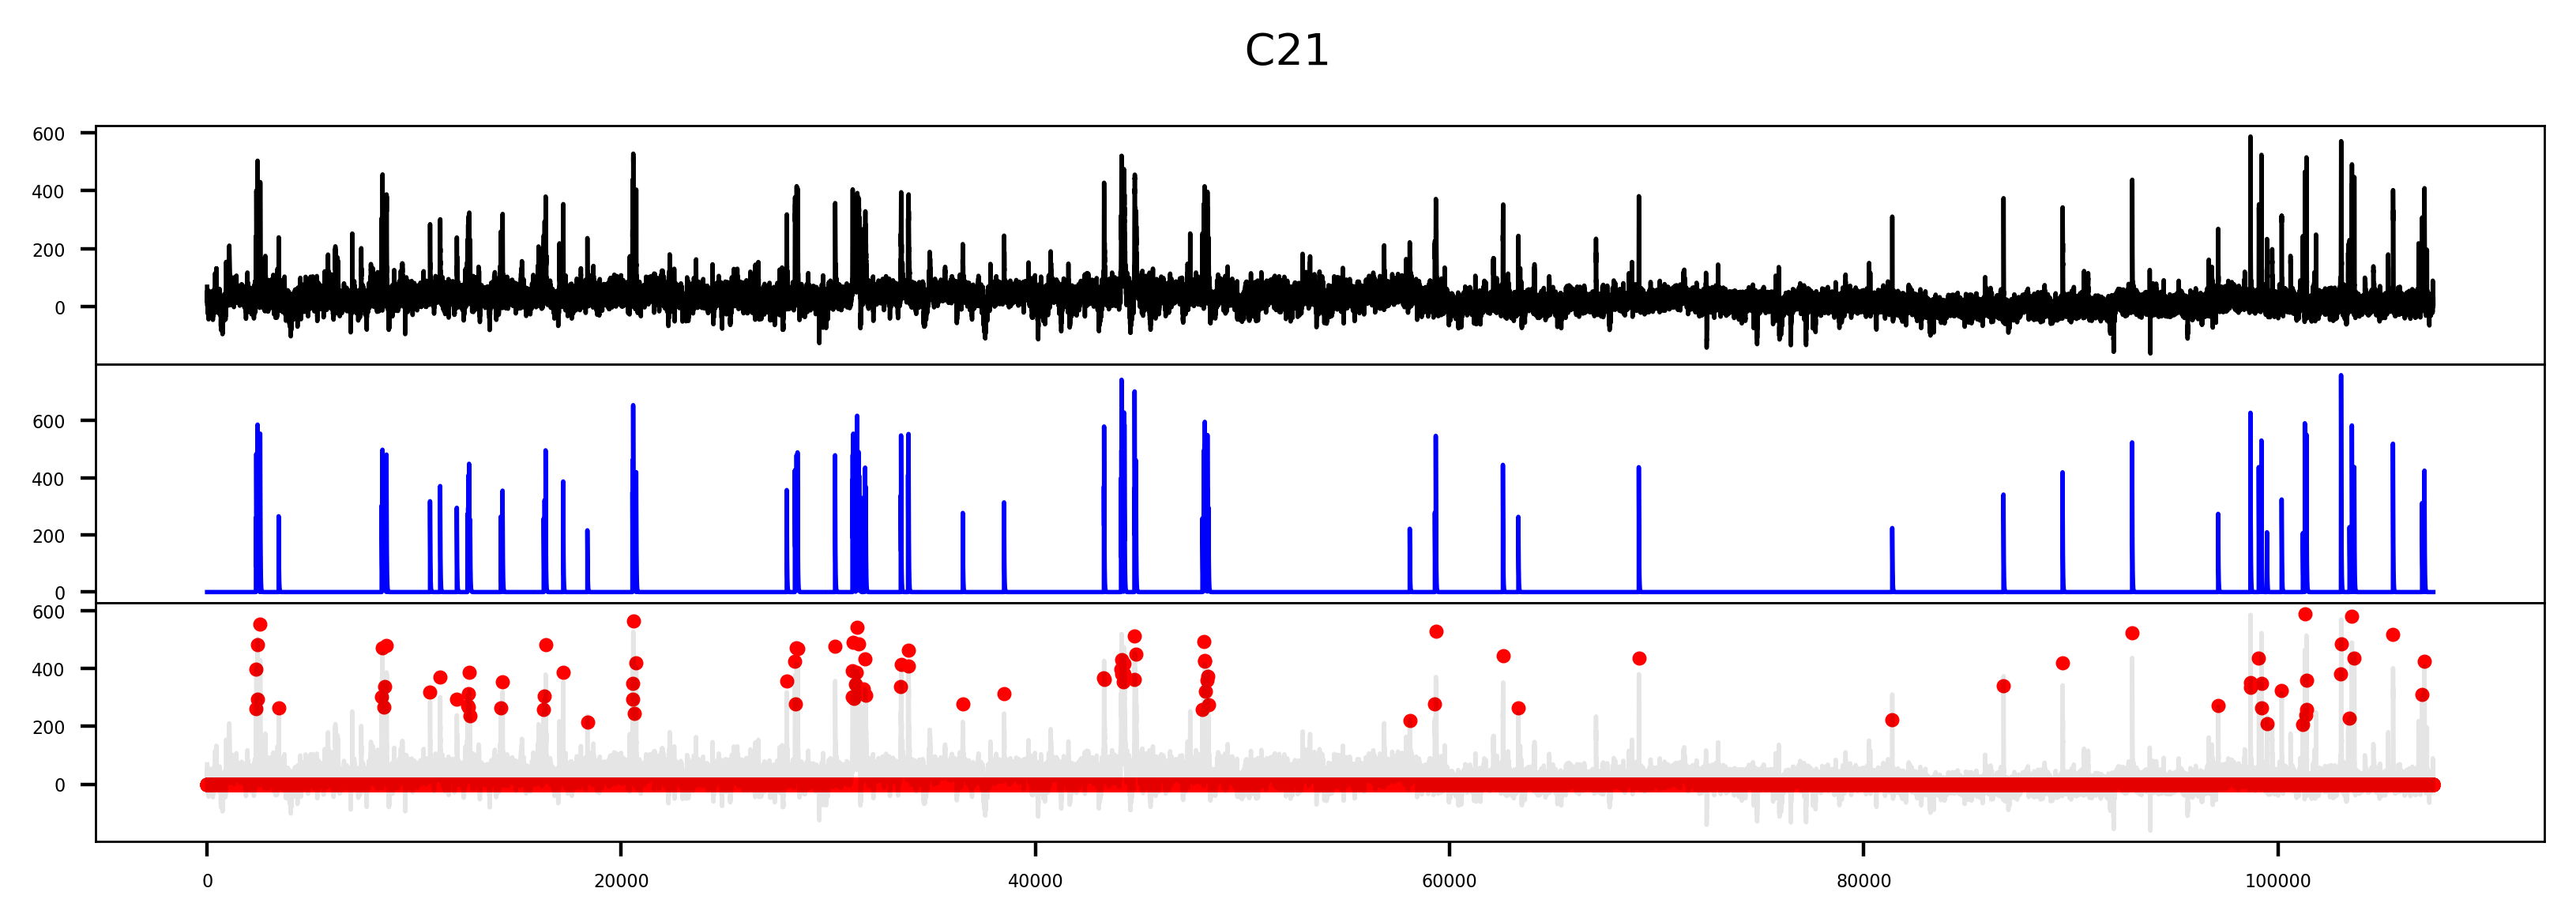

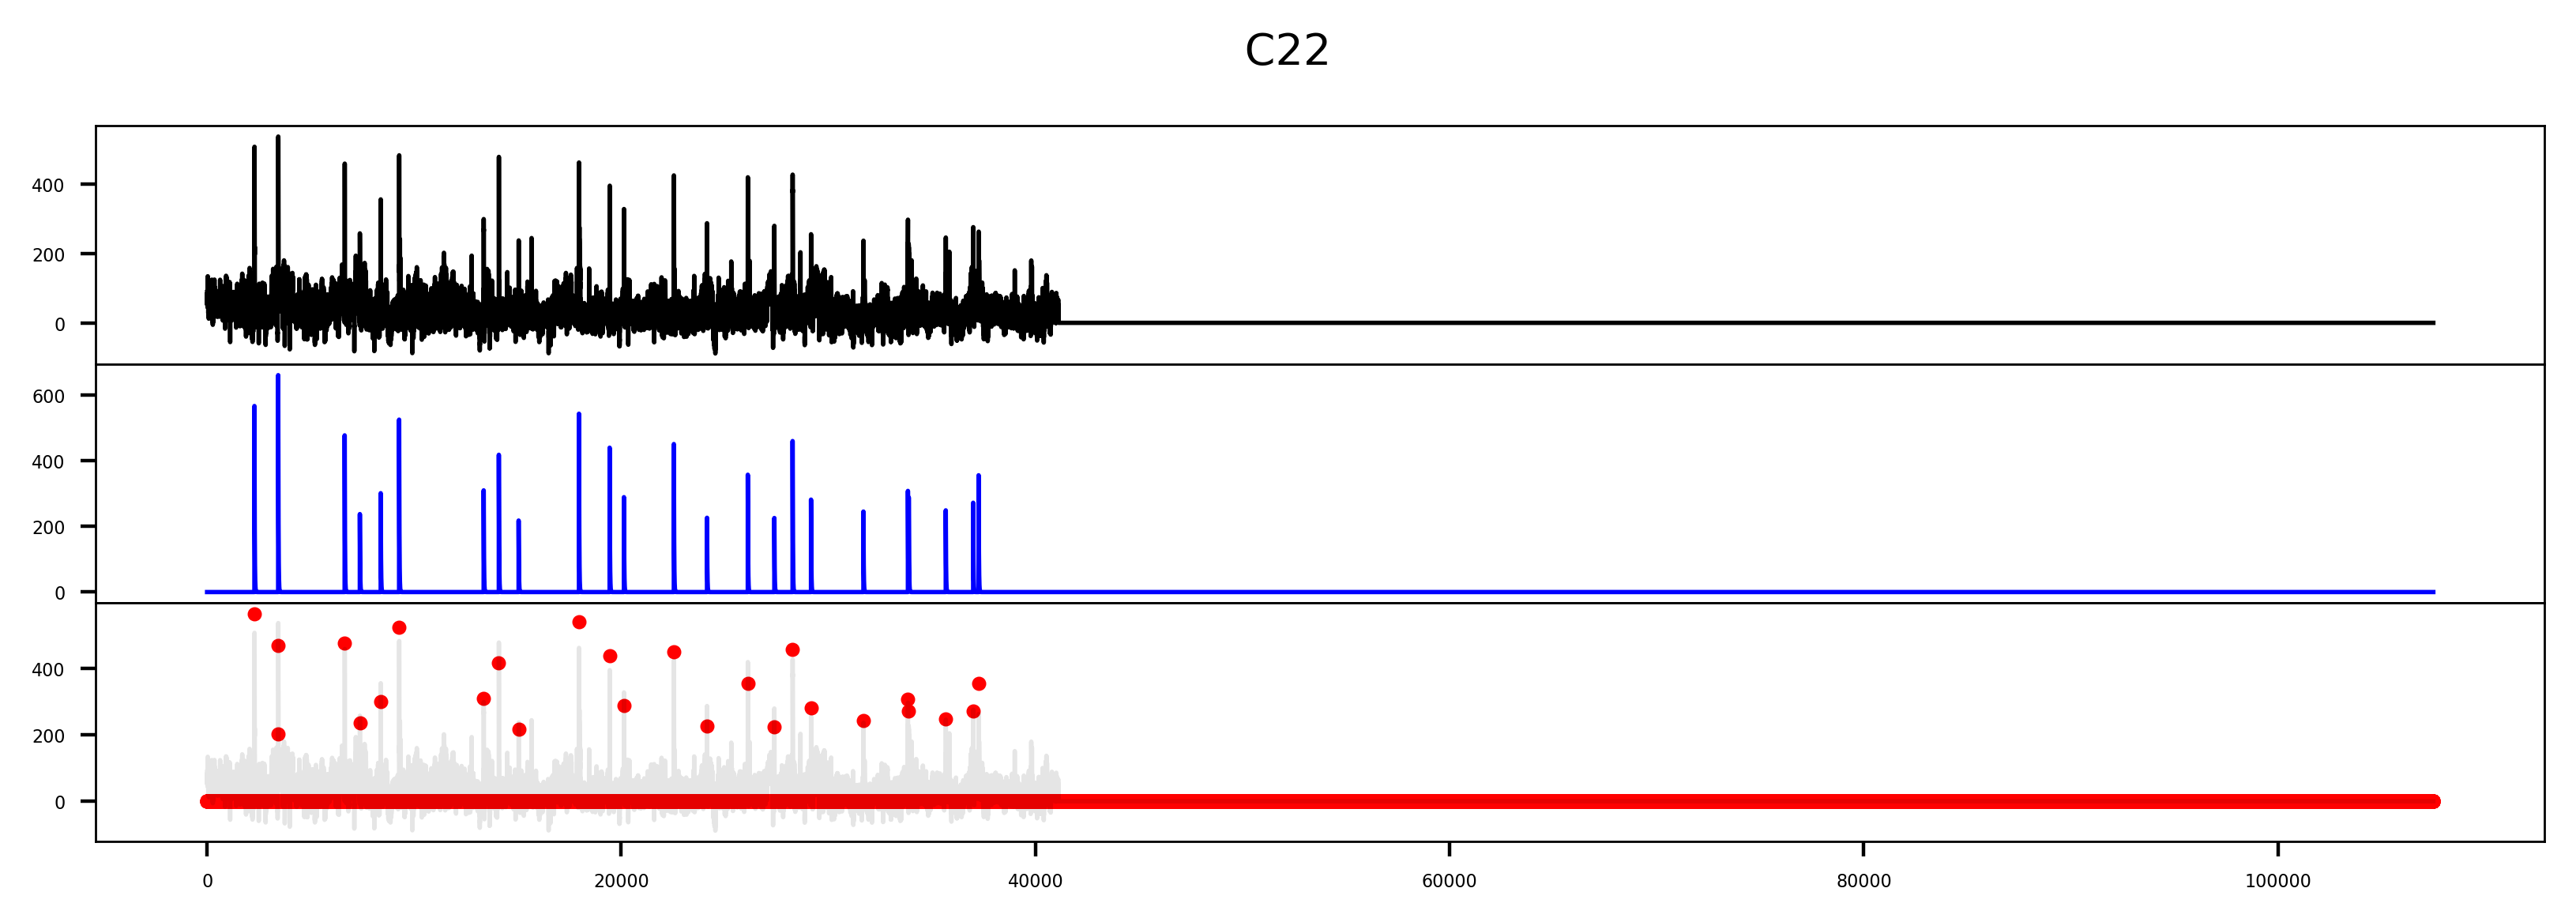

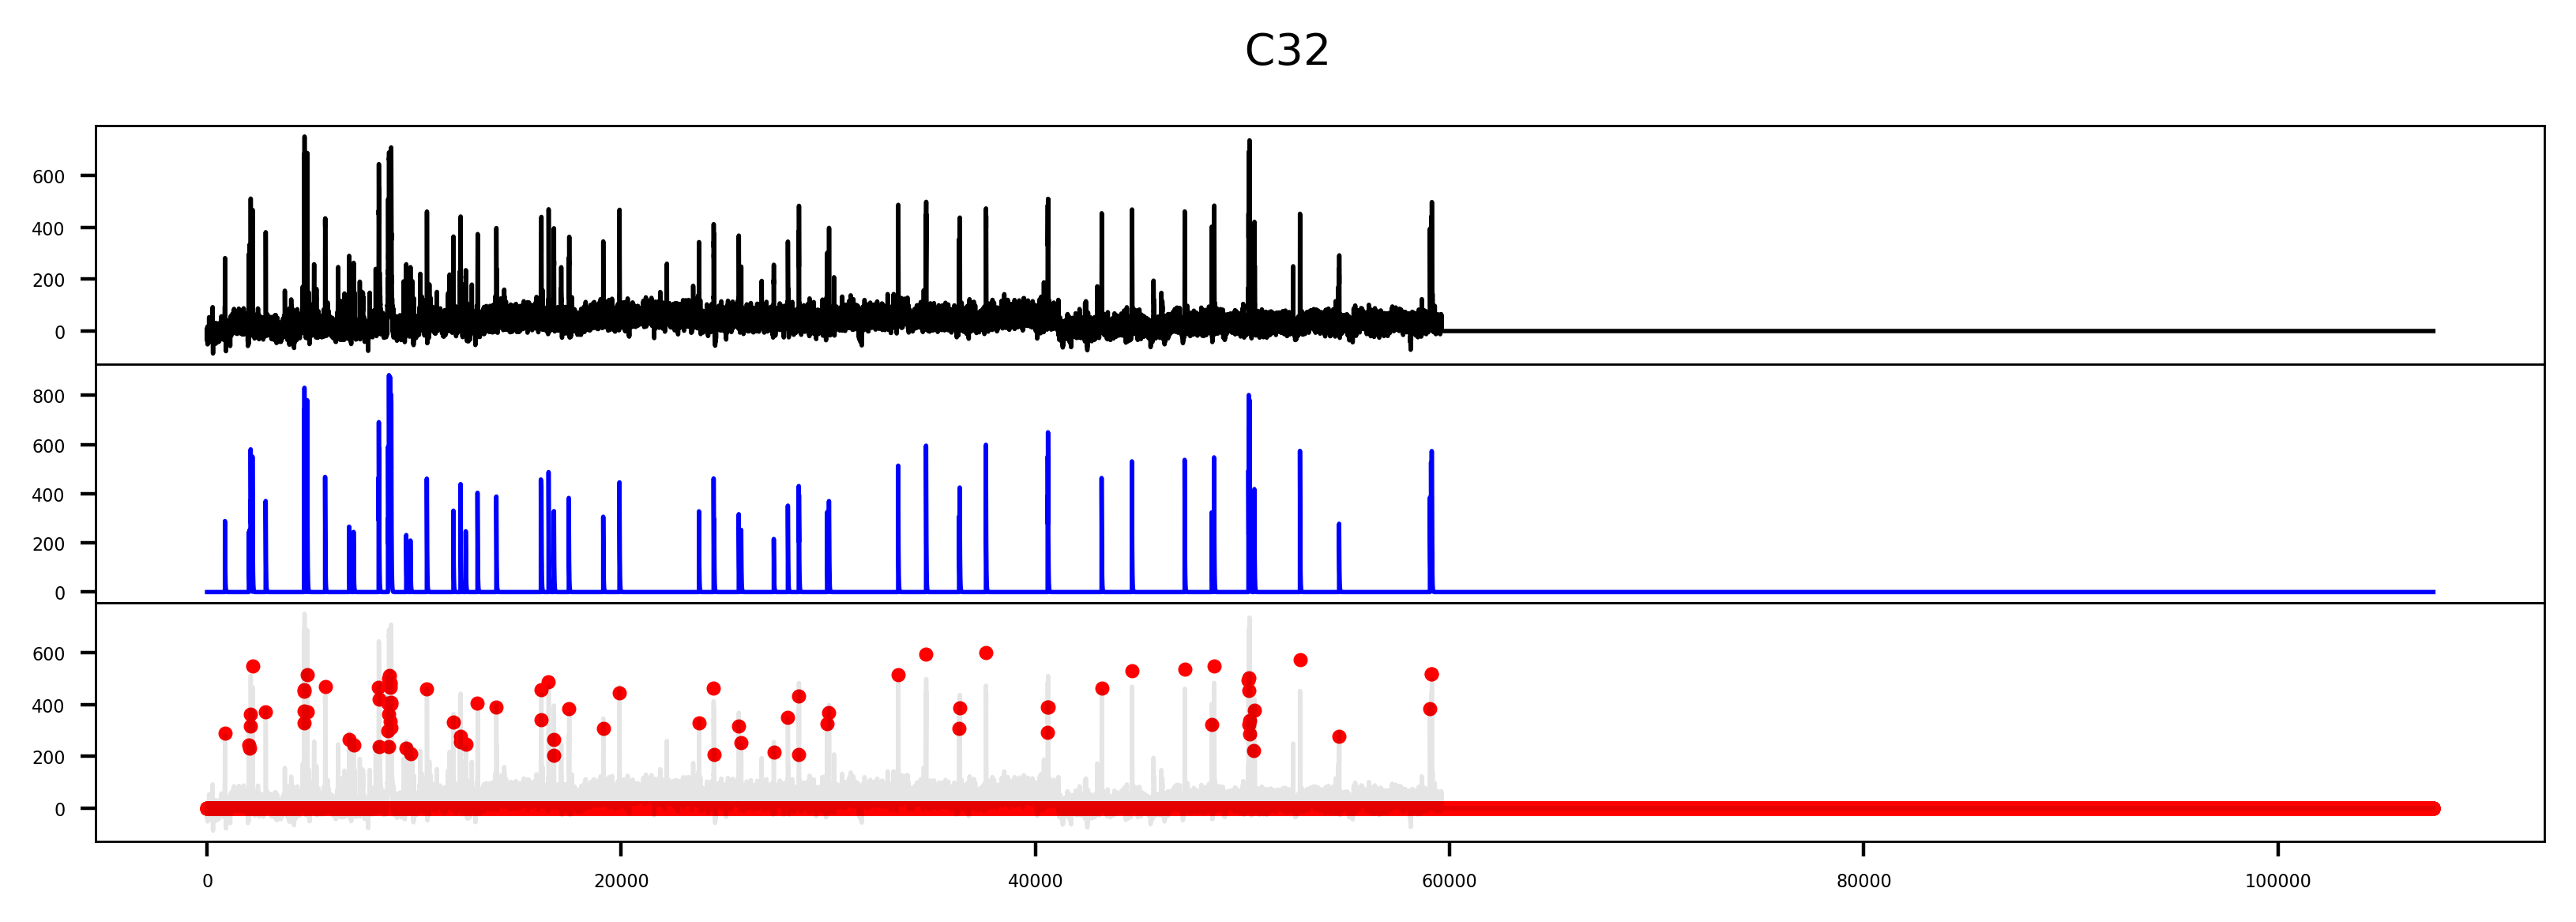

In [90]:
#change the parameters for the subset "try lower"

sn=10
p=1
method_deconvolution='oasis'
bas_nonneg=True
noise_range=[0, 200]
noise_method='logmexp'
lags=5
fudge_factor=.98
verbosity=False
solvers=None
optimize_g=5
s_min=200

trace_dlc = np.array(raw_traces[try_lower].values.astype(float)).transpose()[:]
cells = raw_traces[try_lower].columns

cells_tv = cells[:]
all_events = []

for cell in range(len(trace_dlc)):
    
    raw_trace = trace_dlc[cell]
#     raw_trace = np.array(raw_trace)/max(np.array(raw_trace)) #If we want traces between 0 and 1 (OPTIONAL)

    #OASIS function run through
    events = constrained_foopsi(raw_trace, 
                                bl=bl,  
                                c1=c1, 
                                g=g,  
                                sn=sn, 
                                p=p, 
                                method_deconvolution=method_deconvolution, 
                                bas_nonneg=bas_nonneg,
                                noise_range=noise_range,
                                noise_method=noise_method,
                                lags=lags,
                                fudge_factor=fudge_factor,
                                verbosity=verbosity,
                                solvers=solvers,
                                optimize_g=optimize_g,
                                s_min=s_min)
    
    
    all_events.append(events[5])
    #Viualising data
    fig, axs = plt.subplots(3, 1, figsize=(10,3), dpi=400, facecolor='w', edgecolor='k')
    gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,1]) 
    fig.suptitle(cells_tv[cell], fontsize=10)

    #Raw traces
    axs[0] = plt.subplot(gs[0])
    axs[0] = plt.plot(raw_trace, c='k', linewidth=1)

    #OASIS noise consideration
    axs[1] = plt.subplot(gs[1])
    axs[1] = plt.plot(events[0], c='b', linewidth=1)
    
    #Events plotted on raw trace
    axs[2] = plt.subplot(gs[2])
    axs[2] = plt.plot(raw_trace, c='k', alpha=0.1, linewidth=1)
    axs[2] = plt.scatter(np.arange(0,len(events[5]),1),events[5], c='r', s=5)
   
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [91]:
all_events_df_lower_sn=pd.DataFrame(data=np.transpose(all_events), columns=try_lower)


In [92]:
def overwrite_events(df1, df2):
        df3=df2.copy()
        the_rest=[i for i in list(df1.columns) if i not in list(df2.columns)]
        df3[the_rest]=df1[the_rest]
        return df3
all_events_df_4=all_events_df.copy()


In [93]:
df3=all_events_df_4#overwrite_events(all_events_df_4,all_events_df_higher_sn)
all_EVE=overwrite_events(df3, all_events_df_lower_sn)

In [94]:
all_EVE=all_EVE.sort_index(axis=1)
all_EVE['Time']=all_traces_dlc['Time']


In [95]:
#all_EVE=all_EVE.drop([ ' C007'], axis=1)

In [96]:
folder=r'\\172.16.251.125\Inscopix\Francesco\H2234 - 4X\H2234_4X_EGO_PH2\EVE'
all_EVE.to_csv(os.path.join(folder, file[:-7]+'EVE.csv'))

In [ ]:
all_EVE.columns